# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_AD2_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for AD2 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_AD2_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# AD2_twas = fread("~/project/image_QTL/twas/multiple_testing/image_AD2_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
AD2_twas = fread("~/project/image_QTL/twas/image_AD2_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [7]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [5]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- AD2_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [6]:
head(AD2_twas)
dim(AD2_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,enet,TRUE,FALSE,0.098757440,8.923911e-10,2.492697,0.01267771,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,lasso,TRUE,FALSE,0.103370596,3.541036e-10,2.475217,0.01331554,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,mrash,TRUE,FALSE,0.089177838,6.013310e-09,2.493315,0.01265565,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,susie,TRUE,TRUE,0.121638427,8.766557e-12,2.505183,0.01223882,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD2,enet,TRUE,FALSE,0.007872702,5.201216e-02,1.830248,0.06721286,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD2,lasso,TRUE,FALSE,0.006195072,7.447581e-02,1.827701,0.06759438,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 903842     19

In [7]:
# Strong and reliable TWAS signals:
AD2_twas_filtered <- AD2_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
AD2_block = unique(AD2_twas_filtered$block)

In [11]:
dim(AD2_twas_filtered)

[1] 817  19

In [8]:
# R Script to Process TWAS/SuSiE Fine-mapping Results Across Multiple Cohorts
# MULTI-COHORT CONTEXT-AWARE VERSION - Extract ALL variants in credible sets
# Processes each cohort-block-context combination separately to identify all CS variants

# Step 1: Load necessary libraries
library(purrr)
library(stringr)
library(data.table)
library(dplyr)

# --- Helper Function for CS Variant Selection ---
select_all_cs_variants <- function(df, gene_id) {
    # Select ALL variants that are in any credible set (coverage > 0 at any level)
    # 
    # Args:
    #   df: Data frame containing variant information with PIP and coverage columns
    #   gene_id: Gene identifier for messaging purposes
    # 
    # Returns:
    #   Data frame with all CS variants and their coverage levels
    
    if (nrow(df) == 0) {
        warning(paste("No variants found for gene:", gene_id))
        return(NULL)
    }
    
    # Validate required columns
    required_cols <- c("pip", "cs_coverage_0.95", "cs_coverage_0.7", "cs_coverage_0.5")
    missing_cols <- setdiff(required_cols, colnames(df))
    if (length(missing_cols) > 0) {
        warning(paste("Gene", gene_id, ": Missing required columns:", paste(missing_cols, collapse = ", ")))
        return(NULL)
    }
    
    # Select ALL variants that are in ANY credible set (any coverage > 0)
    cs_variants <- df |> 
        filter(cs_coverage_0.95 > 0 | cs_coverage_0.7 > 0 | cs_coverage_0.5 > 0)
    
    if (nrow(cs_variants) == 0) {
        warning(paste("Gene", gene_id, ": No variants with credible set coverage > 0"))
        return(NULL)
    }
    
    # Add summary information
    cs_variants$n_total_variants <- nrow(df)
    cs_variants$n_cs_variants <- nrow(cs_variants)
    
    # Determine highest coverage level for each variant
    cs_variants <- cs_variants |>
        mutate(
            highest_cs_level = case_when(
                cs_coverage_0.95 > 0 ~ "cs_0.95",
                cs_coverage_0.7 > 0 ~ "cs_0.7",
                cs_coverage_0.5 > 0 ~ "cs_0.5",
                TRUE ~ "none"
            )
        )
    
    message(paste("Gene", gene_id, ": Selected", nrow(cs_variants), "variants in credible sets out of", nrow(df), "total variants"))
    
    # Show coverage level distribution
    cs_summary <- cs_variants |> 
        count(highest_cs_level) |>
        arrange(desc(n))
    message(paste("  Coverage distribution:", paste(cs_summary$highest_cs_level, "=", cs_summary$n, collapse=", ")))
    
    return(cs_variants)
}

# --- Define Cohort Information ---
cohorts <- list(
    KNIGHT = list(
        name = "KNIGHT",
        weight_db_path = "~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    MSBB = list(
        name = "MSBB", 
        weight_db_path = "~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP = list(
        name = "ROSMAP",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP_MEGA = list(
        name = "ROSMAP_MEGA",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv"
    )
)

# --- Main Processing Logic ---

# Initialize master list to store results from all cohorts
all_cohorts_results <- list()
master_processing_summary <- list(
    cohorts_processed = 0,
    total_regions = 0,
    total_contexts = 0,
    total_genes_processed = 0,
    genes_with_weights = 0,
    genes_with_credible_sets = 0,
    total_cs_variants = 0,
    errors = character(0)
)

cat("=== Starting Multi-Cohort Context-Aware TWAS/SuSiE Processing ===\n")
cat("Mode: Extract ALL variants in credible sets (any coverage level)\n")
cat("Cohorts to process:", length(cohorts), "\n")
cat("Cohort names:", paste(names(cohorts), collapse = ", "), "\n")
cat("Total regions per cohort:", length(AD2_block), "\n\n")

# Loop through each cohort
for (cohort_idx in seq_along(cohorts)) {
    cohort_info <- cohorts[[cohort_idx]]
    cohort_name <- cohort_info$name
    weight_db_path <- cohort_info$weight_db_path
    
    cat(sprintf("=== PROCESSING COHORT %d/%d: %s ===\n", cohort_idx, length(cohorts), cohort_name))
    
    # Initialize cohort-specific tracking
    cohort_results <- list()
    cohort_summary <- list(
        cohort_name = cohort_name,
        total_regions = 0,
        total_contexts = 0,
        total_genes_processed = 0,
        genes_with_weights = 0,
        genes_with_credible_sets = 0,
        total_cs_variants = 0,
        errors = character(0)
    )
    
    tryCatch({
        # Load weight database list for current cohort
        cat(sprintf("Loading weight database metadata: %s\n", weight_db_path))
        weight_db_list <- fread(weight_db_path)
        cat(sprintf("Loaded %d weight database entries for %s\n", nrow(weight_db_list), cohort_name))
        
        master_processing_summary$cohorts_processed <- master_processing_summary$cohorts_processed + 1
        
        # Loop through each specified region/block
        for (region_idx in seq_along(AD2_block)) {
            region_db <- AD2_block[region_idx]
            cohort_summary$total_regions <- cohort_summary$total_regions + 1
            
            cat(sprintf("  Processing region %d/%d: %s\n", region_idx, length(AD2_block), region_db))
            
            tryCatch({
                # Filter for significant genes within the current block
                AD2_multigene_per_block <- AD2_twas_filtered |> 
                    filter(block == region_db)
                
                n_sig_genes <- length(unique(AD2_multigene_per_block$molecular_id))
                contexts_in_region <- unique(AD2_multigene_per_block$context)
                cohort_summary$total_contexts <- cohort_summary$total_contexts + length(contexts_in_region)
                
                cat(sprintf("    Found %d significant genes across %d contexts in region %s\n", 
                           n_sig_genes, length(contexts_in_region), region_db))
                cat(sprintf("    Contexts: %s\n", paste(contexts_in_region, collapse = ", ")))
                
                if (n_sig_genes == 0) {
                    cat("    No significant genes found, skipping region\n")
                    next
                }
                
                # Loop through each context in the region
                for (context_name in contexts_in_region) {
                    cat(sprintf("      Processing context: %s\n", context_name))
                    
                    # Filter for genes in this specific context
                    genes_in_context <- AD2_multigene_per_block |> 
                        filter(context == context_name) |> 
                        pull(molecular_id) |> 
                        unique()
                    
                    cat(sprintf("        %d genes in this context\n", length(genes_in_context)))
                    
                    # Loop through each gene in the current context
                    for (gene_idx in seq_along(genes_in_context)) {
                        gene_db <- genes_in_context[gene_idx]
                        cohort_summary$total_genes_processed <- cohort_summary$total_genes_processed + 1
                        
                        cat(sprintf("          Processing gene %d/%d: %s\n", gene_idx, length(genes_in_context), gene_db))
                        
                        tryCatch({
                            # Get the database paths for the weights
                            weight_db_matches <- weight_db_list |> filter(region_id == gene_db)
                            
                            if (nrow(weight_db_matches) == 0) {
                                warning(paste("No weight database found for gene:", gene_db, "in cohort:", cohort_name))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No weight DB for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            weight_dbs <- weight_db_matches |> 
                                pull(original_data) |> 
                                str_split(",") |> 
                                unlist()
                            
                            cat(sprintf("            Loading weights from %d database(s)\n", length(weight_dbs)))
                            
                            # Load the weights for the current gene
                            twas_weights_results <- load_twas_weights(
                                weight_dbs, 
                                variable_name_obj = "variant_names", 
                                susie_obj = "susie_weights_intermediate",
                                twas_weights_table = "twas_weights"
                            )
                            
                            # Enhanced validation of results
                            if (!is.list(twas_weights_results)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": load_twas_weights() did not return a list"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Non-list result for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            if (is.null(twas_weights_results$susie_results)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": No susie_results in weights output"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No susie_results for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            if (length(twas_weights_results$susie_results) == 0) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": Empty susie_results list"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Empty susie_results for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            cohort_summary$genes_with_weights <- cohort_summary$genes_with_weights + 1
                            susie_res <- twas_weights_results$susie_results[[1]]
                            
                            # Check if top_loci exists and has data
                            if (is.null(susie_res$top_loci)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": No top_loci in susie results"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No top_loci for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            if (nrow(susie_res$top_loci) == 0) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": Empty top_loci data frame"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Empty top_loci for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            df <- as.data.frame(susie_res$top_loci)
                            cat(sprintf("            Found %d variants in top_loci\n", nrow(df)))
                            
                            # Use CS selection function to get ALL CS variants
                            gene_context_cohort_id <- paste(gene_db, context_name, cohort_name, sep = "_")
                            cs_variants_df <- select_all_cs_variants(df, gene_context_cohort_id)
                            
                            if (is.null(cs_variants_df) || nrow(cs_variants_df) == 0) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": No CS variants found"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No CS variants for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            # Add cohort, context, and other metadata to ALL CS variants
                            cs_variants_df$gene_id <- gene_db
                            cs_variants_df$block_id <- region_db
                            cs_variants_df$context <- context_name
                            cs_variants_df$cohort <- cohort_name
                            
                            # Create unique key for gene-context-cohort combination
                            unique_key <- paste(gene_db, context_name, cohort_name, sep = "_")
                            
                            # Store the result
                            cohort_results[[unique_key]] <- cs_variants_df
                            cohort_summary$genes_with_credible_sets <- cohort_summary$genes_with_credible_sets + 1
                            cohort_summary$total_cs_variants <- cohort_summary$total_cs_variants + nrow(cs_variants_df)
                            
                            cat(sprintf("            ✓ Successfully extracted %d CS variants for gene %s in context %s cohort %s\n", 
                                       nrow(cs_variants_df), gene_db, context_name, cohort_name))
                            
                        }, error = function(e) {
                            error_msg <- paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, "error:", e$message)
                            warning(error_msg)
                            cohort_summary$errors <- c(cohort_summary$errors, error_msg)
                        })
                    }
                }
                
            }, error = function(e) {
                error_msg <- paste("Region", region_db, "in cohort", cohort_name, "error:", e$message)
                warning(error_msg)
                cohort_summary$errors <- c(cohort_summary$errors, error_msg)
            })
        }
        
        # Store cohort results and update master summary
        all_cohorts_results[[cohort_name]] <- cohort_results
        
        # Update master summary
        master_processing_summary$total_regions <- master_processing_summary$total_regions + cohort_summary$total_regions
        master_processing_summary$total_contexts <- master_processing_summary$total_contexts + cohort_summary$total_contexts
        master_processing_summary$total_genes_processed <- master_processing_summary$total_genes_processed + cohort_summary$total_genes_processed
        master_processing_summary$genes_with_weights <- master_processing_summary$genes_with_weights + cohort_summary$genes_with_weights
        master_processing_summary$genes_with_credible_sets <- master_processing_summary$genes_with_credible_sets + cohort_summary$genes_with_credible_sets
        master_processing_summary$total_cs_variants <- master_processing_summary$total_cs_variants + cohort_summary$total_cs_variants
        master_processing_summary$errors <- c(master_processing_summary$errors, cohort_summary$errors)
        
        cat(sprintf("  Completed cohort %s: %d/%d genes with credible sets, %d total CS variants\n\n", 
                   cohort_name, cohort_summary$genes_with_credible_sets, cohort_summary$total_genes_processed, cohort_summary$total_cs_variants))
        
    }, error = function(e) {
        error_msg <- paste("Cohort", cohort_name, "error:", e$message)
        warning(error_msg)
        master_processing_summary$errors <- c(master_processing_summary$errors, error_msg)
    })
}

# --- Multi-Cohort Processing Summary ---
cat("=== MULTI-COHORT PROCESSING SUMMARY ===\n")
cat("Cohorts processed:", master_processing_summary$cohorts_processed, "/", length(cohorts), "\n")
cat("Total regions processed:", master_processing_summary$total_regions, "\n")
cat("Total contexts processed:", master_processing_summary$total_contexts, "\n")
cat("Total gene-context-cohort combinations processed:", master_processing_summary$total_genes_processed, "\n")
cat("Gene-context-cohort combinations with valid weights:", master_processing_summary$genes_with_weights, "\n")
cat("Gene-context-cohort combinations with credible sets:", master_processing_summary$genes_with_credible_sets, "\n")
cat("Total CS variants extracted:", master_processing_summary$total_cs_variants, "\n")
cat("Errors encountered:", length(master_processing_summary$errors), "\n")

# Calculate success rates
mr_success_rate <- ifelse(master_processing_summary$total_genes_processed > 0,
                         100 * master_processing_summary$genes_with_credible_sets / master_processing_summary$total_genes_processed,
                         0)
cat(sprintf("MR qualification success rate: %.1f%% (%d/%d gene-context-cohort combinations passed all filters)\n",
           mr_success_rate, master_processing_summary$genes_with_credible_sets, master_processing_summary$total_genes_processed))

avg_variants_per_gene <- ifelse(master_processing_summary$genes_with_credible_sets > 0,
                                master_processing_summary$total_cs_variants / master_processing_summary$genes_with_credible_sets,
                                0)
cat(sprintf("Average CS variants per gene-context-cohort: %.1f\n", avg_variants_per_gene))

if (length(master_processing_summary$errors) > 0) {
    cat("\nError details (showing first 20):\n")
    errors_to_show <- head(master_processing_summary$errors, 20)
    for (i in seq_along(errors_to_show)) {
        cat(sprintf("  %d. %s\n", i, errors_to_show[i]))
    }
    if (length(master_processing_summary$errors) > 20) {
        cat(sprintf("  ... and %d more errors\n", length(master_processing_summary$errors) - 20))
    }
}

# --- Multi-Cohort Analysis Step ---

# Flatten all cohort results into a single list
all_results_flattened <- list()
for (cohort_name in names(all_cohorts_results)) {
    cohort_data <- all_cohorts_results[[cohort_name]]
    all_results_flattened <- c(all_results_flattened, cohort_data)
}

# Combine all CS variant data frames into a single master data frame
final_df <- bind_rows(all_results_flattened)

# Check if the final data frame is empty
if (nrow(final_df) > 0) {
    cat(sprintf("\n=== MULTI-COHORT ANALYSIS RESULTS ===\n"))
    cat(sprintf("Successfully created consolidated data frame with %d CS variants across all gene-context-cohort combinations\n", nrow(final_df)))
    
    # Cohort distribution summary
    cohort_dist <- final_df |>
        group_by(cohort) |>
        summarise(
            n_variants = n(),
            n_genes = n_distinct(gene_id),
            .groups = "drop"
        ) |>
        arrange(desc(n_variants))
    
    cat("\nCS variants and genes by cohort:\n")
    for (i in 1:nrow(cohort_dist)) {
        cohort <- cohort_dist$cohort[i]
        n_vars <- cohort_dist$n_variants[i]
        n_genes <- cohort_dist$n_genes[i]
        cat(sprintf("  %s: %d variants across %d genes\n", cohort, n_vars, n_genes))
    }
    
    # Coverage level distribution across all cohorts
    coverage_summary <- final_df |>
        count(highest_cs_level, cohort, name = "n_variants") |>
        arrange(cohort, desc(n_variants))
    
    cat("\nCS coverage level distribution by cohort:\n")
    for (cohort_name in unique(coverage_summary$cohort)) {
        cat(sprintf("  %s:\n", cohort_name))
        cohort_coverage <- coverage_summary |> filter(cohort == cohort_name)
        for (j in 1:nrow(cohort_coverage)) {
            level <- cohort_coverage$highest_cs_level[j]
            count <- cohort_coverage$n_variants[j]
            cat(sprintf("    %s: %d variants\n", level, count))
        }
    }
    
    # Context distribution summary across all cohorts
    context_cohort_dist <- final_df |>
        group_by(context, cohort) |>
        summarise(
            n_variants = n(),
            n_genes = n_distinct(gene_id),
            .groups = "drop"
        ) |>
        arrange(context, desc(n_variants))
    
    cat("\nCS variants and genes by context across cohorts:\n")
    for (ctx in unique(context_cohort_dist$context)) {
        cat(sprintf("  %s:\n", ctx))
        ctx_data <- context_cohort_dist |> filter(context == ctx)
        for (k in 1:nrow(ctx_data)) {
            cohort <- ctx_data$cohort[k]
            n_vars <- ctx_data$n_variants[k]
            n_genes <- ctx_data$n_genes[k]
            cat(sprintf("    %s: %d variants (%d genes)\n", cohort, n_vars, n_genes))
        }
    }
    
    # Select and rename columns for the desired final format
    final_df <- final_df |>
        select(
            variant_id,
            betahat,
            sebetahat,
            gene_id,
            block_id,
            context,
            cohort,
            PIP = pip,
            cs_coverage_0.95,
            cs_coverage_0.7,
            cs_coverage_0.5,
            highest_cs_level,
            n_total_variants,
            n_cs_variants
        )
    
    # Additional quality metrics across cohorts
    cat(sprintf("\n=== MULTI-COHORT QUALITY METRICS ===\n"))
    cat(sprintf("Overall mean PIP of CS variants: %.3f\n", mean(final_df$PIP, na.rm = TRUE)))
    cat(sprintf("Overall median PIP of CS variants: %.3f\n", median(final_df$PIP, na.rm = TRUE)))
    
    high_pip_variants <- sum(final_df$PIP > 0.8, na.rm = TRUE)
    cat(sprintf("CS variants with PIP > 0.8: %d (%.1f%%)\n", 
               high_pip_variants, 
               100 * high_pip_variants / nrow(final_df)))
    
    # Cohort-specific quality metrics
    cat("\nPIP statistics by cohort:\n")
    cohort_pip_stats <- final_df |>
        group_by(cohort) |>
        summarise(
            mean_pip = mean(PIP, na.rm = TRUE),
            median_pip = median(PIP, na.rm = TRUE),
            high_pip_count = sum(PIP > 0.8, na.rm = TRUE),
            total_variants = n(),
            .groups = "drop"
        ) |>
        arrange(desc(mean_pip))
    
    for (i in 1:nrow(cohort_pip_stats)) {
        cohort <- cohort_pip_stats$cohort[i]
        mean_pip <- cohort_pip_stats$mean_pip[i]
        median_pip <- cohort_pip_stats$median_pip[i]
        high_pip <- cohort_pip_stats$high_pip_count[i]
        total <- cohort_pip_stats$total_variants[i]
        cat(sprintf("  %s: mean=%.3f, median=%.3f, high_PIP=%d/%d (%.1f%%)\n", 
                   cohort, mean_pip, median_pip, high_pip, total, 100*high_pip/total))
    }
    
    # Context-specific quality metrics across cohorts
    cat("\nPIP statistics by context (across all cohorts):\n")
    context_pip_stats <- final_df |>
        group_by(context) |>
        summarise(
            mean_pip = mean(PIP, na.rm = TRUE),
            median_pip = median(PIP, na.rm = TRUE),
            high_pip_count = sum(PIP > 0.8, na.rm = TRUE),
            total_variants = n(),
            n_cohorts = n_distinct(cohort),
            .groups = "drop"
        ) |>
        arrange(desc(mean_pip))
    
    for (i in 1:nrow(context_pip_stats)) {
        ctx <- context_pip_stats$context[i]
        mean_pip <- context_pip_stats$mean_pip[i]
        median_pip <- context_pip_stats$median_pip[i]
        high_pip <- context_pip_stats$high_pip_count[i]
        total <- context_pip_stats$total_variants[i]
        n_cohorts <- context_pip_stats$n_cohorts[i]
        cat(sprintf("  %s: mean=%.3f, median=%.3f, high_PIP=%d/%d (%.1f%%), cohorts=%d\n", 
                   ctx, mean_pip, median_pip, high_pip, total, 100*high_pip/total, n_cohorts))
    }
    
    # Display sample of results
    cat(sprintf("\n=== SAMPLE RESULTS (first 10 rows) ===\n"))
    print(head(final_df, 10))
    
    # Summary by gene
    gene_summary <- final_df |>
        group_by(gene_id, context, cohort) |>
        summarise(
            n_cs_variants = n(),
            mean_pip = mean(PIP, na.rm = TRUE),
            max_pip = max(PIP, na.rm = TRUE),
            .groups = "drop"
        ) |>
        arrange(desc(n_cs_variants))
    
    cat(sprintf("\n=== GENE SUMMARY (genes with most CS variants, top 10) ===\n"))
    print(head(gene_summary, 10))
    
    # Final data objects available for further analysis:
    cat(sprintf("\n=== AVAILABLE DATA OBJECTS FOR FURTHER ANALYSIS ===\n"))
    cat("final_df: All CS variants across all gene-context-cohort combinations\n")
    cat("gene_summary: Summary statistics per gene-context-cohort combination\n")
    cat("all_cohorts_results: Raw results organized by cohort\n")
    cat("master_processing_summary: Processing statistics and errors\n")
    
} else {
    cat("\n=== NO RESULTS ACROSS ALL COHORTS ===\n")
    cat("No credible set variants were found for any of the specified genes, regions, and cohorts.\n")
    cat("This could be due to:\n")
    cat("  - No significant genes in the specified regions\n")
    cat("  - Missing or corrupted weight databases across all cohorts\n")
    cat("  - Issues with the load_twas_weights() function\n")
    cat("  - No variants with CS coverage > 0 across all cohorts\n")
    
    if (length(master_processing_summary$errors) > 0) {
        cat("\nPlease review the errors listed above for more details.\n")
    }
    
    # Show per-cohort failure summary
    cat("\nPer-cohort processing summary:\n")
    for (cohort_name in names(cohorts)) {
        cohort_results_count <- ifelse(cohort_name %in% names(all_cohorts_results), 
                                     length(all_cohorts_results[[cohort_name]]), 
                                     0)
        cat(sprintf("  %s: %d successful gene-context combinations\n", cohort_name, cohort_results_count))
    }
}

=== Starting Multi-Cohort Context-Aware TWAS/SuSiE Processing ===
Mode: Extract ALL variants in credible sets (any coverage level)
Cohorts to process: 4 
Cohort names: KNIGHT, MSBB, ROSMAP, ROSMAP_MEGA 
Total regions per cohort: 38 

=== PROCESSING COHORT 1/4: KNIGHT ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv
Loaded 16852 weight database entries for KNIGHT
  Processing region 1/38: chr12_115165608_117668628
    Found 5 significant genes across 18 contexts in region chr12_115165608_117668628
    Contexts: Knight_eQTL_brain, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr12_Q96BS2, MSBB_BM36_pQTL_chr12_P29475-3, AC_DeJager_eQTL, DLPFC_Bennett_pQTL_chr12_Q96BS2, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Mic_mega_eQTL, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in 

Gene ENSG00000088992_Knight_eQTL_brain_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context Knight_eQTL_brain cohort KNIGHT
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_BM_10_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_10_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_BM_22_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context BM_22_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_22_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_BM_36_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context BM_36_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_BM_44_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context BM_44_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_44_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context MSBB_BM36_pQTL_chr12_Q96BS2 cohort KNIGHT
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_KNIGHT : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000089250 in context MSBB_BM36_pQTL_chr12_P29475-3 cohort KNIGHT
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_AC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000135119
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135119 in context AC_DeJager_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 3/3: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context AC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context DLPFC_Bennett_pQTL_chr12_Q96BS2 cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_DLPFC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context DLPFC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context DLPFC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_Exc_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context Exc_DeJager_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000135108
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135108_Exc_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135108 in context Exc_DeJager_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 3/3: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Exc_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_PCC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context PCC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context PCC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Oli_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context monocyte_ROSMAP_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992
            Loading weights from 1 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088992_Exc_mega_eQTL_KNIGHT : Selected 8 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000088992 in context Exc_mega_eQTL cohort KNIGHT
          Processing gene 2/4: ENSG00000135108
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135108_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135108 in context Exc_mega_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 3/4: ENSG00000135119
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135119 in context Exc_mega_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 4/4: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Exc_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Inh_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Mic_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Oli_mega_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 2/38: chr12_61991992_65677087
    Found 7 significant genes across 13 contexts in region chr12_61991992_65677087
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, MSBB_BM36_pQTL_chr12_O43592, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Ast_mega_eQTL
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000153179_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000153179 in context Knight_eQTL_brain cohort KNIGHT : No CS variants found”


          Processing gene 2/3: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Knight_eQTL_brain_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Knight_eQTL_brain cohort KNIGHT
          Processing gene 3/3: ENSG00000184575
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000184575 in context Knight_eQTL_brain cohort KNIGHT : No top_loci in susie results”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_BM_36_MSBB_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context BM_36_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000183735
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000183735 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000184575 in context MSBB_BM36_pQTL_chr12_O43592 cohort KNIGHT : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490
            Loading weights from 1 database(s)
            Found 7 variants in top_loci


Gene ENSG00000111490_AC_DeJager_eQTL_KNIGHT : Selected 7 variants in credible sets out of 7 total variants

  Coverage distribution: cs_0.95 = 7



            ✓ Successfully extracted 7 CS variants for gene ENSG00000111490 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_AC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000288591
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000288591_AC_DeJager_eQTL_KNIGHT : Selected 9 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 9



            ✓ Successfully extracted 9 CS variants for gene ENSG00000288591 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Ast_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Ast_DeJager_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_DLPFC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context DLPFC_DeJager_eQTL cohort KNIGHT
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Exc_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Inh_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Inh_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Oli_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Oli_DeJager_eQTL cohort KNIGHT
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_PCC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context PCC_DeJager_eQTL cohort KNIGHT
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
            Loading weights from 1 database(s)
            Found 51 variants in top_loci


Gene ENSG00000174099_Exc_mega_eQTL_KNIGHT : Selected 51 variants in credible sets out of 51 total variants

  Coverage distribution: cs_0.5 = 51



            ✓ Successfully extracted 51 CS variants for gene ENSG00000174099 in context Exc_mega_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Exc_mega_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Exc_mega_eQTL cohort KNIGHT
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
            Loading weights from 1 database(s)
            Found 51 variants in top_loci


Gene ENSG00000174099_Inh_mega_eQTL_KNIGHT : Selected 51 variants in credible sets out of 51 total variants

  Coverage distribution: cs_0.5 = 51



            ✓ Successfully extracted 51 CS variants for gene ENSG00000174099 in context Inh_mega_eQTL cohort KNIGHT
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000174106_Ast_mega_eQTL_KNIGHT : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000174106 in context Ast_mega_eQTL cohort KNIGHT
  Processing region 3/38: chr12_65677087_66254548
    Found 1 significant genes across 1 contexts in region chr12_65677087_66254548
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000228144_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000228144 in context Knight_eQTL_brain cohort KNIGHT : No CS variants found”


  Processing region 4/38: chr20_32060775_36429279
    Found 7 significant genes across 7 contexts in region chr20_32060775_36429279
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125965 in context Knight_eQTL_brain cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/2: ENSG00000126001
            Loading weights from 1 database(s)
            Found 38 variants in top_loci


Gene ENSG00000126001_Knight_eQTL_brain_KNIGHT : Selected 38 variants in credible sets out of 38 total variants

  Coverage distribution: cs_0.95 = 38



            ✓ Successfully extracted 38 CS variants for gene ENSG00000126001 in context Knight_eQTL_brain cohort KNIGHT
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000025293 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000125965
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125965 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 3/3: ENSG00000126001
            Loading weights from 1 database(s)
            Found 38 variants in top_loci


Gene ENSG00000126001_BM_36_MSBB_eQTL_KNIGHT : Selected 38 variants in credible sets out of 38 total variants

  Coverage distribution: cs_0.95 = 38



            ✓ Successfully extracted 38 CS variants for gene ENSG00000126001 in context BM_36_MSBB_eQTL cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019
            Loading weights from 1 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000101019_BM_44_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000101019 in context BM_44_MSBB_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 2/4: ENSG00000125965
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125965 in context BM_44_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 3/4: ENSG00000125991
            Loading weights from 1 database(s)
            Found 17 variants in top_loci


Gene ENSG00000125991_BM_44_MSBB_eQTL_KNIGHT : Selected 17 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000125991 in context BM_44_MSBB_eQTL cohort KNIGHT
          Processing gene 4/4: ENSG00000126001
            Loading weights from 1 database(s)
            Found 38 variants in top_loci


Gene ENSG00000126001_BM_44_MSBB_eQTL_KNIGHT : Selected 38 variants in credible sets out of 38 total variants

  Coverage distribution: cs_0.95 = 38



            ✓ Successfully extracted 38 CS variants for gene ENSG00000126001 in context BM_44_MSBB_eQTL cohort KNIGHT
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125965 in context BM_10_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000125991
            Loading weights from 1 database(s)
            Found 17 variants in top_loci


Gene ENSG00000125991_BM_10_MSBB_eQTL_KNIGHT : Selected 17 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000125991 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000126001
            Loading weights from 1 database(s)
            Found 38 variants in top_loci


Gene ENSG00000126001_BM_10_MSBB_eQTL_KNIGHT : Selected 38 variants in credible sets out of 38 total variants

  Coverage distribution: cs_0.95 = 38



            ✓ Successfully extracted 38 CS variants for gene ENSG00000126001 in context BM_10_MSBB_eQTL cohort KNIGHT
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125965 in context BM_22_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/2: ENSG00000125966
            Loading weights from 1 database(s)
            Found 75 variants in top_loci


Gene ENSG00000125966_BM_22_MSBB_eQTL_KNIGHT : Selected 75 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.7 = 75



            ✓ Successfully extracted 75 CS variants for gene ENSG00000125966 in context BM_22_MSBB_eQTL cohort KNIGHT
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001
            Loading weights from 1 database(s)
            Found 38 variants in top_loci


Gene ENSG00000126001_AC_DeJager_eQTL_KNIGHT : Selected 38 variants in credible sets out of 38 total variants

  Coverage distribution: cs_0.95 = 38



            ✓ Successfully extracted 38 CS variants for gene ENSG00000126001 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000244005 in context Ast_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 5/38: chr2_231326994_233100399
    Found 1 significant genes across 1 contexts in region chr2_231326994_233100399
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171551_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000171551 in context Knight_eQTL_brain cohort KNIGHT : No CS variants found”


  Processing region 6/38: chr6_26341332_28390030
    Found 11 significant genes across 16 contexts in region chr6_26341332_28390030
    Contexts: Knight_eQTL_brain, BM_22_MSBB_eQTL, BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, Inh_DeJager_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, Exc_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763, ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315, ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654
            Loading weights from 1 database(s)
            Found 94 variants in top_loci


Gene ENSG00000096654_Knight_eQTL_brain_KNIGHT : Selected 94 variants in credible sets out of 94 total variants

  Coverage distribution: cs_0.7 = 94



            ✓ Successfully extracted 94 CS variants for gene ENSG00000096654 in context Knight_eQTL_brain cohort KNIGHT
          Processing gene 2/3: ENSG00000189298
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000189298_Knight_eQTL_brain_KNIGHT : Selected 11 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 11



            ✓ Successfully extracted 11 CS variants for gene ENSG00000189298 in context Knight_eQTL_brain cohort KNIGHT
          Processing gene 3/3: ENSG00000276302
            Loading weights from 1 database(s)
            Found 16 variants in top_loci


Gene ENSG00000276302_Knight_eQTL_brain_KNIGHT : Selected 14 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.95 = 14



            ✓ Successfully extracted 14 CS variants for gene ENSG00000276302 in context Knight_eQTL_brain cohort KNIGHT
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801
            Loading weights from 1 database(s)
            Found 193 variants in top_loci


Gene ENSG00000111801_BM_22_MSBB_eQTL_KNIGHT : Selected 193 variants in credible sets out of 193 total variants

  Coverage distribution: cs_0.5 = 193



            ✓ Successfully extracted 193 CS variants for gene ENSG00000111801 in context BM_22_MSBB_eQTL cohort KNIGHT
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000189298_BM_10_MSBB_eQTL_KNIGHT : Selected 11 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 11



            ✓ Successfully extracted 11 CS variants for gene ENSG00000189298 in context BM_10_MSBB_eQTL cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302
            Loading weights from 1 database(s)
            Found 16 variants in top_loci


Gene ENSG00000276302_BM_44_MSBB_eQTL_KNIGHT : Selected 14 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.95 = 14



            ✓ Successfully extracted 14 CS variants for gene ENSG00000276302 in context BM_44_MSBB_eQTL cohort KNIGHT
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315
            Loading weights from 1 database(s)
            Found 155 variants in top_loci


Gene ENSG00000198315_Inh_DeJager_eQTL_KNIGHT : Selected 155 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.95 = 87, cs_0.7 = 68



            ✓ Successfully extracted 155 CS variants for gene ENSG00000198315 in context Inh_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000197062
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context Inh_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000275126 in context AC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000189298_AC_DeJager_eQTL_KNIGHT : Selected 11 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 11



            ✓ Successfully extracted 11 CS variants for gene ENSG00000189298 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000276302
            Loading weights from 1 database(s)
            Found 16 variants in top_loci


Gene ENSG00000276302_AC_DeJager_eQTL_KNIGHT : Selected 14 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.95 = 14



            ✓ Successfully extracted 14 CS variants for gene ENSG00000276302 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000187626 in context DLPFC_DeJager_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000189298_DLPFC_DeJager_eQTL_KNIGHT : Selected 11 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 11



            ✓ Successfully extracted 11 CS variants for gene ENSG00000189298 in context DLPFC_DeJager_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000197062
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context DLPFC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000189298_PCC_DeJager_eQTL_KNIGHT : Selected 11 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 11



            ✓ Successfully extracted 11 CS variants for gene ENSG00000189298 in context PCC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000276302
            Loading weights from 1 database(s)
            Found 16 variants in top_loci


Gene ENSG00000276302_PCC_DeJager_eQTL_KNIGHT : Selected 14 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.95 = 14



            ✓ Successfully extracted 14 CS variants for gene ENSG00000276302 in context PCC_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context Oli_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109
            Loading weights from 1 database(s)
            Found 257 variants in top_loci


Gene ENSG00000235109_Exc_DeJager_eQTL_KNIGHT : Selected 257 variants in credible sets out of 257 total variants

  Coverage distribution: cs_0.95 = 257



            ✓ Successfully extracted 257 CS variants for gene ENSG00000235109 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 1 database(s)
            Found 155 variants in top_loci


Gene ENSG00000198315_Ast_mega_eQTL_KNIGHT : Selected 155 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.95 = 87, cs_0.7 = 68



            ✓ Successfully extracted 155 CS variants for gene ENSG00000198315 in context Ast_mega_eQTL cohort KNIGHT
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 1 database(s)
            Found 155 variants in top_loci


Gene ENSG00000198315_Exc_mega_eQTL_KNIGHT : Selected 155 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.95 = 87, cs_0.7 = 68



            ✓ Successfully extracted 155 CS variants for gene ENSG00000198315 in context Exc_mega_eQTL cohort KNIGHT
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 1 database(s)
            Found 155 variants in top_loci


Gene ENSG00000198315_Inh_mega_eQTL_KNIGHT : Selected 155 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.95 = 87, cs_0.7 = 68



            ✓ Successfully extracted 155 CS variants for gene ENSG00000198315 in context Inh_mega_eQTL cohort KNIGHT
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763
            Loading weights from 1 database(s)
            Found 113 variants in top_loci


Gene ENSG00000112763_ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763_KNIGHT : Selected 113 variants in credible sets out of 113 total variants

  Coverage distribution: cs_0.7 = 111, cs_0.95 = 2



            ✓ Successfully extracted 113 CS variants for gene ENSG00000112763 in context ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763 cohort KNIGHT
      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315
            Loading weights from 1 database(s)
            Found 33 variants in top_loci


Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_KNIGHT : Selected 27 variants in credible sets out of 33 total variants

  Coverage distribution: cs_0.95 = 27



            ✓ Successfully extracted 27 CS variants for gene ENSG00000181315 in context ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315 cohort KNIGHT
      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000187626 in context ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626 cohort KNIGHT : load_twas_weights() did not return a list”


  Processing region 7/38: chr6_28390030_30136357
    Found 2 significant genes across 2 contexts in region chr6_28390030_30136357
    Contexts: Knight_eQTL_brain, BM_44_MSBB_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935
            Loading weights from 1 database(s)
            Found 345 variants in top_loci


Gene ENSG00000197935_Knight_eQTL_brain_KNIGHT : Selected 345 variants in credible sets out of 345 total variants

  Coverage distribution: cs_0.95 = 345



            ✓ Successfully extracted 345 CS variants for gene ENSG00000197935 in context Knight_eQTL_brain cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Gene ENSG00000187987_BM_44_MSBB_eQTL_KNIGHT : Selected 4 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000187987 in context BM_44_MSBB_eQTL cohort KNIGHT
  Processing region 8/38: chr6_30136357_31604117
    Found 5 significant genes across 7 contexts in region chr6_30136357_31604117
    Contexts: Knight_eQTL_brain, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Mic_DeJager_eQTL, DLPFC_Bennett_pQTL_chr6_Q5ST30, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 1 database(s)
            Found 18 variants in top_loci


Gene ENSG00000234127_Knight_eQTL_brain_KNIGHT : Selected 17 variants in credible sets out of 18 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000234127 in context Knight_eQTL_brain cohort KNIGHT
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 1 database(s)
            Found 18 variants in top_loci


Gene ENSG00000234127_AC_DeJager_eQTL_KNIGHT : Selected 17 variants in credible sets out of 18 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000234127 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127
            Loading weights from 1 database(s)
            Found 18 variants in top_loci


Gene ENSG00000234127_DLPFC_DeJager_eQTL_KNIGHT : Selected 17 variants in credible sets out of 18 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000234127 in context DLPFC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000146112
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000146112 in context DLPFC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 1 database(s)
            Found 18 variants in top_loci


Gene ENSG00000234127_PCC_DeJager_eQTL_KNIGHT : Selected 17 variants in credible sets out of 18 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000234127 in context PCC_DeJager_eQTL cohort KNIGHT
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000137331 in context Mic_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411
            Loading weights from 1 database(s)
            Found 60 variants in top_loci


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_KNIGHT : Selected 60 variants in credible sets out of 60 total variants

  Coverage distribution: cs_0.95 = 60



            ✓ Successfully extracted 60 CS variants for gene ENSG00000137411 in context DLPFC_Bennett_pQTL_chr6_Q5ST30 cohort KNIGHT
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312
            Loading weights from 1 database(s)
            Found 101 variants in top_loci


Gene ENSG00000137312_Oli_mega_eQTL_KNIGHT : Selected 101 variants in credible sets out of 101 total variants

  Coverage distribution: cs_0.95 = 101



            ✓ Successfully extracted 101 CS variants for gene ENSG00000137312 in context Oli_mega_eQTL cohort KNIGHT
  Processing region 9/38: chr11_44270671_46916060
    Found 1 significant genes across 4 contexts in region chr11_44270671_46916060
    Contexts: BM_36_MSBB_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context AC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context DLPFC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context PCC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 10/38: chr12_56408332_59603125
    Found 1 significant genes across 1 contexts in region chr12_56408332_59603125
    Contexts: MSBB_BM36_pQTL_chr12_Q15742
      Processing context: MSBB_BM36_pQTL_chr12_Q15742
        1 genes in this context
          Processing gene 1/1: ENSG00000166886
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000166886_MSBB_BM36_pQTL_chr12_Q15742_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000166886 in context MSBB_BM36_pQTL_chr12_Q15742 cohort KNIGHT : No CS variants found”


  Processing region 11/38: chr17_42087601_45383525
    Found 23 significant genes across 22 contexts in region chr17_42087601_45383525
    Contexts: BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q14562, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_10_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q59EK9-2, MSBB_BM36_pQTL_chr17_A0A1W2PPA3, MSBB_BM36_pQTL_chr17_A0A1W2PS58, MSBB_BM36_pQTL_chr17_K7EPI4, MSBB_BM36_pQTL_chr17_K7EPT8, DLPFC_Bennett_pQTL_chr17_P23258, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, DLPFC_Bennett_pQTL_chr17_Q14168, Mic_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, AC_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563
            Loading weights from 1 database(s)
            Found 7 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000176563_BM_44_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000176563 in context BM_44_MSBB_eQTL cohort KNIGHT : No CS variants found”


      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596
            Loading weights from 1 database(s)
            Found 12 variants in top_loci


Gene ENSG00000067596_MSBB_BM36_pQTL_chr17_Q14562_KNIGHT : Selected 12 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.7 = 12



            ✓ Successfully extracted 12 CS variants for gene ENSG00000067596 in context MSBB_BM36_pQTL_chr17_Q14562 cohort KNIGHT
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108828 in context BM_22_MSBB_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000175906 in context BM_36_MSBB_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000136448
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 3/3: ENSG00000161714
            Loading weights from 1 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_BM_36_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161714 in context BM_36_MSBB_eQTL cohort KNIGHT : No CS variants found”


      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000005961 in context BM_10_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000141349
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000141349 in context BM_10_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 3/3: ENSG00000006062
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000006062 in context BM_10_MSBB_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108309 in context MSBB_BM36_pQTL_chr17_Q59EK9-2 cohort KNIGHT : load_twas_weights() did not return a list”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PPA3 cohort KNIGHT : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PS58 cohort KNIGHT : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPI4 cohort KNIGHT : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPT8 cohort KNIGHT : No top_loci in susie results”


      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462
            Loading weights from 1 database(s)
            Found 69 variants in top_loci


Gene ENSG00000131462_DLPFC_Bennett_pQTL_chr17_P23258_KNIGHT : Selected 69 variants in credible sets out of 69 total variants

  Coverage distribution: cs_0.95 = 69



            ✓ Successfully extracted 69 CS variants for gene ENSG00000131462 in context DLPFC_Bennett_pQTL_chr17_P23258 cohort KNIGHT
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000141699 in context PCC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000266967
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000266967 in context PCC_DeJager_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000186834
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Gene ENSG00000186834_PCC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.5 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000186834 in context PCC_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048
            Loading weights from 1 database(s)
            Found 261 variants in top_loci


Gene ENSG00000012048_Oli_DeJager_eQTL_KNIGHT : Selected 261 variants in credible sets out of 261 total variants

  Coverage distribution: cs_0.5 = 261



            ✓ Successfully extracted 261 CS variants for gene ENSG00000012048 in context Oli_DeJager_eQTL cohort KNIGHT
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048
            Loading weights from 1 database(s)
            Found 261 variants in top_loci


Gene ENSG00000012048_monocyte_ROSMAP_eQTL_KNIGHT : Selected 261 variants in credible sets out of 261 total variants

  Coverage distribution: cs_0.5 = 261



            ✓ Successfully extracted 261 CS variants for gene ENSG00000012048 in context monocyte_ROSMAP_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000108861
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108861 in context monocyte_ROSMAP_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 3/3: ENSG00000186834
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Gene ENSG00000186834_monocyte_ROSMAP_eQTL_KNIGHT : Selected 3 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.5 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000186834 in context monocyte_ROSMAP_eQTL cohort KNIGHT
      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852
            Loading weights from 1 database(s)
            Found 4 variants in top_loci


Gene ENSG00000108852_DLPFC_Bennett_pQTL_chr17_Q14168_KNIGHT : Selected 3 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.5 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000108852 in context DLPFC_Bennett_pQTL_chr17_Q14168 cohort KNIGHT
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000236383 in cohort: KNIGHT”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161682 in context Ast_DeJager_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094
            Loading weights from 1 database(s)
            Found 12 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131094_DLPFC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131094 in context DLPFC_DeJager_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context DLPFC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714
            Loading weights from 1 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161714 in context AC_DeJager_eQTL cohort KNIGHT : No CS variants found”


      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042
            Loading weights from 1 database(s)
            Found 61 variants in top_loci


Gene ENSG00000037042_Ast_mega_eQTL_KNIGHT : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000037042 in context Ast_mega_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000136448
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context Ast_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840
            Loading weights from 1 database(s)
            Found 7 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000108840_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108840 in context Exc_mega_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context Exc_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context OPC_mega_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 12/38: chr17_45383525_50162864
    Found 11 significant genes across 20 contexts in region chr17_45383525_50162864
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Mic_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_BM_10_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 2/5: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_BM_10_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 3/5: ENSG00000228696
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000228696_BM_10_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000228696 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 4/5: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_BM_10_MSBB_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 5/5: ENSG00000256762
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000256762 in context BM_10_MSBB_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_BM_22_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context BM_22_MSBB_eQTL cohort KNIGHT
          Processing gene 2/4: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_BM_22_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context BM_22_MSBB_eQTL cohort KNIGHT
          Processing gene 3/4: ENSG00000228696
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000228696_BM_22_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000228696 in context BM_22_MSBB_eQTL cohort KNIGHT
          Processing gene 4/4: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_BM_22_MSBB_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context BM_22_MSBB_eQTL cohort KNIGHT
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_BM_36_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context BM_36_MSBB_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_BM_36_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context BM_36_MSBB_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000228696
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000228696_BM_36_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000228696 in context BM_36_MSBB_eQTL cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_BM_44_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context BM_44_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_BM_44_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context BM_44_MSBB_eQTL cohort KNIGHT
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_AC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000120088
            Loading weights from 1 database(s)
            Found 1821 variants in top_loci


Gene ENSG00000120088_AC_DeJager_eQTL_KNIGHT : Selected 1821 variants in credible sets out of 1821 total variants

  Coverage distribution: cs_0.95 = 1821



            ✓ Successfully extracted 1821 CS variants for gene ENSG00000120088 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_AC_DeJager_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Ast_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Ast_DeJager_eQTL cohort KNIGHT
          Processing gene 2/4: ENSG00000176681
            Loading weights from 1 database(s)
            Found 1316 variants in top_loci


Gene ENSG00000176681_Ast_DeJager_eQTL_KNIGHT : Selected 1314 variants in credible sets out of 1316 total variants

  Coverage distribution: cs_0.95 = 1314



            ✓ Successfully extracted 1314 CS variants for gene ENSG00000176681 in context Ast_DeJager_eQTL cohort KNIGHT
          Processing gene 3/4: ENSG00000186868
            Loading weights from 2 database(s)
            Found 2092 variants in top_loci


Gene ENSG00000186868_Ast_DeJager_eQTL_KNIGHT : Selected 2092 variants in credible sets out of 2092 total variants

  Coverage distribution: cs_0.95 = 2092



            ✓ Successfully extracted 2092 CS variants for gene ENSG00000186868 in context Ast_DeJager_eQTL cohort KNIGHT
          Processing gene 4/4: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_Ast_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context Ast_DeJager_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_DLPFC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context DLPFC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000073969
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000073969_DLPFC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000073969 in context DLPFC_DeJager_eQTL cohort KNIGHT
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Exc_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Inh_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Inh_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000225190
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000225190 in context Inh_DeJager_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Mic_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Mic_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_Mic_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context Mic_DeJager_eQTL cohort KNIGHT
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_OPC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context OPC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_OPC_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context OPC_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Oli_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Oli_DeJager_eQTL cohort KNIGHT
          Processing gene 2/5: ENSG00000120088
            Loading weights from 1 database(s)
            Found 1821 variants in top_loci


Gene ENSG00000120088_Oli_DeJager_eQTL_KNIGHT : Selected 1821 variants in credible sets out of 1821 total variants

  Coverage distribution: cs_0.95 = 1821



            ✓ Successfully extracted 1821 CS variants for gene ENSG00000120088 in context Oli_DeJager_eQTL cohort KNIGHT
          Processing gene 3/5: ENSG00000176681
            Loading weights from 1 database(s)
            Found 1316 variants in top_loci


Gene ENSG00000176681_Oli_DeJager_eQTL_KNIGHT : Selected 1314 variants in credible sets out of 1316 total variants

  Coverage distribution: cs_0.95 = 1314



            ✓ Successfully extracted 1314 CS variants for gene ENSG00000176681 in context Oli_DeJager_eQTL cohort KNIGHT
          Processing gene 4/5: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_Oli_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context Oli_DeJager_eQTL cohort KNIGHT
          Processing gene 5/5: ENSG00000073969
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000073969_Oli_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000073969 in context Oli_DeJager_eQTL cohort KNIGHT
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_PCC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context PCC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000185294
            Loading weights from 1 database(s)
            Found 1676 variants in top_loci


Gene ENSG00000185294_PCC_DeJager_eQTL_KNIGHT : Selected 1676 variants in credible sets out of 1676 total variants

  Coverage distribution: cs_0.95 = 1676



            ✓ Successfully extracted 1676 CS variants for gene ENSG00000185294 in context PCC_DeJager_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_PCC_DeJager_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context PCC_DeJager_eQTL cohort KNIGHT
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context monocyte_ROSMAP_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000176681
            Loading weights from 1 database(s)
            Found 1316 variants in top_loci


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_KNIGHT : Selected 1314 variants in credible sets out of 1316 total variants

  Coverage distribution: cs_0.95 = 1314



            ✓ Successfully extracted 1314 CS variants for gene ENSG00000176681 in context monocyte_ROSMAP_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1827 variants in top_loci


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_KNIGHT : Selected 1825 variants in credible sets out of 1827 total variants

  Coverage distribution: cs_0.95 = 1825



            ✓ Successfully extracted 1825 CS variants for gene ENSG00000185829 in context monocyte_ROSMAP_eQTL cohort KNIGHT
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000073969_Mic_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000073969 in context Mic_mega_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Mic_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Mic_mega_eQTL cohort KNIGHT
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000073969_Oli_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000073969 in context Oli_mega_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Oli_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Oli_mega_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_Oli_mega_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context Oli_mega_eQTL cohort KNIGHT
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Ast_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Ast_mega_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000225190
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000225190 in context Ast_mega_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_Ast_mega_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context Ast_mega_eQTL cohort KNIGHT
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Exc_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Exc_mega_eQTL cohort KNIGHT
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_Inh_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context Inh_mega_eQTL cohort KNIGHT
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000120071_OPC_mega_eQTL_KNIGHT : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000120071 in context OPC_mega_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000238083
            Loading weights from 1 database(s)
            Found 1311 variants in top_loci


Gene ENSG00000238083_OPC_mega_eQTL_KNIGHT : Selected 1311 variants in credible sets out of 1311 total variants

  Coverage distribution: cs_0.95 = 1311



            ✓ Successfully extracted 1311 CS variants for gene ENSG00000238083 in context OPC_mega_eQTL cohort KNIGHT
  Processing region 13/38: chr1_22020160_24199848
    Found 2 significant genes across 9 contexts in region chr1_22020160_24199848
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_Bennett_pQTL_chr1_Q8TDY4, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_BM_10_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context BM_10_MSBB_eQTL cohort KNIGHT
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_BM_22_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context BM_22_MSBB_eQTL cohort KNIGHT
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_BM_36_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context BM_36_MSBB_eQTL cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_BM_44_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context BM_44_MSBB_eQTL cohort KNIGHT
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280
            Loading weights from 1 database(s)
            Found 13 variants in top_loci


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_KNIGHT : Selected 13 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000088280 in context DLPFC_Bennett_pQTL_chr1_Q8TDY4 cohort KNIGHT
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_AC_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_DLPFC_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context DLPFC_DeJager_eQTL cohort KNIGHT
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_Inh_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context Inh_DeJager_eQTL cohort KNIGHT
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 82 variants in top_loci


Gene ENSG00000204219_PCC_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets out of 82 total variants

  Coverage distribution: cs_0.95 = 79



            ✓ Successfully extracted 79 CS variants for gene ENSG00000204219 in context PCC_DeJager_eQTL cohort KNIGHT
  Processing region 14/38: chr2_218398735_221656890
    Found 7 significant genes across 12 contexts in region chr2_218398735_221656890
    Contexts: BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, AC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Oli_DeJager_eQTL, Inh_DeJager_eQTL, Inh_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 1 database(s)
            Found 59 variants in top_loci


Gene ENSG00000115556_BM_10_MSBB_eQTL_KNIGHT : Selected 59 variants in credible sets out of 59 total variants

  Coverage distribution: cs_0.95 = 59



            ✓ Successfully extracted 59 CS variants for gene ENSG00000115556 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_BM_10_MSBB_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context BM_10_MSBB_eQTL cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_BM_44_MSBB_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context BM_44_MSBB_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556
            Loading weights from 1 database(s)
            Found 59 variants in top_loci


Gene ENSG00000115556_DLPFC_DeJager_eQTL_KNIGHT : Selected 59 variants in credible sets out of 59 total variants

  Coverage distribution: cs_0.95 = 59



            ✓ Successfully extracted 59 CS variants for gene ENSG00000115556 in context DLPFC_DeJager_eQTL cohort KNIGHT
      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 1 database(s)
            Found 59 variants in top_loci


Gene ENSG00000115556_Exc_DeJager_eQTL_KNIGHT : Selected 59 variants in credible sets out of 59 total variants

  Coverage distribution: cs_0.95 = 59



            ✓ Successfully extracted 59 CS variants for gene ENSG00000115556 in context Exc_DeJager_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_Exc_DeJager_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556
            Loading weights from 1 database(s)
            Found 59 variants in top_loci


Gene ENSG00000115556_PCC_DeJager_eQTL_KNIGHT : Selected 59 variants in credible sets out of 59 total variants

  Coverage distribution: cs_0.95 = 59



            ✓ Successfully extracted 59 CS variants for gene ENSG00000115556 in context PCC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/4: ENSG00000135913
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context PCC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 3/4: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_PCC_DeJager_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context PCC_DeJager_eQTL cohort KNIGHT
          Processing gene 4/4: ENSG00000072195
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000072195_PCC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000072195 in context PCC_DeJager_eQTL cohort KNIGHT : No CS variants found”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000115568_AC_DeJager_eQTL_KNIGHT : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000115568 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 2/3: ENSG00000135912
            Loading weights from 1 database(s)
            Found 121 variants in top_loci


Gene ENSG00000135912_AC_DeJager_eQTL_KNIGHT : Selected 121 variants in credible sets out of 121 total variants

  Coverage distribution: cs_0.95 = 121



            ✓ Successfully extracted 121 CS variants for gene ENSG00000135912 in context AC_DeJager_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000135913
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context AC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000115592 in cohort: KNIGHT”


          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_monocyte_ROSMAP_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context monocyte_ROSMAP_eQTL cohort KNIGHT
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context Oli_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_Inh_DeJager_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context Inh_DeJager_eQTL cohort KNIGHT
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 1 database(s)
            Found 59 variants in top_loci


Gene ENSG00000115556_Inh_mega_eQTL_KNIGHT : Selected 59 variants in credible sets out of 59 total variants

  Coverage distribution: cs_0.95 = 59



            ✓ Successfully extracted 59 CS variants for gene ENSG00000115556 in context Inh_mega_eQTL cohort KNIGHT
          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_Inh_mega_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context Inh_mega_eQTL cohort KNIGHT
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context Oli_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 1 database(s)
            Found 296 variants in top_loci


Gene ENSG00000144580_Ast_mega_eQTL_KNIGHT : Selected 296 variants in credible sets out of 296 total variants

  Coverage distribution: cs_0.95 = 292, cs_0.7 = 4



            ✓ Successfully extracted 296 CS variants for gene ENSG00000144580 in context Ast_mega_eQTL cohort KNIGHT
  Processing region 15/38: chr3_99631497_103307790
    Found 1 significant genes across 1 contexts in region chr3_99631497_103307790
    Contexts: BM_10_MSBB_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386
            Loading weights from 1 database(s)
            Found 48 variants in top_loci


Gene ENSG00000168386_BM_10_MSBB_eQTL_KNIGHT : Selected 48 variants in credible sets out of 48 total variants

  Coverage distribution: cs_0.95 = 48



            ✓ Successfully extracted 48 CS variants for gene ENSG00000168386 in context BM_10_MSBB_eQTL cohort KNIGHT
  Processing region 16/38: chr6_24583576_26341332
    Found 1 significant genes across 1 contexts in region chr6_24583576_26341332
    Contexts: BM_44_MSBB_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463
            Loading weights from 1 database(s)
            Found 47 variants in top_loci


Gene ENSG00000278463_BM_44_MSBB_eQTL_KNIGHT : Selected 47 variants in credible sets out of 47 total variants

  Coverage distribution: cs_0.5 = 47



            ✓ Successfully extracted 47 CS variants for gene ENSG00000278463 in context BM_44_MSBB_eQTL cohort KNIGHT
  Processing region 17/38: chr6_31604117_32714947
    Found 6 significant genes across 5 contexts in region chr6_31604117_32714947
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_10_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000224389
            Loading weights from 1 database(s)
            Found 190 variants in top_loci


Gene ENSG00000224389_BM_10_MSBB_eQTL_KNIGHT : Selected 183 variants in credible sets out of 190 total variants

  Coverage distribution: cs_0.7 = 138, cs_0.95 = 45



            ✓ Successfully extracted 183 CS variants for gene ENSG00000224389 in context BM_10_MSBB_eQTL cohort KNIGHT
          Processing gene 3/3: ENSG00000244731
            Loading weights from 1 database(s)
            Found 50 variants in top_loci


Gene ENSG00000244731_BM_10_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets out of 50 total variants

  Coverage distribution: cs_0.95 = 41, cs_0.7 = 9



            ✓ Successfully extracted 50 CS variants for gene ENSG00000244731 in context BM_10_MSBB_eQTL cohort KNIGHT
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_22_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/3: ENSG00000204421
            Loading weights from 1 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000204421_BM_22_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204421 in context BM_22_MSBB_eQTL cohort KNIGHT : No CS variants found”


          Processing gene 3/3: ENSG00000244731
            Loading weights from 1 database(s)
            Found 50 variants in top_loci


Gene ENSG00000244731_BM_22_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets out of 50 total variants

  Coverage distribution: cs_0.95 = 41, cs_0.7 = 9



            ✓ Successfully extracted 50 CS variants for gene ENSG00000244731 in context BM_22_MSBB_eQTL cohort KNIGHT
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_36_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/2: ENSG00000244731
            Loading weights from 1 database(s)
            Found 50 variants in top_loci


Gene ENSG00000244731_BM_36_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets out of 50 total variants

  Coverage distribution: cs_0.95 = 41, cs_0.7 = 9



            ✓ Successfully extracted 50 CS variants for gene ENSG00000244731 in context BM_36_MSBB_eQTL cohort KNIGHT
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_44_MSBB_eQTL cohort KNIGHT : No top_loci in susie results”


          Processing gene 2/4: ENSG00000224389
            Loading weights from 1 database(s)
            Found 190 variants in top_loci


Gene ENSG00000224389_BM_44_MSBB_eQTL_KNIGHT : Selected 183 variants in credible sets out of 190 total variants

  Coverage distribution: cs_0.7 = 138, cs_0.95 = 45



            ✓ Successfully extracted 183 CS variants for gene ENSG00000224389 in context BM_44_MSBB_eQTL cohort KNIGHT
          Processing gene 3/4: ENSG00000244731
            Loading weights from 1 database(s)
            Found 50 variants in top_loci


Gene ENSG00000244731_BM_44_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets out of 50 total variants

  Coverage distribution: cs_0.95 = 41, cs_0.7 = 9



            ✓ Successfully extracted 50 CS variants for gene ENSG00000244731 in context BM_44_MSBB_eQTL cohort KNIGHT
          Processing gene 4/4: ENSG00000213676
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000213676_BM_44_MSBB_eQTL_KNIGHT : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000213676 in context BM_44_MSBB_eQTL cohort KNIGHT
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204410 in context DLPFC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 18/38: chr7_114072332_117140445
    Found 1 significant genes across 1 contexts in region chr7_114072332_117140445
    Contexts: BM_36_MSBB_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000135269_BM_36_MSBB_eQTL_KNIGHT : Selected 1 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000135269 in context BM_36_MSBB_eQTL cohort KNIGHT
  Processing region 19/38: chr11_110348807_112120989
    Found 1 significant genes across 1 contexts in region chr11_110348807_112120989
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000150776 in context Exc_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 20/38: chr11_46916060_49936088
    Found 2 significant genes across 4 contexts in region chr11_46916060_49936088
    Contexts: Exc_DeJager_eQTL, DLPFC_Bennett_pQTL_chr11_Q9UKS6, Exc_mega_eQTL, Inh_mega_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 1 database(s)
            Found 47 variants in top_loci


Gene ENSG00000149179_Exc_DeJager_eQTL_KNIGHT : Selected 47 variants in credible sets out of 47 total variants

  Coverage distribution: cs_0.7 = 47



            ✓ Successfully extracted 47 CS variants for gene ENSG00000149179 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912
            Loading weights from 1 database(s)
            Found 2 variants in top_loci


Gene ENSG00000165912_DLPFC_Bennett_pQTL_chr11_Q9UKS6_KNIGHT : Selected 2 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.7 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000165912 in context DLPFC_Bennett_pQTL_chr11_Q9UKS6 cohort KNIGHT
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 1 database(s)
            Found 47 variants in top_loci


Gene ENSG00000149179_Exc_mega_eQTL_KNIGHT : Selected 47 variants in credible sets out of 47 total variants

  Coverage distribution: cs_0.7 = 47



            ✓ Successfully extracted 47 CS variants for gene ENSG00000149179 in context Exc_mega_eQTL cohort KNIGHT
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 1 database(s)
            Found 47 variants in top_loci


Gene ENSG00000149179_Inh_mega_eQTL_KNIGHT : Selected 47 variants in credible sets out of 47 total variants

  Coverage distribution: cs_0.7 = 47



            ✓ Successfully extracted 47 CS variants for gene ENSG00000149179 in context Inh_mega_eQTL cohort KNIGHT
  Processing region 21/38: chr11_60339997_63818332
    Found 1 significant genes across 1 contexts in region chr11_60339997_63818332
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108
            Loading weights from 1 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000110108_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110108 in context AC_DeJager_eQTL cohort KNIGHT : No CS variants found”


  Processing region 22/38: chr16_29685831_46381513
    Found 2 significant genes across 2 contexts in region chr16_29685831_46381513
    Contexts: DLPFC_DeJager_eQTL, Oli_mega_eQTL
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000102886_DLPFC_DeJager_eQTL_KNIGHT : Selected 27 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.7 = 27



            ✓ Successfully extracted 27 CS variants for gene ENSG00000102886 in context DLPFC_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000102882 in context Oli_mega_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 23/38: chr17_81070897_83242554
    Found 1 significant genes across 1 contexts in region chr17_81070897_83242554
    Contexts: Inh_DeJager_eQTL
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155
            Loading weights from 1 database(s)
            Found 32 variants in top_loci


Gene ENSG00000176155_Inh_DeJager_eQTL_KNIGHT : Selected 32 variants in credible sets out of 32 total variants

  Coverage distribution: cs_0.95 = 32



            ✓ Successfully extracted 32 CS variants for gene ENSG00000176155 in context Inh_DeJager_eQTL cohort KNIGHT
  Processing region 24/38: chr1_16103_2888443
    Found 1 significant genes across 1 contexts in region chr1_16103_2888443
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197785 in context Exc_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 25/38: chr1_165222465_167670072
    Found 1 significant genes across 4 contexts in region chr1_165222465_167670072
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 60 variants in top_loci


Gene ENSG00000143194_Ast_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets out of 60 total variants

  Coverage distribution: cs_0.95 = 60



            ✓ Successfully extracted 60 CS variants for gene ENSG00000143194 in context Ast_DeJager_eQTL cohort KNIGHT
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 60 variants in top_loci


Gene ENSG00000143194_Exc_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets out of 60 total variants

  Coverage distribution: cs_0.95 = 60



            ✓ Successfully extracted 60 CS variants for gene ENSG00000143194 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 60 variants in top_loci


Gene ENSG00000143194_Inh_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets out of 60 total variants

  Coverage distribution: cs_0.95 = 60



            ✓ Successfully extracted 60 CS variants for gene ENSG00000143194 in context Inh_DeJager_eQTL cohort KNIGHT
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 60 variants in top_loci


Gene ENSG00000143194_PCC_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets out of 60 total variants

  Coverage distribution: cs_0.95 = 60



            ✓ Successfully extracted 60 CS variants for gene ENSG00000143194 in context PCC_DeJager_eQTL cohort KNIGHT
  Processing region 26/38: chr2_160577800_163745636
    Found 1 significant genes across 1 contexts in region chr2_160577800_163745636
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560
            Loading weights from 1 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000136560_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136560 in context AC_DeJager_eQTL cohort KNIGHT : No CS variants found”


  Processing region 27/38: chr2_201677542_203951659
    Found 1 significant genes across 1 contexts in region chr2_201677542_203951659
    Contexts: Mic_DeJager_eQTL
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380
            Loading weights from 1 database(s)
            Found 23 variants in top_loci


Gene ENSG00000138380_Mic_DeJager_eQTL_KNIGHT : Selected 23 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.7 = 23



            ✓ Successfully extracted 23 CS variants for gene ENSG00000138380 in context Mic_DeJager_eQTL cohort KNIGHT
  Processing region 28/38: chr2_53613086_54460117
    Found 1 significant genes across 2 contexts in region chr2_53613086_54460117
    Contexts: AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 1 database(s)
            Found 17 variants in top_loci


Gene ENSG00000115306_AC_DeJager_eQTL_KNIGHT : Selected 13 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.7 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000115306 in context AC_DeJager_eQTL cohort KNIGHT
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 1 database(s)
            Found 17 variants in top_loci


Gene ENSG00000115306_Ast_DeJager_eQTL_KNIGHT : Selected 13 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.7 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000115306 in context Ast_DeJager_eQTL cohort KNIGHT
  Processing region 29/38: chr5_149895776_152257891
    Found 1 significant genes across 1 contexts in region chr5_149895776_152257891
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000145901 in context Exc_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 30/38: chr5_156029821_157766573
    Found 1 significant genes across 1 contexts in region chr5_156029821_157766573
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000055163_AC_DeJager_eQTL_KNIGHT : Selected 1 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.5 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000055163 in context AC_DeJager_eQTL cohort KNIGHT
  Processing region 31/38: chr5_66304871_68440323
    Found 1 significant genes across 2 contexts in region chr5_66304871_68440323
    Contexts: Oli_DeJager_eQTL, Oli_mega_eQTL
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000069020_Oli_DeJager_eQTL_KNIGHT : Selected 20 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 20



            ✓ Successfully extracted 20 CS variants for gene ENSG00000069020 in context Oli_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000069020_Oli_mega_eQTL_KNIGHT : Selected 20 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 20



            ✓ Successfully extracted 20 CS variants for gene ENSG00000069020 in context Oli_mega_eQTL cohort KNIGHT
  Processing region 32/38: chr6_10464625_11911817
    Found 1 significant genes across 9 contexts in region chr6_10464625_11911817
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Inh_mega_eQTL, Mic_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Ast_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Exc_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Inh_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Mic_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context OPC_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Oli_DeJager_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context monocyte_ROSMAP_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Inh_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Mic_mega_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 33/38: chr6_122787546_128506682
    Found 1 significant genes across 8 contexts in region chr6_122787546_128506682
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Oli_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Ast_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Ast_DeJager_eQTL cohort KNIGHT
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Exc_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Exc_DeJager_eQTL cohort KNIGHT
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Inh_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Inh_DeJager_eQTL cohort KNIGHT
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Oli_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Oli_DeJager_eQTL cohort KNIGHT
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Ast_mega_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Ast_mega_eQTL cohort KNIGHT
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Exc_mega_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Exc_mega_eQTL cohort KNIGHT
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Inh_mega_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Inh_mega_eQTL cohort KNIGHT
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 43 variants in top_loci


Gene ENSG00000066651_Oli_mega_eQTL_KNIGHT : Selected 43 variants in credible sets out of 43 total variants

  Coverage distribution: cs_0.95 = 43



            ✓ Successfully extracted 43 CS variants for gene ENSG00000066651 in context Oli_mega_eQTL cohort KNIGHT
  Processing region 34/38: chr1_50179506_54277735
    Found 1 significant genes across 1 contexts in region chr1_50179506_54277735
    Contexts: Oli_mega_eQTL
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185104_Oli_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000185104 in context Oli_mega_eQTL cohort KNIGHT : No CS variants found”


  Processing region 35/38: chr4_102190604_104971820
    Found 2 significant genes across 2 contexts in region chr4_102190604_104971820
    Contexts: Mic_mega_eQTL, Ast_mega_eQTL
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000109323 in context Mic_mega_eQTL cohort KNIGHT : No top_loci in susie results”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000109332 in context Ast_mega_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 36/38: chr8_10429394_11231445
    Found 2 significant genes across 1 contexts in region chr8_10429394_11231445
    Contexts: Exc_mega_eQTL
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000254093 in context Exc_mega_eQTL cohort KNIGHT : load_twas_weights() did not return a list”


          Processing gene 2/2: ENSG00000258724
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000258724 in context Exc_mega_eQTL cohort KNIGHT : No top_loci in susie results”


  Processing region 37/38: chr9_87677148_89739207
    Found 1 significant genes across 1 contexts in region chr9_87677148_89739207
    Contexts: Ast_mega_eQTL
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764
            Loading weights from 1 database(s)
            Found 11 variants in top_loci


Gene ENSG00000187764_Ast_mega_eQTL_KNIGHT : Selected 6 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000187764 in context Ast_mega_eQTL cohort KNIGHT
  Processing region 38/38: chr13_35472583_36923754
    Found 1 significant genes across 1 contexts in region chr13_35472583_36923754
    Contexts: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709
            Loading weights from 1 database(s)
            Found 257 variants in top_loci


Gene ENSG00000250709_ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709_KNIGHT : Selected 256 variants in credible sets out of 257 total variants

  Coverage distribution: cs_0.95 = 256



            ✓ Successfully extracted 256 CS variants for gene ENSG00000250709 in context ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709 cohort KNIGHT
  Completed cohort KNIGHT: 180/285 genes with credible sets, 44825 total CS variants

=== PROCESSING COHORT 2/4: MSBB ===
Loading weight database metadata: ~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv
Loaded 17466 weight database entries for MSBB
  Processing region 1/38: chr12_115165608_117668628
    Found 5 significant genes across 18 contexts in region chr12_115165608_117668628
    Contexts: Knight_eQTL_brain, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr12_Q96BS2, MSBB_BM36_pQTL_chr12_P29475-3, AC_DeJager_eQTL, DLPFC_Bennett_pQTL_chr12_Q96BS2, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Mic_mega_eQTL, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
      

Gene ENSG00000088992_Knight_eQTL_brain_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context Knight_eQTL_brain cohort MSBB
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_BM_10_MSBB_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_10_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_BM_22_MSBB_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context BM_22_MSBB_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_22_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_22_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_BM_36_MSBB_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context BM_36_MSBB_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_36_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_36_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_BM_44_MSBB_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context BM_44_MSBB_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context BM_44_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context MSBB_BM36_pQTL_chr12_Q96BS2 cohort MSBB
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250
            Loading weights from 3 database(s)
            Found 2 variants in top_loci


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_MSBB : Selected 1 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000089250 in context MSBB_BM36_pQTL_chr12_P29475-3 cohort MSBB
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_AC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context AC_DeJager_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000135119
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000135119.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135119 in context AC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context AC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context DLPFC_Bennett_pQTL_chr12_Q96BS2 cohort MSBB
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_DLPFC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context DLPFC_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context DLPFC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_Exc_DeJager_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context Exc_DeJager_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000135108
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000135108.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135108 in context Exc_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Exc_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_PCC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context PCC_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context PCC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Oli_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context monocyte_ROSMAP_eQTL cohort MSBB : No CS variants found”


      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992
            Loading weights from 3 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088992_Exc_mega_eQTL_MSBB : Selected 4 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000088992 in context Exc_mega_eQTL cohort MSBB
          Processing gene 2/4: ENSG00000135108
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000135108.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135108 in context Exc_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/4: ENSG00000135119
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000135119.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135119 in context Exc_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 4/4: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Exc_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Exc_mega_eQTL cohort MSBB : No CS variants found”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Inh_mega_eQTL cohort MSBB : No CS variants found”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Mic_mega_eQTL cohort MSBB : No CS variants found”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Oli_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174989 in context Oli_mega_eQTL cohort MSBB : No CS variants found”


  Processing region 2/38: chr12_61991992_65677087
    Found 7 significant genes across 13 contexts in region chr12_61991992_65677087
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, MSBB_BM36_pQTL_chr12_O43592, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Ast_mega_eQTL
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000153179.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000153179 in context Knight_eQTL_brain cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Knight_eQTL_brain cohort MSBB : No top_loci in susie results”


          Processing gene 3/3: ENSG00000184575
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000184575 in context Knight_eQTL_brain cohort MSBB : No top_loci in susie results”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/2: ENSG00000183735
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000183735.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000183735 in context BM_36_MSBB_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000184575 in context MSBB_BM36_pQTL_chr12_O43592 cohort MSBB : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Gene ENSG00000111490_AC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000111490 in context AC_DeJager_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context AC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 3/3: ENSG00000288591
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000288591_AC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.5 = 1, cs_0.95 = 1



            ✓ Successfully extracted 2 CS variants for gene ENSG00000288591 in context AC_DeJager_eQTL cohort MSBB
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Ast_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context DLPFC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Exc_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Inh_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Oli_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context PCC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174099 in context Exc_mega_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/2: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Exc_mega_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174099 in context Inh_mega_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174106 in context Ast_mega_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 3/38: chr12_65677087_66254548
    Found 1 significant genes across 1 contexts in region chr12_65677087_66254548
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144
            Loading weights from 2 database(s)
            Found 15 variants in top_loci


Gene ENSG00000228144_Knight_eQTL_brain_MSBB : Selected 12 variants in credible sets out of 15 total variants

  Coverage distribution: cs_0.7 = 12



            ✓ Successfully extracted 12 CS variants for gene ENSG00000228144 in context Knight_eQTL_brain cohort MSBB
  Processing region 4/38: chr20_32060775_36429279
    Found 7 significant genes across 7 contexts in region chr20_32060775_36429279
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000125965_Knight_eQTL_brain_MSBB : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000125965 in context Knight_eQTL_brain cohort MSBB
          Processing gene 2/2: ENSG00000126001
            Loading weights from 3 database(s)
            Found 36 variants in top_loci


Gene ENSG00000126001_Knight_eQTL_brain_MSBB : Selected 33 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.95 = 32, cs_0.5 = 1



            ✓ Successfully extracted 33 CS variants for gene ENSG00000126001 in context Knight_eQTL_brain cohort MSBB
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000025293_BM_36_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000025293 in context BM_36_MSBB_eQTL cohort MSBB : No CS variants found”


          Processing gene 2/3: ENSG00000125965
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000125965_BM_36_MSBB_eQTL_MSBB : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000125965 in context BM_36_MSBB_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000126001
            Loading weights from 3 database(s)
            Found 36 variants in top_loci


Gene ENSG00000126001_BM_36_MSBB_eQTL_MSBB : Selected 33 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.95 = 32, cs_0.5 = 1



            ✓ Successfully extracted 33 CS variants for gene ENSG00000126001 in context BM_36_MSBB_eQTL cohort MSBB
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000101019 in context BM_44_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/4: ENSG00000125965
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000125965_BM_44_MSBB_eQTL_MSBB : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000125965 in context BM_44_MSBB_eQTL cohort MSBB
          Processing gene 3/4: ENSG00000125991
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125991 in context BM_44_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 4/4: ENSG00000126001
            Loading weights from 3 database(s)
            Found 36 variants in top_loci


Gene ENSG00000126001_BM_44_MSBB_eQTL_MSBB : Selected 33 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.95 = 32, cs_0.5 = 1



            ✓ Successfully extracted 33 CS variants for gene ENSG00000126001 in context BM_44_MSBB_eQTL cohort MSBB
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000125965_BM_10_MSBB_eQTL_MSBB : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000125965 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000125991
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125991 in context BM_10_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 3/3: ENSG00000126001
            Loading weights from 3 database(s)
            Found 36 variants in top_loci


Gene ENSG00000126001_BM_10_MSBB_eQTL_MSBB : Selected 33 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.95 = 32, cs_0.5 = 1



            ✓ Successfully extracted 33 CS variants for gene ENSG00000126001 in context BM_10_MSBB_eQTL cohort MSBB
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000125965_BM_22_MSBB_eQTL_MSBB : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000125965 in context BM_22_MSBB_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000125966
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125966 in context BM_22_MSBB_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001
            Loading weights from 3 database(s)
            Found 36 variants in top_loci


Gene ENSG00000126001_AC_DeJager_eQTL_MSBB : Selected 33 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.95 = 32, cs_0.5 = 1



            ✓ Successfully extracted 33 CS variants for gene ENSG00000126001 in context AC_DeJager_eQTL cohort MSBB
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005
            Loading weights from 3 database(s)
            Found 61 variants in top_loci


Gene ENSG00000244005_Ast_DeJager_eQTL_MSBB : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.7 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000244005 in context Ast_DeJager_eQTL cohort MSBB
  Processing region 5/38: chr2_231326994_233100399
    Found 1 significant genes across 1 contexts in region chr2_231326994_233100399
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000171551.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000171551 in context Knight_eQTL_brain cohort MSBB : load_twas_weights() did not return a list”


  Processing region 6/38: chr6_26341332_28390030
    Found 11 significant genes across 16 contexts in region chr6_26341332_28390030
    Contexts: Knight_eQTL_brain, BM_22_MSBB_eQTL, BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, Inh_DeJager_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, Exc_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763, ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315, ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000096654 in context Knight_eQTL_brain cohort MSBB : No top_loci in susie results”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000189298_Knight_eQTL_brain_MSBB : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.7 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000189298 in context Knight_eQTL_brain cohort MSBB
          Processing gene 3/3: ENSG00000276302
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_Knight_eQTL_brain_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000276302 in context Knight_eQTL_brain cohort MSBB : No CS variants found”


      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801
            Loading weights from 3 database(s)
            Found 2 variants in top_loci


Gene ENSG00000111801_BM_22_MSBB_eQTL_MSBB : Selected 2 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000111801 in context BM_22_MSBB_eQTL cohort MSBB
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000189298_BM_10_MSBB_eQTL_MSBB : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.7 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000189298 in context BM_10_MSBB_eQTL cohort MSBB
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000276302 in context BM_44_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315
            Loading weights from 2 database(s)
            Found 71 variants in top_loci


Gene ENSG00000198315_Inh_DeJager_eQTL_MSBB : Selected 71 variants in credible sets out of 71 total variants

  Coverage distribution: cs_0.95 = 71



            ✓ Successfully extracted 71 CS variants for gene ENSG00000198315 in context Inh_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000197062
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context Inh_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000275126 in context AC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000189298_AC_DeJager_eQTL_MSBB : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.7 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000189298 in context AC_DeJager_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000276302
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000276302 in context AC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000187626.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000187626 in context DLPFC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000189298_DLPFC_DeJager_eQTL_MSBB : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.7 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000189298 in context DLPFC_DeJager_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000197062
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context DLPFC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000189298_PCC_DeJager_eQTL_MSBB : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.7 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000189298 in context PCC_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000276302
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000276302 in context PCC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context Oli_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Gene ENSG00000235109_Exc_DeJager_eQTL_MSBB : Selected 6 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.7 = 3, cs_0.95 = 3



            ✓ Successfully extracted 6 CS variants for gene ENSG00000235109 in context Exc_DeJager_eQTL cohort MSBB
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 2 database(s)
            Found 71 variants in top_loci


Gene ENSG00000198315_Ast_mega_eQTL_MSBB : Selected 71 variants in credible sets out of 71 total variants

  Coverage distribution: cs_0.95 = 71



            ✓ Successfully extracted 71 CS variants for gene ENSG00000198315 in context Ast_mega_eQTL cohort MSBB
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 2 database(s)
            Found 71 variants in top_loci


Gene ENSG00000198315_Exc_mega_eQTL_MSBB : Selected 71 variants in credible sets out of 71 total variants

  Coverage distribution: cs_0.95 = 71



            ✓ Successfully extracted 71 CS variants for gene ENSG00000198315 in context Exc_mega_eQTL cohort MSBB
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 2 database(s)
            Found 71 variants in top_loci


Gene ENSG00000198315_Inh_mega_eQTL_MSBB : Selected 71 variants in credible sets out of 71 total variants

  Coverage distribution: cs_0.95 = 71



            ✓ Successfully extracted 71 CS variants for gene ENSG00000198315 in context Inh_mega_eQTL cohort MSBB
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000112763 in context ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763 cohort MSBB : No top_loci in susie results”


      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315
            Loading weights from 2 database(s)
            Found 40 variants in top_loci


Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_MSBB : Selected 40 variants in credible sets out of 40 total variants

  Coverage distribution: cs_0.95 = 40



            ✓ Successfully extracted 40 CS variants for gene ENSG00000181315 in context ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315 cohort MSBB
      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000187626.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000187626 in context ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626 cohort MSBB : load_twas_weights() did not return a list”


  Processing region 7/38: chr6_28390030_30136357
    Found 2 significant genes across 2 contexts in region chr6_28390030_30136357
    Contexts: Knight_eQTL_brain, BM_44_MSBB_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197935 in context Knight_eQTL_brain cohort MSBB : No top_loci in susie results”


      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987
            Loading weights from 3 database(s)
            Found 37 variants in top_loci


Gene ENSG00000187987_BM_44_MSBB_eQTL_MSBB : Selected 36 variants in credible sets out of 37 total variants

  Coverage distribution: cs_0.5 = 33, cs_0.95 = 3



            ✓ Successfully extracted 36 CS variants for gene ENSG00000187987 in context BM_44_MSBB_eQTL cohort MSBB
  Processing region 8/38: chr6_30136357_31604117
    Found 5 significant genes across 7 contexts in region chr6_30136357_31604117
    Contexts: Knight_eQTL_brain, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Mic_DeJager_eQTL, DLPFC_Bennett_pQTL_chr6_Q5ST30, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 3 database(s)
            Found 49 variants in top_loci


Gene ENSG00000234127_Knight_eQTL_brain_MSBB : Selected 49 variants in credible sets out of 49 total variants

  Coverage distribution: cs_0.7 = 45, cs_0.95 = 4



            ✓ Successfully extracted 49 CS variants for gene ENSG00000234127 in context Knight_eQTL_brain cohort MSBB
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 3 database(s)
            Found 49 variants in top_loci


Gene ENSG00000234127_AC_DeJager_eQTL_MSBB : Selected 49 variants in credible sets out of 49 total variants

  Coverage distribution: cs_0.7 = 45, cs_0.95 = 4



            ✓ Successfully extracted 49 CS variants for gene ENSG00000234127 in context AC_DeJager_eQTL cohort MSBB
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127
            Loading weights from 3 database(s)
            Found 49 variants in top_loci


Gene ENSG00000234127_DLPFC_DeJager_eQTL_MSBB : Selected 49 variants in credible sets out of 49 total variants

  Coverage distribution: cs_0.7 = 45, cs_0.95 = 4



            ✓ Successfully extracted 49 CS variants for gene ENSG00000234127 in context DLPFC_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000146112
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000146112.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000146112 in context DLPFC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 3 database(s)
            Found 49 variants in top_loci


Gene ENSG00000234127_PCC_DeJager_eQTL_MSBB : Selected 49 variants in credible sets out of 49 total variants

  Coverage distribution: cs_0.7 = 45, cs_0.95 = 4



            ✓ Successfully extracted 49 CS variants for gene ENSG00000234127 in context PCC_DeJager_eQTL cohort MSBB
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000137331.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000137331 in context Mic_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411
            Loading weights from 3 database(s)
            Found 55 variants in top_loci


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_MSBB : Selected 55 variants in credible sets out of 55 total variants

  Coverage distribution: cs_0.95 = 55



            ✓ Successfully extracted 55 CS variants for gene ENSG00000137411 in context DLPFC_Bennett_pQTL_chr6_Q5ST30 cohort MSBB
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000137312 in context Oli_mega_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 9/38: chr11_44270671_46916060
    Found 1 significant genes across 4 contexts in region chr11_44270671_46916060
    Contexts: BM_36_MSBB_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context AC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context DLPFC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110492 in context PCC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 10/38: chr12_56408332_59603125
    Found 1 significant genes across 1 contexts in region chr12_56408332_59603125
    Contexts: MSBB_BM36_pQTL_chr12_Q15742
      Processing context: MSBB_BM36_pQTL_chr12_Q15742
        1 genes in this context
          Processing gene 1/1: ENSG00000166886
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000166886.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000166886 in context MSBB_BM36_pQTL_chr12_Q15742 cohort MSBB : load_twas_weights() did not return a list”


  Processing region 11/38: chr17_42087601_45383525
    Found 23 significant genes across 22 contexts in region chr17_42087601_45383525
    Contexts: BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q14562, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_10_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q59EK9-2, MSBB_BM36_pQTL_chr17_A0A1W2PPA3, MSBB_BM36_pQTL_chr17_A0A1W2PS58, MSBB_BM36_pQTL_chr17_K7EPI4, MSBB_BM36_pQTL_chr17_K7EPT8, DLPFC_Bennett_pQTL_chr17_P23258, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, DLPFC_Bennett_pQTL_chr17_Q14168, Mic_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, AC_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000176563 in context BM_44_MSBB_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000067596 in context MSBB_BM36_pQTL_chr17_Q14562 cohort MSBB : No top_loci in susie results”


      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108828 in context BM_22_MSBB_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000175906 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/3: ENSG00000136448
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 3/3: ENSG00000161714
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161714 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000005961.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000005961 in context BM_10_MSBB_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000141349
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000141349.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000141349 in context BM_10_MSBB_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000006062
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000006062.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000006062 in context BM_10_MSBB_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000108309.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108309 in context MSBB_BM36_pQTL_chr17_Q59EK9-2 cohort MSBB : load_twas_weights() did not return a list”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PPA3 cohort MSBB : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PS58 cohort MSBB : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPI4 cohort MSBB : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPT8 cohort MSBB : No top_loci in susie results”


      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131462 in context DLPFC_Bennett_pQTL_chr17_P23258 cohort MSBB : load_twas_weights() did not return a list”


      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000141699.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000141699 in context PCC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000266967
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000266967.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000266967 in context PCC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000186834
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000186834.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000186834 in context PCC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000012048.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000012048 in context Oli_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000012048.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000012048 in context monocyte_ROSMAP_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000108861
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000108861.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108861 in context monocyte_ROSMAP_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000186834
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000186834.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000186834 in context monocyte_ROSMAP_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108852 in context DLPFC_Bennett_pQTL_chr17_Q14168 cohort MSBB : No top_loci in susie results”


      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000236383.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000236383 in context Mic_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000161682.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161682 in context Ast_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000131094.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131094 in context DLPFC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context DLPFC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161714 in context AC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042
            Loading weights from 3 database(s)
            Found 57 variants in top_loci


Gene ENSG00000037042_Ast_mega_eQTL_MSBB : Selected 57 variants in credible sets out of 57 total variants

  Coverage distribution: cs_0.95 = 57



            ✓ Successfully extracted 57 CS variants for gene ENSG00000037042 in context Ast_mega_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000136448
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context Ast_mega_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000108840.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108840 in context Exc_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context Exc_mega_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136448 in context OPC_mega_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 12/38: chr17_45383525_50162864
    Found 11 significant genes across 20 contexts in region chr17_45383525_50162864
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Mic_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_BM_10_MSBB_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 2/5: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_BM_10_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 3/5: ENSG00000228696
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Gene ENSG00000228696_BM_10_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000228696 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 4/5: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_BM_10_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 5/5: ENSG00000256762
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000256762_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000256762 in context BM_10_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_BM_22_MSBB_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context BM_22_MSBB_eQTL cohort MSBB
          Processing gene 2/4: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_BM_22_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context BM_22_MSBB_eQTL cohort MSBB
          Processing gene 3/4: ENSG00000228696
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Gene ENSG00000228696_BM_22_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000228696 in context BM_22_MSBB_eQTL cohort MSBB
          Processing gene 4/4: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_BM_22_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context BM_22_MSBB_eQTL cohort MSBB
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_BM_36_MSBB_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context BM_36_MSBB_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_BM_36_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context BM_36_MSBB_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000228696
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Gene ENSG00000228696_BM_36_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000228696 in context BM_36_MSBB_eQTL cohort MSBB
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_BM_44_MSBB_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context BM_44_MSBB_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_BM_44_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context BM_44_MSBB_eQTL cohort MSBB
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_AC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context AC_DeJager_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000120088
            Loading weights from 2 database(s)
            Found 2220 variants in top_loci


Gene ENSG00000120088_AC_DeJager_eQTL_MSBB : Selected 2220 variants in credible sets out of 2220 total variants

  Coverage distribution: cs_0.95 = 2220



            ✓ Successfully extracted 2220 CS variants for gene ENSG00000120088 in context AC_DeJager_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_AC_DeJager_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context AC_DeJager_eQTL cohort MSBB
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Ast_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Ast_DeJager_eQTL cohort MSBB
          Processing gene 2/4: ENSG00000176681
            Loading weights from 3 database(s)
            Found 155 variants in top_loci


Gene ENSG00000176681_Ast_DeJager_eQTL_MSBB : Selected 154 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.7 = 136, cs_0.95 = 18



            ✓ Successfully extracted 154 CS variants for gene ENSG00000176681 in context Ast_DeJager_eQTL cohort MSBB
          Processing gene 3/4: ENSG00000186868
            Loading weights from 3 database(s)
            Found 6 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000186868_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000186868 in context Ast_DeJager_eQTL cohort MSBB : No CS variants found”


          Processing gene 4/4: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_Ast_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context Ast_DeJager_eQTL cohort MSBB
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_DLPFC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context DLPFC_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000073969
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000073969.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000073969 in context DLPFC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Exc_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Exc_DeJager_eQTL cohort MSBB
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Inh_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Inh_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000225190
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000225190.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000225190 in context Inh_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Mic_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Mic_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_Mic_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context Mic_DeJager_eQTL cohort MSBB
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_OPC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context OPC_DeJager_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_OPC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context OPC_DeJager_eQTL cohort MSBB
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Oli_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Oli_DeJager_eQTL cohort MSBB
          Processing gene 2/5: ENSG00000120088
            Loading weights from 2 database(s)
            Found 2220 variants in top_loci


Gene ENSG00000120088_Oli_DeJager_eQTL_MSBB : Selected 2220 variants in credible sets out of 2220 total variants

  Coverage distribution: cs_0.95 = 2220



            ✓ Successfully extracted 2220 CS variants for gene ENSG00000120088 in context Oli_DeJager_eQTL cohort MSBB
          Processing gene 3/5: ENSG00000176681
            Loading weights from 3 database(s)
            Found 155 variants in top_loci


Gene ENSG00000176681_Oli_DeJager_eQTL_MSBB : Selected 154 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.7 = 136, cs_0.95 = 18



            ✓ Successfully extracted 154 CS variants for gene ENSG00000176681 in context Oli_DeJager_eQTL cohort MSBB
          Processing gene 4/5: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_Oli_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context Oli_DeJager_eQTL cohort MSBB
          Processing gene 5/5: ENSG00000073969
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000073969.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000073969 in context Oli_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_PCC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context PCC_DeJager_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000185294
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000185294 in context PCC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 3/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_PCC_DeJager_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context PCC_DeJager_eQTL cohort MSBB
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context monocyte_ROSMAP_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000176681
            Loading weights from 3 database(s)
            Found 155 variants in top_loci


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_MSBB : Selected 154 variants in credible sets out of 155 total variants

  Coverage distribution: cs_0.7 = 136, cs_0.95 = 18



            ✓ Successfully extracted 154 CS variants for gene ENSG00000176681 in context monocyte_ROSMAP_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1622 variants in top_loci


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_MSBB : Selected 1614 variants in credible sets out of 1622 total variants

  Coverage distribution: cs_0.95 = 1614



            ✓ Successfully extracted 1614 CS variants for gene ENSG00000185829 in context monocyte_ROSMAP_eQTL cohort MSBB
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000073969.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000073969 in context Mic_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Mic_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Mic_mega_eQTL cohort MSBB
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000073969.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000073969 in context Oli_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Oli_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Oli_mega_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_Oli_mega_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context Oli_mega_eQTL cohort MSBB
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Ast_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Ast_mega_eQTL cohort MSBB
          Processing gene 2/3: ENSG00000225190
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000225190.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000225190 in context Ast_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/3: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_Ast_mega_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context Ast_mega_eQTL cohort MSBB
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Exc_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Exc_mega_eQTL cohort MSBB
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_Inh_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context Inh_mega_eQTL cohort MSBB
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000120071_OPC_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000120071 in context OPC_mega_eQTL cohort MSBB
          Processing gene 2/2: ENSG00000238083
            Loading weights from 2 database(s)
            Found 11 variants in top_loci


Gene ENSG00000238083_OPC_mega_eQTL_MSBB : Selected 3 variants in credible sets out of 11 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000238083 in context OPC_mega_eQTL cohort MSBB
  Processing region 13/38: chr1_22020160_24199848
    Found 2 significant genes across 9 contexts in region chr1_22020160_24199848
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_Bennett_pQTL_chr1_Q8TDY4, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_BM_10_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context BM_10_MSBB_eQTL cohort MSBB
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_BM_22_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context BM_22_MSBB_eQTL cohort MSBB
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_BM_36_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context BM_36_MSBB_eQTL cohort MSBB
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_BM_44_MSBB_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context BM_44_MSBB_eQTL cohort MSBB
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280
            Loading weights from 3 database(s)
            Found 14 variants in top_loci


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_MSBB : Selected 14 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 14



            ✓ Successfully extracted 14 CS variants for gene ENSG00000088280 in context DLPFC_Bennett_pQTL_chr1_Q8TDY4 cohort MSBB
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_AC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context AC_DeJager_eQTL cohort MSBB
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_DLPFC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context DLPFC_DeJager_eQTL cohort MSBB
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_Inh_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context Inh_DeJager_eQTL cohort MSBB
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000204219_PCC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000204219 in context PCC_DeJager_eQTL cohort MSBB
  Processing region 14/38: chr2_218398735_221656890
    Found 7 significant genes across 12 contexts in region chr2_218398735_221656890
    Contexts: BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, AC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Oli_DeJager_eQTL, Inh_DeJager_eQTL, Inh_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 3 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115556 in context BM_10_MSBB_eQTL cohort MSBB : No CS variants found”


          Processing gene 2/2: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context BM_10_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context BM_44_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556
            Loading weights from 3 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115556 in context DLPFC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 3 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115556 in context Exc_DeJager_eQTL cohort MSBB : No CS variants found”


          Processing gene 2/2: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Exc_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556
            Loading weights from 3 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115556 in context PCC_DeJager_eQTL cohort MSBB : No CS variants found”


          Processing gene 2/4: ENSG00000135913
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000135913.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context PCC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 3/4: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context PCC_DeJager_eQTL cohort MSBB : No CS variants found”


          Processing gene 4/4: ENSG00000072195
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000072195 in context PCC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115568 in context AC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/3: ENSG00000135912
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135912_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135912 in context AC_DeJager_eQTL cohort MSBB : No CS variants found”


          Processing gene 3/3: ENSG00000135913
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000135913.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context AC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000115592.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115592 in context monocyte_ROSMAP_eQTL cohort MSBB : load_twas_weights() did not return a list”


          Processing gene 2/2: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context monocyte_ROSMAP_eQTL cohort MSBB : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000135913.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context Oli_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Inh_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 3 database(s)
            Found 5 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115556 in context Inh_mega_eQTL cohort MSBB : No CS variants found”


          Processing gene 2/2: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Inh_mega_eQTL cohort MSBB : No CS variants found”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000135913.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135913 in context Oli_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Ast_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Ast_mega_eQTL cohort MSBB : No CS variants found”


  Processing region 15/38: chr3_99631497_103307790
    Found 1 significant genes across 1 contexts in region chr3_99631497_103307790
    Contexts: BM_10_MSBB_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386
            Loading weights from 3 database(s)
            Found 21 variants in top_loci


Gene ENSG00000168386_BM_10_MSBB_eQTL_MSBB : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.5 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000168386 in context BM_10_MSBB_eQTL cohort MSBB
  Processing region 16/38: chr6_24583576_26341332
    Found 1 significant genes across 1 contexts in region chr6_24583576_26341332
    Contexts: BM_44_MSBB_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000278463 in context BM_44_MSBB_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 17/38: chr6_31604117_32714947
    Found 6 significant genes across 5 contexts in region chr6_31604117_32714947
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_10_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/3: ENSG00000224389
            Loading weights from 3 database(s)
            Found 48 variants in top_loci


Gene ENSG00000224389_BM_10_MSBB_eQTL_MSBB : Selected 48 variants in credible sets out of 48 total variants

  Coverage distribution: cs_0.5 = 29, cs_0.7 = 19



            ✓ Successfully extracted 48 CS variants for gene ENSG00000224389 in context BM_10_MSBB_eQTL cohort MSBB
          Processing gene 3/3: ENSG00000244731
            Loading weights from 3 database(s)
            Found 42 variants in top_loci


Gene ENSG00000244731_BM_10_MSBB_eQTL_MSBB : Selected 42 variants in credible sets out of 42 total variants

  Coverage distribution: cs_0.95 = 42



            ✓ Successfully extracted 42 CS variants for gene ENSG00000244731 in context BM_10_MSBB_eQTL cohort MSBB
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_22_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/3: ENSG00000204421
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204421 in context BM_22_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 3/3: ENSG00000244731
            Loading weights from 3 database(s)
            Found 42 variants in top_loci


Gene ENSG00000244731_BM_22_MSBB_eQTL_MSBB : Selected 42 variants in credible sets out of 42 total variants

  Coverage distribution: cs_0.95 = 42



            ✓ Successfully extracted 42 CS variants for gene ENSG00000244731 in context BM_22_MSBB_eQTL cohort MSBB
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/2: ENSG00000244731
            Loading weights from 3 database(s)
            Found 42 variants in top_loci


Gene ENSG00000244731_BM_36_MSBB_eQTL_MSBB : Selected 42 variants in credible sets out of 42 total variants

  Coverage distribution: cs_0.95 = 42



            ✓ Successfully extracted 42 CS variants for gene ENSG00000244731 in context BM_36_MSBB_eQTL cohort MSBB
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204435 in context BM_44_MSBB_eQTL cohort MSBB : No top_loci in susie results”


          Processing gene 2/4: ENSG00000224389
            Loading weights from 3 database(s)
            Found 48 variants in top_loci


Gene ENSG00000224389_BM_44_MSBB_eQTL_MSBB : Selected 48 variants in credible sets out of 48 total variants

  Coverage distribution: cs_0.5 = 29, cs_0.7 = 19



            ✓ Successfully extracted 48 CS variants for gene ENSG00000224389 in context BM_44_MSBB_eQTL cohort MSBB
          Processing gene 3/4: ENSG00000244731
            Loading weights from 3 database(s)
            Found 42 variants in top_loci


Gene ENSG00000244731_BM_44_MSBB_eQTL_MSBB : Selected 42 variants in credible sets out of 42 total variants

  Coverage distribution: cs_0.95 = 42



            ✓ Successfully extracted 42 CS variants for gene ENSG00000244731 in context BM_44_MSBB_eQTL cohort MSBB
          Processing gene 4/4: ENSG00000213676
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000213676_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000213676 in context BM_44_MSBB_eQTL cohort MSBB : No CS variants found”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204410 in context DLPFC_DeJager_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 18/38: chr7_114072332_117140445
    Found 1 significant genes across 1 contexts in region chr7_114072332_117140445
    Contexts: BM_36_MSBB_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135269 in context BM_36_MSBB_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 19/38: chr11_110348807_112120989
    Found 1 significant genes across 1 contexts in region chr11_110348807_112120989
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000150776 in context Exc_DeJager_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 20/38: chr11_46916060_49936088
    Found 2 significant genes across 4 contexts in region chr11_46916060_49936088
    Contexts: Exc_DeJager_eQTL, DLPFC_Bennett_pQTL_chr11_Q9UKS6, Exc_mega_eQTL, Inh_mega_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Gene ENSG00000149179_Exc_DeJager_eQTL_MSBB : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000149179 in context Exc_DeJager_eQTL cohort MSBB
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912
            Loading weights from 3 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000165912_DLPFC_Bennett_pQTL_chr11_Q9UKS6_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000165912 in context DLPFC_Bennett_pQTL_chr11_Q9UKS6 cohort MSBB : No CS variants found”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Gene ENSG00000149179_Exc_mega_eQTL_MSBB : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000149179 in context Exc_mega_eQTL cohort MSBB
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Gene ENSG00000149179_Inh_mega_eQTL_MSBB : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000149179 in context Inh_mega_eQTL cohort MSBB
  Processing region 21/38: chr11_60339997_63818332
    Found 1 significant genes across 1 contexts in region chr11_60339997_63818332
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000110108.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110108 in context AC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 22/38: chr16_29685831_46381513
    Found 2 significant genes across 2 contexts in region chr16_29685831_46381513
    Contexts: DLPFC_DeJager_eQTL, Oli_mega_eQTL
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000102886.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000102886 in context DLPFC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
            Loading weights from 3 database(s)
            Found 4 variants in top_loci


Gene ENSG00000102882_Oli_mega_eQTL_MSBB : Selected 4 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000102882 in context Oli_mega_eQTL cohort MSBB
  Processing region 23/38: chr17_81070897_83242554
    Found 1 significant genes across 1 contexts in region chr17_81070897_83242554
    Contexts: Inh_DeJager_eQTL
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155
            Loading weights from 3 database(s)
            Found 13 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000176155_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000176155 in context Inh_DeJager_eQTL cohort MSBB : No CS variants found”


  Processing region 24/38: chr1_16103_2888443
    Found 1 significant genes across 1 contexts in region chr1_16103_2888443
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000197785.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197785 in context Exc_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 25/38: chr1_165222465_167670072
    Found 1 significant genes across 4 contexts in region chr1_165222465_167670072
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000143194_Ast_DeJager_eQTL_MSBB : Selected 1 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000143194 in context Ast_DeJager_eQTL cohort MSBB
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000143194_Exc_DeJager_eQTL_MSBB : Selected 1 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000143194 in context Exc_DeJager_eQTL cohort MSBB
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000143194_Inh_DeJager_eQTL_MSBB : Selected 1 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000143194 in context Inh_DeJager_eQTL cohort MSBB
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000143194_PCC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000143194 in context PCC_DeJager_eQTL cohort MSBB
  Processing region 26/38: chr2_160577800_163745636
    Found 1 significant genes across 1 contexts in region chr2_160577800_163745636
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000136560.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000136560 in context AC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 27/38: chr2_201677542_203951659
    Found 1 significant genes across 1 contexts in region chr2_201677542_203951659
    Contexts: Mic_DeJager_eQTL
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000138380_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000138380 in context Mic_DeJager_eQTL cohort MSBB : No CS variants found”


  Processing region 28/38: chr2_53613086_54460117
    Found 1 significant genes across 2 contexts in region chr2_53613086_54460117
    Contexts: AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 3 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115306_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115306 in context AC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 3 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115306_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000115306 in context Ast_DeJager_eQTL cohort MSBB : No CS variants found”


  Processing region 29/38: chr5_149895776_152257891
    Found 1 significant genes across 1 contexts in region chr5_149895776_152257891
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000145901.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000145901 in context Exc_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 30/38: chr5_156029821_157766573
    Found 1 significant genes across 1 contexts in region chr5_156029821_157766573
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000055163.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000055163 in context AC_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 31/38: chr5_66304871_68440323
    Found 1 significant genes across 2 contexts in region chr5_66304871_68440323
    Contexts: Oli_DeJager_eQTL, Oli_mega_eQTL
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000069020.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000069020 in context Oli_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000069020.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000069020 in context Oli_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 32/38: chr6_10464625_11911817
    Found 1 significant genes across 9 contexts in region chr6_10464625_11911817
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Inh_mega_eQTL, Mic_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Ast_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Exc_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Inh_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Mic_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_OPC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context OPC_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Oli_DeJager_eQTL cohort MSBB : No CS variants found”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context monocyte_ROSMAP_eQTL cohort MSBB : No CS variants found”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Inh_mega_eQTL cohort MSBB : No CS variants found”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000205269 in context Mic_mega_eQTL cohort MSBB : No CS variants found”


  Processing region 33/38: chr6_122787546_128506682
    Found 1 significant genes across 8 contexts in region chr6_122787546_128506682
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Oli_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Ast_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Exc_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Inh_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Oli_DeJager_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Ast_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Exc_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Inh_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000066651.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Oli_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


  Processing region 34/38: chr1_50179506_54277735
    Found 1 significant genes across 1 contexts in region chr1_50179506_54277735
    Contexts: Oli_mega_eQTL
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
            Loading weights from 3 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000185104 in context Oli_mega_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 35/38: chr4_102190604_104971820
    Found 2 significant genes across 2 contexts in region chr4_102190604_104971820
    Contexts: Mic_mega_eQTL, Ast_mega_eQTL
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323
            Loading weights from 3 database(s)


list twas_weights is not found in ENSG00000109323.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000109323 in context Mic_mega_eQTL cohort MSBB : load_twas_weights() did not return a list”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000109332 in context Ast_mega_eQTL cohort MSBB : No top_loci in susie results”


  Processing region 36/38: chr8_10429394_11231445
    Found 2 significant genes across 1 contexts in region chr8_10429394_11231445
    Contexts: Exc_mega_eQTL
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000254093 in cohort: MSBB”


          Processing gene 2/2: ENSG00000258724


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000258724 in cohort: MSBB”


  Processing region 37/38: chr9_87677148_89739207
    Found 1 significant genes across 1 contexts in region chr9_87677148_89739207
    Contexts: Ast_mega_eQTL
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764
            Loading weights from 3 database(s)
            Found 2 variants in top_loci


Gene ENSG00000187764_Ast_mega_eQTL_MSBB : Selected 2 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.5 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000187764 in context Ast_mega_eQTL cohort MSBB
  Processing region 38/38: chr13_35472583_36923754
    Found 1 significant genes across 1 contexts in region chr13_35472583_36923754
    Contexts: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709
            Loading weights from 2 database(s)
            Found 273 variants in top_loci


Gene ENSG00000250709_ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709_MSBB : Selected 273 variants in credible sets out of 273 total variants

  Coverage distribution: cs_0.95 = 273



            ✓ Successfully extracted 273 CS variants for gene ENSG00000250709 in context ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709 cohort MSBB
  Completed cohort MSBB: 116/285 genes with credible sets, 18196 total CS variants

=== PROCESSING COHORT 3/4: ROSMAP ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv
Loaded 16976 weight database entries for ROSMAP
  Processing region 1/38: chr12_115165608_117668628
    Found 5 significant genes across 18 contexts in region chr12_115165608_117668628
    Contexts: Knight_eQTL_brain, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr12_Q96BS2, MSBB_BM36_pQTL_chr12_P29475-3, AC_DeJager_eQTL, DLPFC_Bennett_pQTL_chr12_Q96BS2, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Mic_mega_eQTL, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
    

Gene ENSG00000088992_Knight_eQTL_brain_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context Knight_eQTL_brain cohort ROSMAP
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_BM_10_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_BM_10_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_BM_22_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_BM_22_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_BM_36_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_BM_36_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_BM_44_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_BM_44_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context BM_44_MSBB_eQTL cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context MSBB_BM36_pQTL_chr12_Q96BS2 cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_ROSMAP : Selected 9 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.5 = 9



            ✓ Successfully extracted 9 CS variants for gene ENSG00000089250 in context MSBB_BM36_pQTL_chr12_P29475-3 cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_AC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000135119
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Gene ENSG00000135119_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000135119 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_AC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context DLPFC_Bennett_pQTL_chr12_Q96BS2 cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_DLPFC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context DLPFC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_DLPFC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_Exc_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context Exc_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000135108
            Loading weights from 2 database(s)
            Found 16 variants in top_loci


Gene ENSG00000135108_Exc_DeJager_eQTL_ROSMAP : Selected 16 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.95 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000135108 in context Exc_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_Exc_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_PCC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_PCC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context PCC_DeJager_eQTL cohort ROSMAP
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_Oli_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_monocyte_ROSMAP_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context monocyte_ROSMAP_eQTL cohort ROSMAP
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000088992_Exc_mega_eQTL_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 11, cs_0.95 = 7



            ✓ Successfully extracted 18 CS variants for gene ENSG00000088992 in context Exc_mega_eQTL cohort ROSMAP
          Processing gene 2/4: ENSG00000135108
            Loading weights from 2 database(s)
            Found 16 variants in top_loci


Gene ENSG00000135108_Exc_mega_eQTL_ROSMAP : Selected 16 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.95 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000135108 in context Exc_mega_eQTL cohort ROSMAP
          Processing gene 3/4: ENSG00000135119
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Gene ENSG00000135119_Exc_mega_eQTL_ROSMAP : Selected 2 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000135119 in context Exc_mega_eQTL cohort ROSMAP
          Processing gene 4/4: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_Exc_mega_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context Exc_mega_eQTL cohort ROSMAP
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_Inh_mega_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context Inh_mega_eQTL cohort ROSMAP
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_Mic_mega_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context Mic_mega_eQTL cohort ROSMAP
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 2 database(s)
            Found 70 variants in top_loci


Gene ENSG00000174989_Oli_mega_eQTL_ROSMAP : Selected 58 variants in credible sets out of 70 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000174989 in context Oli_mega_eQTL cohort ROSMAP
  Processing region 2/38: chr12_61991992_65677087
    Found 7 significant genes across 13 contexts in region chr12_61991992_65677087
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, MSBB_BM36_pQTL_chr12_O43592, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Ast_mega_eQTL
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000153179 in context Knight_eQTL_brain cohort ROSMAP : No top_loci in susie results”


          Processing gene 2/3: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Knight_eQTL_brain_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Knight_eQTL_brain cohort ROSMAP
          Processing gene 3/3: ENSG00000184575
            Loading weights from 2 database(s)
            Found 40 variants in top_loci


Gene ENSG00000184575_Knight_eQTL_brain_ROSMAP : Selected 40 variants in credible sets out of 40 total variants

  Coverage distribution: cs_0.95 = 40



            ✓ Successfully extracted 40 CS variants for gene ENSG00000184575 in context Knight_eQTL_brain cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_BM_36_MSBB_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000183735
            Loading weights from 2 database(s)
            Found 23 variants in top_loci


Gene ENSG00000183735_BM_36_MSBB_eQTL_ROSMAP : Selected 23 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.95 = 23



            ✓ Successfully extracted 23 CS variants for gene ENSG00000183735 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
            Loading weights from 2 database(s)
            Found 40 variants in top_loci


Gene ENSG00000184575_MSBB_BM36_pQTL_chr12_O43592_ROSMAP : Selected 40 variants in credible sets out of 40 total variants

  Coverage distribution: cs_0.95 = 40



            ✓ Successfully extracted 40 CS variants for gene ENSG00000184575 in context MSBB_BM36_pQTL_chr12_O43592 cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490
            Loading weights from 2 database(s)
            Found 6 variants in top_loci


Gene ENSG00000111490_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000111490 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000288591
            Loading weights from 2 database(s)
            Found 5 variants in top_loci


Gene ENSG00000288591_AC_DeJager_eQTL_ROSMAP : Selected 4 variants in credible sets out of 5 total variants

  Coverage distribution: cs_0.5 = 2, cs_0.95 = 2



            ✓ Successfully extracted 4 CS variants for gene ENSG00000288591 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Ast_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Ast_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_DLPFC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Exc_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Inh_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Inh_DeJager_eQTL cohort ROSMAP
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Oli_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_PCC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context PCC_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174099 in context Exc_mega_eQTL cohort ROSMAP : No top_loci in susie results”


          Processing gene 2/2: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Exc_mega_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Exc_mega_eQTL cohort ROSMAP
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174099 in context Inh_mega_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 2 database(s)
            Found 4 variants in top_loci


Gene ENSG00000174106_Ast_mega_eQTL_ROSMAP : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.95 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000174106 in context Ast_mega_eQTL cohort ROSMAP
  Processing region 3/38: chr12_65677087_66254548
    Found 1 significant genes across 1 contexts in region chr12_65677087_66254548
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144
            Loading weights from 2 database(s)
            Found 17 variants in top_loci


Gene ENSG00000228144_Knight_eQTL_brain_ROSMAP : Selected 16 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.95 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000228144 in context Knight_eQTL_brain cohort ROSMAP
  Processing region 4/38: chr20_32060775_36429279
    Found 7 significant genes across 7 contexts in region chr20_32060775_36429279
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
            Loading weights from 2 database(s)
            Found 41 variants in top_loci


Gene ENSG00000125965_Knight_eQTL_brain_ROSMAP : Selected 41 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 41



            ✓ Successfully extracted 41 CS variants for gene ENSG00000125965 in context Knight_eQTL_brain cohort ROSMAP
          Processing gene 2/2: ENSG00000126001
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000126001_Knight_eQTL_brain_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000126001 in context Knight_eQTL_brain cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000025293 in context BM_36_MSBB_eQTL cohort ROSMAP : No top_loci in susie results”


          Processing gene 2/3: ENSG00000125965
            Loading weights from 2 database(s)
            Found 41 variants in top_loci


Gene ENSG00000125965_BM_36_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 41



            ✓ Successfully extracted 41 CS variants for gene ENSG00000125965 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000126001
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000126001_BM_36_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000126001 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000101019_BM_44_MSBB_eQTL_ROSMAP : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.95 = 61



            ✓ Successfully extracted 61 CS variants for gene ENSG00000101019 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 2/4: ENSG00000125965
            Loading weights from 2 database(s)
            Found 41 variants in top_loci


Gene ENSG00000125965_BM_44_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 41



            ✓ Successfully extracted 41 CS variants for gene ENSG00000125965 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 3/4: ENSG00000125991
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125991 in context BM_44_MSBB_eQTL cohort ROSMAP : No top_loci in susie results”


          Processing gene 4/4: ENSG00000126001
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000126001_BM_44_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000126001 in context BM_44_MSBB_eQTL cohort ROSMAP
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965
            Loading weights from 2 database(s)
            Found 41 variants in top_loci


Gene ENSG00000125965_BM_10_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 41



            ✓ Successfully extracted 41 CS variants for gene ENSG00000125965 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000125991
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000125991 in context BM_10_MSBB_eQTL cohort ROSMAP : No top_loci in susie results”


          Processing gene 3/3: ENSG00000126001
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000126001_BM_10_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000126001 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
            Loading weights from 2 database(s)
            Found 41 variants in top_loci


Gene ENSG00000125965_BM_22_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 41



            ✓ Successfully extracted 41 CS variants for gene ENSG00000125965 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000125966
            Loading weights from 2 database(s)
            Found 67 variants in top_loci


Gene ENSG00000125966_BM_22_MSBB_eQTL_ROSMAP : Selected 67 variants in credible sets out of 67 total variants

  Coverage distribution: cs_0.95 = 67



            ✓ Successfully extracted 67 CS variants for gene ENSG00000125966 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000126001_AC_DeJager_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000126001 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005
            Loading weights from 2 database(s)
            Found 183 variants in top_loci


Gene ENSG00000244005_Ast_DeJager_eQTL_ROSMAP : Selected 179 variants in credible sets out of 183 total variants

  Coverage distribution: cs_0.95 = 179



            ✓ Successfully extracted 179 CS variants for gene ENSG00000244005 in context Ast_DeJager_eQTL cohort ROSMAP
  Processing region 5/38: chr2_231326994_233100399
    Found 1 significant genes across 1 contexts in region chr2_231326994_233100399
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551
            Loading weights from 2 database(s)
            Found 19 variants in top_loci


Gene ENSG00000171551_Knight_eQTL_brain_ROSMAP : Selected 18 variants in credible sets out of 19 total variants

  Coverage distribution: cs_0.7 = 18



            ✓ Successfully extracted 18 CS variants for gene ENSG00000171551 in context Knight_eQTL_brain cohort ROSMAP
  Processing region 6/38: chr6_26341332_28390030
    Found 11 significant genes across 16 contexts in region chr6_26341332_28390030
    Contexts: Knight_eQTL_brain, BM_22_MSBB_eQTL, BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, Inh_DeJager_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, Exc_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763, ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315, ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654
            Loading weights from 2 database(s)
            Found 26 variants in top_loci


Gene ENSG00000096654_Knight_eQTL_brain_ROSMAP : Selected 26 variants in credible sets out of 26 total variants

  Coverage distribution: cs_0.5 = 26



            ✓ Successfully extracted 26 CS variants for gene ENSG00000096654 in context Knight_eQTL_brain cohort ROSMAP
          Processing gene 2/3: ENSG00000189298
            Loading weights from 2 database(s)
            Found 92 variants in top_loci


Gene ENSG00000189298_Knight_eQTL_brain_ROSMAP : Selected 92 variants in credible sets out of 92 total variants

  Coverage distribution: cs_0.95 = 92



            ✓ Successfully extracted 92 CS variants for gene ENSG00000189298 in context Knight_eQTL_brain cohort ROSMAP
          Processing gene 3/3: ENSG00000276302
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000276302_Knight_eQTL_brain_ROSMAP : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 10



            ✓ Successfully extracted 10 CS variants for gene ENSG00000276302 in context Knight_eQTL_brain cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801
            Loading weights from 2 database(s)
            Found 41 variants in top_loci


Gene ENSG00000111801_BM_22_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 41



            ✓ Successfully extracted 41 CS variants for gene ENSG00000111801 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298
            Loading weights from 2 database(s)
            Found 92 variants in top_loci


Gene ENSG00000189298_BM_10_MSBB_eQTL_ROSMAP : Selected 92 variants in credible sets out of 92 total variants

  Coverage distribution: cs_0.95 = 92



            ✓ Successfully extracted 92 CS variants for gene ENSG00000189298 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000276302_BM_44_MSBB_eQTL_ROSMAP : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 10



            ✓ Successfully extracted 10 CS variants for gene ENSG00000276302 in context BM_44_MSBB_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315
            Loading weights from 2 database(s)
            Found 199 variants in top_loci


Gene ENSG00000198315_Inh_DeJager_eQTL_ROSMAP : Selected 199 variants in credible sets out of 199 total variants

  Coverage distribution: cs_0.95 = 199



            ✓ Successfully extracted 199 CS variants for gene ENSG00000198315 in context Inh_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000197062
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context Inh_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126
            Loading weights from 2 database(s)
            Found 60 variants in top_loci


Gene ENSG00000275126_AC_DeJager_eQTL_ROSMAP : Selected 60 variants in credible sets out of 60 total variants

  Coverage distribution: cs_0.7 = 60



            ✓ Successfully extracted 60 CS variants for gene ENSG00000275126 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000189298
            Loading weights from 2 database(s)
            Found 92 variants in top_loci


Gene ENSG00000189298_AC_DeJager_eQTL_ROSMAP : Selected 92 variants in credible sets out of 92 total variants

  Coverage distribution: cs_0.95 = 92



            ✓ Successfully extracted 92 CS variants for gene ENSG00000189298 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000276302
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000276302_AC_DeJager_eQTL_ROSMAP : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 10



            ✓ Successfully extracted 10 CS variants for gene ENSG00000276302 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000187626_DLPFC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000187626 in context DLPFC_DeJager_eQTL cohort ROSMAP : No CS variants found”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 2 database(s)
            Found 92 variants in top_loci


Gene ENSG00000189298_DLPFC_DeJager_eQTL_ROSMAP : Selected 92 variants in credible sets out of 92 total variants

  Coverage distribution: cs_0.95 = 92



            ✓ Successfully extracted 92 CS variants for gene ENSG00000189298 in context DLPFC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000197062
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context DLPFC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298
            Loading weights from 2 database(s)
            Found 92 variants in top_loci


Gene ENSG00000189298_PCC_DeJager_eQTL_ROSMAP : Selected 92 variants in credible sets out of 92 total variants

  Coverage distribution: cs_0.95 = 92



            ✓ Successfully extracted 92 CS variants for gene ENSG00000189298 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000276302
            Loading weights from 2 database(s)
            Found 10 variants in top_loci


Gene ENSG00000276302_PCC_DeJager_eQTL_ROSMAP : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.95 = 10



            ✓ Successfully extracted 10 CS variants for gene ENSG00000276302 in context PCC_DeJager_eQTL cohort ROSMAP
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000197062 in context Oli_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109
            Loading weights from 2 database(s)
            Found 148 variants in top_loci


Gene ENSG00000235109_Exc_DeJager_eQTL_ROSMAP : Selected 148 variants in credible sets out of 148 total variants

  Coverage distribution: cs_0.95 = 148



            ✓ Successfully extracted 148 CS variants for gene ENSG00000235109 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 2 database(s)
            Found 199 variants in top_loci


Gene ENSG00000198315_Ast_mega_eQTL_ROSMAP : Selected 199 variants in credible sets out of 199 total variants

  Coverage distribution: cs_0.95 = 199



            ✓ Successfully extracted 199 CS variants for gene ENSG00000198315 in context Ast_mega_eQTL cohort ROSMAP
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 2 database(s)
            Found 199 variants in top_loci


Gene ENSG00000198315_Exc_mega_eQTL_ROSMAP : Selected 199 variants in credible sets out of 199 total variants

  Coverage distribution: cs_0.95 = 199



            ✓ Successfully extracted 199 CS variants for gene ENSG00000198315 in context Exc_mega_eQTL cohort ROSMAP
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 2 database(s)
            Found 199 variants in top_loci


Gene ENSG00000198315_Inh_mega_eQTL_ROSMAP : Selected 199 variants in credible sets out of 199 total variants

  Coverage distribution: cs_0.95 = 199



            ✓ Successfully extracted 199 CS variants for gene ENSG00000198315 in context Inh_mega_eQTL cohort ROSMAP
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763
            Loading weights from 2 database(s)
            Found 105 variants in top_loci


Gene ENSG00000112763_ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763_ROSMAP : Selected 105 variants in credible sets out of 105 total variants

  Coverage distribution: cs_0.95 = 105



            ✓ Successfully extracted 105 CS variants for gene ENSG00000112763 in context ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763 cohort ROSMAP
      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315
            Loading weights from 2 database(s)
            Found 109 variants in top_loci


Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_ROSMAP : Selected 109 variants in credible sets out of 109 total variants

  Coverage distribution: cs_0.5 = 55, cs_0.95 = 54



            ✓ Successfully extracted 109 CS variants for gene ENSG00000181315 in context ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315 cohort ROSMAP
      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000187626_ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000187626 in context ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626 cohort ROSMAP : No CS variants found”


  Processing region 7/38: chr6_28390030_30136357
    Found 2 significant genes across 2 contexts in region chr6_28390030_30136357
    Contexts: Knight_eQTL_brain, BM_44_MSBB_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935
            Loading weights from 2 database(s)
            Found 114 variants in top_loci


Gene ENSG00000197935_Knight_eQTL_brain_ROSMAP : Selected 114 variants in credible sets out of 114 total variants

  Coverage distribution: cs_0.95 = 114



            ✓ Successfully extracted 114 CS variants for gene ENSG00000197935 in context Knight_eQTL_brain cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987
            Loading weights from 2 database(s)
            Found 93 variants in top_loci


Gene ENSG00000187987_BM_44_MSBB_eQTL_ROSMAP : Selected 92 variants in credible sets out of 93 total variants

  Coverage distribution: cs_0.95 = 92



            ✓ Successfully extracted 92 CS variants for gene ENSG00000187987 in context BM_44_MSBB_eQTL cohort ROSMAP
  Processing region 8/38: chr6_30136357_31604117
    Found 5 significant genes across 7 contexts in region chr6_30136357_31604117
    Contexts: Knight_eQTL_brain, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Mic_DeJager_eQTL, DLPFC_Bennett_pQTL_chr6_Q5ST30, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000234127_Knight_eQTL_brain_ROSMAP : Selected 13 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000234127 in context Knight_eQTL_brain cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000234127_AC_DeJager_eQTL_ROSMAP : Selected 13 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000234127 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000234127_DLPFC_DeJager_eQTL_ROSMAP : Selected 13 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000234127 in context DLPFC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000146112
            Loading weights from 1 database(s)
            Found 157 variants in top_loci


Gene ENSG00000146112_DLPFC_DeJager_eQTL_ROSMAP : Selected 157 variants in credible sets out of 157 total variants

  Coverage distribution: cs_0.95 = 157



            ✓ Successfully extracted 157 CS variants for gene ENSG00000146112 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 2 database(s)
            Found 13 variants in top_loci


Gene ENSG00000234127_PCC_DeJager_eQTL_ROSMAP : Selected 13 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.95 = 13



            ✓ Successfully extracted 13 CS variants for gene ENSG00000234127 in context PCC_DeJager_eQTL cohort ROSMAP
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331
            Loading weights from 2 database(s)
            Found 18 variants in top_loci


Gene ENSG00000137331_Mic_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets out of 18 total variants

  Coverage distribution: cs_0.7 = 18



            ✓ Successfully extracted 18 CS variants for gene ENSG00000137331 in context Mic_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411
            Loading weights from 1 database(s)
            Found 78 variants in top_loci


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_ROSMAP : Selected 76 variants in credible sets out of 78 total variants

  Coverage distribution: cs_0.95 = 76



            ✓ Successfully extracted 76 CS variants for gene ENSG00000137411 in context DLPFC_Bennett_pQTL_chr6_Q5ST30 cohort ROSMAP
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312
            Loading weights from 1 database(s)
            Found 58 variants in top_loci


Gene ENSG00000137312_Oli_mega_eQTL_ROSMAP : Selected 58 variants in credible sets out of 58 total variants

  Coverage distribution: cs_0.95 = 58



            ✓ Successfully extracted 58 CS variants for gene ENSG00000137312 in context Oli_mega_eQTL cohort ROSMAP
  Processing region 9/38: chr11_44270671_46916060
    Found 1 significant genes across 4 contexts in region chr11_44270671_46916060
    Contexts: BM_36_MSBB_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)
            Found 20 variants in top_loci


Gene ENSG00000110492_BM_36_MSBB_eQTL_ROSMAP : Selected 20 variants in credible sets out of 20 total variants

  Coverage distribution: cs_0.95 = 20



            ✓ Successfully extracted 20 CS variants for gene ENSG00000110492 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)
            Found 20 variants in top_loci


Gene ENSG00000110492_AC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets out of 20 total variants

  Coverage distribution: cs_0.95 = 20



            ✓ Successfully extracted 20 CS variants for gene ENSG00000110492 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)
            Found 20 variants in top_loci


Gene ENSG00000110492_DLPFC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets out of 20 total variants

  Coverage distribution: cs_0.95 = 20



            ✓ Successfully extracted 20 CS variants for gene ENSG00000110492 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
            Loading weights from 2 database(s)
            Found 20 variants in top_loci


Gene ENSG00000110492_PCC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets out of 20 total variants

  Coverage distribution: cs_0.95 = 20



            ✓ Successfully extracted 20 CS variants for gene ENSG00000110492 in context PCC_DeJager_eQTL cohort ROSMAP
  Processing region 10/38: chr12_56408332_59603125
    Found 1 significant genes across 1 contexts in region chr12_56408332_59603125
    Contexts: MSBB_BM36_pQTL_chr12_Q15742
      Processing context: MSBB_BM36_pQTL_chr12_Q15742
        1 genes in this context
          Processing gene 1/1: ENSG00000166886
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000166886_MSBB_BM36_pQTL_chr12_Q15742_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000166886 in context MSBB_BM36_pQTL_chr12_Q15742 cohort ROSMAP : No CS variants found”


  Processing region 11/38: chr17_42087601_45383525
    Found 23 significant genes across 22 contexts in region chr17_42087601_45383525
    Contexts: BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q14562, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_10_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q59EK9-2, MSBB_BM36_pQTL_chr17_A0A1W2PPA3, MSBB_BM36_pQTL_chr17_A0A1W2PS58, MSBB_BM36_pQTL_chr17_K7EPI4, MSBB_BM36_pQTL_chr17_K7EPT8, DLPFC_Bennett_pQTL_chr17_P23258, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, DLPFC_Bennett_pQTL_chr17_Q14168, Mic_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, AC_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000176563 in context BM_44_MSBB_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000067596_MSBB_BM36_pQTL_chr17_Q14562_ROSMAP : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000067596 in context MSBB_BM36_pQTL_chr17_Q14562 cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828
            Loading weights from 2 database(s)
            Found 143 variants in top_loci


Gene ENSG00000108828_BM_22_MSBB_eQTL_ROSMAP : Selected 143 variants in credible sets out of 143 total variants

  Coverage distribution: cs_0.95 = 143



            ✓ Successfully extracted 143 CS variants for gene ENSG00000108828 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906
            Loading weights from 2 database(s)
            Found 7 variants in top_loci


Gene ENSG00000175906_BM_36_MSBB_eQTL_ROSMAP : Selected 7 variants in credible sets out of 7 total variants

  Coverage distribution: cs_0.5 = 7



            ✓ Successfully extracted 7 CS variants for gene ENSG00000175906 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000136448
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000136448_BM_36_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000136448 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000161714
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000161714_BM_36_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000161714 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961
            Loading weights from 2 database(s)
            Found 36 variants in top_loci


Gene ENSG00000005961_BM_10_MSBB_eQTL_ROSMAP : Selected 36 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.7 = 36



            ✓ Successfully extracted 36 CS variants for gene ENSG00000005961 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000141349
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000141349_BM_10_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000141349 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000006062
            Loading weights from 2 database(s)
            Found 2175 variants in top_loci


Gene ENSG00000006062_BM_10_MSBB_eQTL_ROSMAP : Selected 2175 variants in credible sets out of 2175 total variants

  Coverage distribution: cs_0.95 = 2175



            ✓ Successfully extracted 2175 CS variants for gene ENSG00000006062 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108309 in context MSBB_BM36_pQTL_chr17_Q59EK9-2 cohort ROSMAP : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)
            Found 16 variants in top_loci


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PPA3_ROSMAP : Selected 16 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.7 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PPA3 cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)
            Found 16 variants in top_loci


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PS58_ROSMAP : Selected 16 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.7 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PS58 cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)
            Found 16 variants in top_loci


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPI4_ROSMAP : Selected 16 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.7 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPI4 cohort ROSMAP
      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 2 database(s)
            Found 16 variants in top_loci


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPT8_ROSMAP : Selected 16 variants in credible sets out of 16 total variants

  Coverage distribution: cs_0.7 = 16



            ✓ Successfully extracted 16 CS variants for gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPT8 cohort ROSMAP
      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131462 in context DLPFC_Bennett_pQTL_chr17_P23258 cohort ROSMAP : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699
            Loading weights from 2 database(s)
            Found 6 variants in top_loci


Gene ENSG00000141699_PCC_DeJager_eQTL_ROSMAP : Selected 4 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.7 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000141699 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000266967
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Gene ENSG00000266967_PCC_DeJager_eQTL_ROSMAP : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000266967 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000186834
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000186834_PCC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000186834 in context PCC_DeJager_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048
            Loading weights from 1 database(s)
            Found 247 variants in top_loci


Gene ENSG00000012048_Oli_DeJager_eQTL_ROSMAP : Selected 247 variants in credible sets out of 247 total variants

  Coverage distribution: cs_0.95 = 247



            ✓ Successfully extracted 247 CS variants for gene ENSG00000012048 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048
            Loading weights from 1 database(s)
            Found 247 variants in top_loci


Gene ENSG00000012048_monocyte_ROSMAP_eQTL_ROSMAP : Selected 247 variants in credible sets out of 247 total variants

  Coverage distribution: cs_0.95 = 247



            ✓ Successfully extracted 247 CS variants for gene ENSG00000012048 in context monocyte_ROSMAP_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000108861
            Loading weights from 2 database(s)
            Found 28 variants in top_loci


Gene ENSG00000108861_monocyte_ROSMAP_eQTL_ROSMAP : Selected 28 variants in credible sets out of 28 total variants

  Coverage distribution: cs_0.95 = 28



            ✓ Successfully extracted 28 CS variants for gene ENSG00000108861 in context monocyte_ROSMAP_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000186834
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000186834_monocyte_ROSMAP_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000186834 in context monocyte_ROSMAP_eQTL cohort ROSMAP : No CS variants found”


      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852
            Loading weights from 2 database(s)
            Found 3334 variants in top_loci


Gene ENSG00000108852_DLPFC_Bennett_pQTL_chr17_Q14168_ROSMAP : Selected 3334 variants in credible sets out of 3334 total variants

  Coverage distribution: cs_0.7 = 3329, cs_0.95 = 5



            ✓ Successfully extracted 3334 CS variants for gene ENSG00000108852 in context DLPFC_Bennett_pQTL_chr17_Q14168 cohort ROSMAP
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383
            Loading weights from 2 database(s)
            Found 281 variants in top_loci


Gene ENSG00000236383_Mic_DeJager_eQTL_ROSMAP : Selected 281 variants in credible sets out of 281 total variants

  Coverage distribution: cs_0.95 = 281



            ✓ Successfully extracted 281 CS variants for gene ENSG00000236383 in context Mic_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682
            Loading weights from 2 database(s)
            Found 72 variants in top_loci


Gene ENSG00000161682_Ast_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 72 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000161682 in context Ast_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131094 in context DLPFC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000136448_DLPFC_DeJager_eQTL_ROSMAP : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000136448 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714
            Loading weights from 2 database(s)
            Found 39 variants in top_loci


Gene ENSG00000161714_AC_DeJager_eQTL_ROSMAP : Selected 39 variants in credible sets out of 39 total variants

  Coverage distribution: cs_0.95 = 39



            ✓ Successfully extracted 39 CS variants for gene ENSG00000161714 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042
            Loading weights from 2 database(s)
            Found 17 variants in top_loci


Gene ENSG00000037042_Ast_mega_eQTL_ROSMAP : Selected 17 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000037042 in context Ast_mega_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000136448
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000136448_Ast_mega_eQTL_ROSMAP : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000136448 in context Ast_mega_eQTL cohort ROSMAP
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000108840_Exc_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108840 in context Exc_mega_eQTL cohort ROSMAP : No CS variants found”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000136448_Exc_mega_eQTL_ROSMAP : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000136448 in context Exc_mega_eQTL cohort ROSMAP
      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000136448_OPC_mega_eQTL_ROSMAP : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000136448 in context OPC_mega_eQTL cohort ROSMAP
  Processing region 12/38: chr17_45383525_50162864
    Found 11 significant genes across 20 contexts in region chr17_45383525_50162864
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Mic_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_BM_10_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 2/5: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_BM_10_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 3/5: ENSG00000228696
            Loading weights from 2 database(s)
            Found 273 variants in top_loci


Gene ENSG00000228696_BM_10_MSBB_eQTL_ROSMAP : Selected 273 variants in credible sets out of 273 total variants

  Coverage distribution: cs_0.95 = 273



            ✓ Successfully extracted 273 CS variants for gene ENSG00000228696 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 4/5: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_BM_10_MSBB_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 5/5: ENSG00000256762
            Loading weights from 2 database(s)
            Found 2073 variants in top_loci


Gene ENSG00000256762_BM_10_MSBB_eQTL_ROSMAP : Selected 2073 variants in credible sets out of 2073 total variants

  Coverage distribution: cs_0.95 = 2073



            ✓ Successfully extracted 2073 CS variants for gene ENSG00000256762 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_BM_22_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 2/4: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_BM_22_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 3/4: ENSG00000228696
            Loading weights from 2 database(s)
            Found 273 variants in top_loci


Gene ENSG00000228696_BM_22_MSBB_eQTL_ROSMAP : Selected 273 variants in credible sets out of 273 total variants

  Coverage distribution: cs_0.95 = 273



            ✓ Successfully extracted 273 CS variants for gene ENSG00000228696 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 4/4: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_BM_22_MSBB_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_BM_36_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_BM_36_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000228696
            Loading weights from 2 database(s)
            Found 273 variants in top_loci


Gene ENSG00000228696_BM_36_MSBB_eQTL_ROSMAP : Selected 273 variants in credible sets out of 273 total variants

  Coverage distribution: cs_0.95 = 273



            ✓ Successfully extracted 273 CS variants for gene ENSG00000228696 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_BM_44_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_BM_44_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context BM_44_MSBB_eQTL cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_AC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000120088
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000120088_AC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000120088 in context AC_DeJager_eQTL cohort ROSMAP : No CS variants found”


          Processing gene 3/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_AC_DeJager_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Ast_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Ast_DeJager_eQTL cohort ROSMAP
          Processing gene 2/4: ENSG00000176681
            Loading weights from 2 database(s)
            Found 219 variants in top_loci


Gene ENSG00000176681_Ast_DeJager_eQTL_ROSMAP : Selected 219 variants in credible sets out of 219 total variants

  Coverage distribution: cs_0.95 = 219



            ✓ Successfully extracted 219 CS variants for gene ENSG00000176681 in context Ast_DeJager_eQTL cohort ROSMAP
          Processing gene 3/4: ENSG00000186868
            Loading weights from 2 database(s)
            Found 1911 variants in top_loci


Gene ENSG00000186868_Ast_DeJager_eQTL_ROSMAP : Selected 1911 variants in credible sets out of 1911 total variants

  Coverage distribution: cs_0.95 = 1911



            ✓ Successfully extracted 1911 CS variants for gene ENSG00000186868 in context Ast_DeJager_eQTL cohort ROSMAP
          Processing gene 4/4: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_Ast_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context Ast_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_DLPFC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context DLPFC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000073969
            Loading weights from 2 database(s)
            Found 2169 variants in top_loci


Gene ENSG00000073969_DLPFC_DeJager_eQTL_ROSMAP : Selected 2169 variants in credible sets out of 2169 total variants

  Coverage distribution: cs_0.95 = 2169



            ✓ Successfully extracted 2169 CS variants for gene ENSG00000073969 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Exc_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Inh_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Inh_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000225190
            Loading weights from 2 database(s)
            Found 185 variants in top_loci


Gene ENSG00000225190_Inh_DeJager_eQTL_ROSMAP : Selected 185 variants in credible sets out of 185 total variants

  Coverage distribution: cs_0.95 = 185



            ✓ Successfully extracted 185 CS variants for gene ENSG00000225190 in context Inh_DeJager_eQTL cohort ROSMAP
      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Mic_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Mic_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_Mic_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context Mic_DeJager_eQTL cohort ROSMAP
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_OPC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context OPC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_OPC_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context OPC_DeJager_eQTL cohort ROSMAP
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Oli_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Oli_DeJager_eQTL cohort ROSMAP
          Processing gene 2/5: ENSG00000120088
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000120088_Oli_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000120088 in context Oli_DeJager_eQTL cohort ROSMAP : No CS variants found”


          Processing gene 3/5: ENSG00000176681
            Loading weights from 2 database(s)
            Found 219 variants in top_loci


Gene ENSG00000176681_Oli_DeJager_eQTL_ROSMAP : Selected 219 variants in credible sets out of 219 total variants

  Coverage distribution: cs_0.95 = 219



            ✓ Successfully extracted 219 CS variants for gene ENSG00000176681 in context Oli_DeJager_eQTL cohort ROSMAP
          Processing gene 4/5: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_Oli_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context Oli_DeJager_eQTL cohort ROSMAP
          Processing gene 5/5: ENSG00000073969
            Loading weights from 2 database(s)
            Found 2169 variants in top_loci


Gene ENSG00000073969_Oli_DeJager_eQTL_ROSMAP : Selected 2169 variants in credible sets out of 2169 total variants

  Coverage distribution: cs_0.95 = 2169



            ✓ Successfully extracted 2169 CS variants for gene ENSG00000073969 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_PCC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000185294
            Loading weights from 2 database(s)
            Found 2078 variants in top_loci


Gene ENSG00000185294_PCC_DeJager_eQTL_ROSMAP : Selected 2078 variants in credible sets out of 2078 total variants

  Coverage distribution: cs_0.95 = 2078



            ✓ Successfully extracted 2078 CS variants for gene ENSG00000185294 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_PCC_DeJager_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context PCC_DeJager_eQTL cohort ROSMAP
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context monocyte_ROSMAP_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000176681
            Loading weights from 2 database(s)
            Found 219 variants in top_loci


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_ROSMAP : Selected 219 variants in credible sets out of 219 total variants

  Coverage distribution: cs_0.95 = 219



            ✓ Successfully extracted 219 CS variants for gene ENSG00000176681 in context monocyte_ROSMAP_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000185829
            Loading weights from 2 database(s)
            Found 1632 variants in top_loci


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_ROSMAP : Selected 1631 variants in credible sets out of 1632 total variants

  Coverage distribution: cs_0.95 = 1628, cs_0.7 = 3



            ✓ Successfully extracted 1631 CS variants for gene ENSG00000185829 in context monocyte_ROSMAP_eQTL cohort ROSMAP
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969
            Loading weights from 2 database(s)
            Found 2169 variants in top_loci


Gene ENSG00000073969_Mic_mega_eQTL_ROSMAP : Selected 2169 variants in credible sets out of 2169 total variants

  Coverage distribution: cs_0.95 = 2169



            ✓ Successfully extracted 2169 CS variants for gene ENSG00000073969 in context Mic_mega_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Mic_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Mic_mega_eQTL cohort ROSMAP
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969
            Loading weights from 2 database(s)
            Found 2169 variants in top_loci


Gene ENSG00000073969_Oli_mega_eQTL_ROSMAP : Selected 2169 variants in credible sets out of 2169 total variants

  Coverage distribution: cs_0.95 = 2169



            ✓ Successfully extracted 2169 CS variants for gene ENSG00000073969 in context Oli_mega_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Oli_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Oli_mega_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_Oli_mega_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context Oli_mega_eQTL cohort ROSMAP
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Ast_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Ast_mega_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000225190
            Loading weights from 2 database(s)
            Found 185 variants in top_loci


Gene ENSG00000225190_Ast_mega_eQTL_ROSMAP : Selected 185 variants in credible sets out of 185 total variants

  Coverage distribution: cs_0.95 = 185



            ✓ Successfully extracted 185 CS variants for gene ENSG00000225190 in context Ast_mega_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_Ast_mega_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context Ast_mega_eQTL cohort ROSMAP
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Exc_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Exc_mega_eQTL cohort ROSMAP
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_Inh_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context Inh_mega_eQTL cohort ROSMAP
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 2 database(s)
            Found 1666 variants in top_loci


Gene ENSG00000120071_OPC_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets out of 1666 total variants

  Coverage distribution: cs_0.95 = 1666



            ✓ Successfully extracted 1666 CS variants for gene ENSG00000120071 in context OPC_mega_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000238083
            Loading weights from 2 database(s)
            Found 478 variants in top_loci


Gene ENSG00000238083_OPC_mega_eQTL_ROSMAP : Selected 477 variants in credible sets out of 478 total variants

  Coverage distribution: cs_0.95 = 477



            ✓ Successfully extracted 477 CS variants for gene ENSG00000238083 in context OPC_mega_eQTL cohort ROSMAP
  Processing region 13/38: chr1_22020160_24199848
    Found 2 significant genes across 9 contexts in region chr1_22020160_24199848
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_Bennett_pQTL_chr1_Q8TDY4, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_BM_10_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_BM_22_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_BM_36_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_BM_44_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context BM_44_MSBB_eQTL cohort ROSMAP
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280
            Loading weights from 2 database(s)
            Found 12 variants in top_loci


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_ROSMAP : Selected 7 variants in credible sets out of 12 total variants

  Coverage distribution: cs_0.7 = 7



            ✓ Successfully extracted 7 CS variants for gene ENSG00000088280 in context DLPFC_Bennett_pQTL_chr1_Q8TDY4 cohort ROSMAP
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_AC_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_DLPFC_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_Inh_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context Inh_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 2 database(s)
            Found 21 variants in top_loci


Gene ENSG00000204219_PCC_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 21



            ✓ Successfully extracted 21 CS variants for gene ENSG00000204219 in context PCC_DeJager_eQTL cohort ROSMAP
  Processing region 14/38: chr2_218398735_221656890
    Found 7 significant genes across 12 contexts in region chr2_218398735_221656890
    Contexts: BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, AC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Oli_DeJager_eQTL, Inh_DeJager_eQTL, Inh_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 2 database(s)
            Found 80 variants in top_loci


Gene ENSG00000115556_BM_10_MSBB_eQTL_ROSMAP : Selected 80 variants in credible sets out of 80 total variants

  Coverage distribution: cs_0.5 = 80



            ✓ Successfully extracted 80 CS variants for gene ENSG00000115556 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context BM_10_MSBB_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context BM_44_MSBB_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556
            Loading weights from 2 database(s)
            Found 80 variants in top_loci


Gene ENSG00000115556_DLPFC_DeJager_eQTL_ROSMAP : Selected 80 variants in credible sets out of 80 total variants

  Coverage distribution: cs_0.5 = 80



            ✓ Successfully extracted 80 CS variants for gene ENSG00000115556 in context DLPFC_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 2 database(s)
            Found 80 variants in top_loci


Gene ENSG00000115556_Exc_DeJager_eQTL_ROSMAP : Selected 80 variants in credible sets out of 80 total variants

  Coverage distribution: cs_0.5 = 80



            ✓ Successfully extracted 80 CS variants for gene ENSG00000115556 in context Exc_DeJager_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Exc_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556
            Loading weights from 2 database(s)
            Found 80 variants in top_loci


Gene ENSG00000115556_PCC_DeJager_eQTL_ROSMAP : Selected 80 variants in credible sets out of 80 total variants

  Coverage distribution: cs_0.5 = 80



            ✓ Successfully extracted 80 CS variants for gene ENSG00000115556 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/4: ENSG00000135913
            Loading weights from 2 database(s)
            Found 91 variants in top_loci


Gene ENSG00000135913_PCC_DeJager_eQTL_ROSMAP : Selected 91 variants in credible sets out of 91 total variants

  Coverage distribution: cs_0.95 = 91



            ✓ Successfully extracted 91 CS variants for gene ENSG00000135913 in context PCC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/4: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context PCC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


          Processing gene 4/4: ENSG00000072195
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000072195 in context PCC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568
            Loading weights from 2 database(s)
            Found 197 variants in top_loci


Gene ENSG00000115568_AC_DeJager_eQTL_ROSMAP : Selected 197 variants in credible sets out of 197 total variants

  Coverage distribution: cs_0.95 = 197



            ✓ Successfully extracted 197 CS variants for gene ENSG00000115568 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000135912
            Loading weights from 2 database(s)
            Found 96 variants in top_loci


Gene ENSG00000135912_AC_DeJager_eQTL_ROSMAP : Selected 95 variants in credible sets out of 96 total variants

  Coverage distribution: cs_0.95 = 95



            ✓ Successfully extracted 95 CS variants for gene ENSG00000135912 in context AC_DeJager_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000135913
            Loading weights from 2 database(s)
            Found 91 variants in top_loci


Gene ENSG00000135913_AC_DeJager_eQTL_ROSMAP : Selected 91 variants in credible sets out of 91 total variants

  Coverage distribution: cs_0.95 = 91



            ✓ Successfully extracted 91 CS variants for gene ENSG00000135913 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592
            Loading weights from 2 database(s)
            Found 31 variants in top_loci


Gene ENSG00000115592_monocyte_ROSMAP_eQTL_ROSMAP : Selected 29 variants in credible sets out of 31 total variants

  Coverage distribution: cs_0.7 = 29



            ✓ Successfully extracted 29 CS variants for gene ENSG00000115592 in context monocyte_ROSMAP_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context monocyte_ROSMAP_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 2 database(s)
            Found 91 variants in top_loci


Gene ENSG00000135913_Oli_DeJager_eQTL_ROSMAP : Selected 91 variants in credible sets out of 91 total variants

  Coverage distribution: cs_0.95 = 91



            ✓ Successfully extracted 91 CS variants for gene ENSG00000135913 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Inh_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 2 database(s)
            Found 80 variants in top_loci


Gene ENSG00000115556_Inh_mega_eQTL_ROSMAP : Selected 80 variants in credible sets out of 80 total variants

  Coverage distribution: cs_0.5 = 80



            ✓ Successfully extracted 80 CS variants for gene ENSG00000115556 in context Inh_mega_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Inh_mega_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 2 database(s)
            Found 91 variants in top_loci


Gene ENSG00000135913_Oli_mega_eQTL_ROSMAP : Selected 91 variants in credible sets out of 91 total variants

  Coverage distribution: cs_0.95 = 91



            ✓ Successfully extracted 91 CS variants for gene ENSG00000135913 in context Oli_mega_eQTL cohort ROSMAP
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000144580 in context Ast_mega_eQTL cohort ROSMAP : No top_loci in susie results”


  Processing region 15/38: chr3_99631497_103307790
    Found 1 significant genes across 1 contexts in region chr3_99631497_103307790
    Contexts: BM_10_MSBB_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386
            Loading weights from 2 database(s)
            Found 28 variants in top_loci


Gene ENSG00000168386_BM_10_MSBB_eQTL_ROSMAP : Selected 28 variants in credible sets out of 28 total variants

  Coverage distribution: cs_0.5 = 28



            ✓ Successfully extracted 28 CS variants for gene ENSG00000168386 in context BM_10_MSBB_eQTL cohort ROSMAP
  Processing region 16/38: chr6_24583576_26341332
    Found 1 significant genes across 1 contexts in region chr6_24583576_26341332
    Contexts: BM_44_MSBB_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463
            Loading weights from 2 database(s)


list twas_weights is not found in ENSG00000278463.  


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000278463 in context BM_44_MSBB_eQTL cohort ROSMAP : load_twas_weights() did not return a list”


  Processing region 17/38: chr6_31604117_32714947
    Found 6 significant genes across 5 contexts in region chr6_31604117_32714947
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Gene ENSG00000204435_BM_10_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000204435 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000224389
            Loading weights from 2 database(s)
            Found 327 variants in top_loci


Gene ENSG00000224389_BM_10_MSBB_eQTL_ROSMAP : Selected 327 variants in credible sets out of 327 total variants

  Coverage distribution: cs_0.95 = 327



            ✓ Successfully extracted 327 CS variants for gene ENSG00000224389 in context BM_10_MSBB_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000244731
            Loading weights from 2 database(s)
            Found 159 variants in top_loci


Gene ENSG00000244731_BM_10_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets out of 159 total variants

  Coverage distribution: cs_0.95 = 149



            ✓ Successfully extracted 149 CS variants for gene ENSG00000244731 in context BM_10_MSBB_eQTL cohort ROSMAP
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Gene ENSG00000204435_BM_22_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000204435 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 2/3: ENSG00000204421
            Loading weights from 2 database(s)
            Found 14 variants in top_loci


Gene ENSG00000204421_BM_22_MSBB_eQTL_ROSMAP : Selected 14 variants in credible sets out of 14 total variants

  Coverage distribution: cs_0.95 = 14



            ✓ Successfully extracted 14 CS variants for gene ENSG00000204421 in context BM_22_MSBB_eQTL cohort ROSMAP
          Processing gene 3/3: ENSG00000244731
            Loading weights from 2 database(s)
            Found 159 variants in top_loci


Gene ENSG00000244731_BM_22_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets out of 159 total variants

  Coverage distribution: cs_0.95 = 149



            ✓ Successfully extracted 149 CS variants for gene ENSG00000244731 in context BM_22_MSBB_eQTL cohort ROSMAP
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Gene ENSG00000204435_BM_36_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000204435 in context BM_36_MSBB_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000244731
            Loading weights from 2 database(s)
            Found 159 variants in top_loci


Gene ENSG00000244731_BM_36_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets out of 159 total variants

  Coverage distribution: cs_0.95 = 149



            ✓ Successfully extracted 149 CS variants for gene ENSG00000244731 in context BM_36_MSBB_eQTL cohort ROSMAP
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435
            Loading weights from 2 database(s)
            Found 8 variants in top_loci


Gene ENSG00000204435_BM_44_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000204435 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 2/4: ENSG00000224389
            Loading weights from 2 database(s)
            Found 327 variants in top_loci


Gene ENSG00000224389_BM_44_MSBB_eQTL_ROSMAP : Selected 327 variants in credible sets out of 327 total variants

  Coverage distribution: cs_0.95 = 327



            ✓ Successfully extracted 327 CS variants for gene ENSG00000224389 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 3/4: ENSG00000244731
            Loading weights from 2 database(s)
            Found 159 variants in top_loci


Gene ENSG00000244731_BM_44_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets out of 159 total variants

  Coverage distribution: cs_0.95 = 149



            ✓ Successfully extracted 149 CS variants for gene ENSG00000244731 in context BM_44_MSBB_eQTL cohort ROSMAP
          Processing gene 4/4: ENSG00000213676
            Loading weights from 2 database(s)
            Found 3 variants in top_loci


Gene ENSG00000213676_BM_44_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.95 = 3



            ✓ Successfully extracted 3 CS variants for gene ENSG00000213676 in context BM_44_MSBB_eQTL cohort ROSMAP
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000204410 in context DLPFC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


  Processing region 18/38: chr7_114072332_117140445
    Found 1 significant genes across 1 contexts in region chr7_114072332_117140445
    Contexts: BM_36_MSBB_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269
            Loading weights from 2 database(s)
            Found 96 variants in top_loci


Gene ENSG00000135269_BM_36_MSBB_eQTL_ROSMAP : Selected 95 variants in credible sets out of 96 total variants

  Coverage distribution: cs_0.95 = 95



            ✓ Successfully extracted 95 CS variants for gene ENSG00000135269 in context BM_36_MSBB_eQTL cohort ROSMAP
  Processing region 19/38: chr11_110348807_112120989
    Found 1 significant genes across 1 contexts in region chr11_110348807_112120989
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000150776 in context Exc_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


  Processing region 20/38: chr11_46916060_49936088
    Found 2 significant genes across 4 contexts in region chr11_46916060_49936088
    Contexts: Exc_DeJager_eQTL, DLPFC_Bennett_pQTL_chr11_Q9UKS6, Exc_mega_eQTL, Inh_mega_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 2 database(s)
            Found 52 variants in top_loci


Gene ENSG00000149179_Exc_DeJager_eQTL_ROSMAP : Selected 52 variants in credible sets out of 52 total variants

  Coverage distribution: cs_0.7 = 52



            ✓ Successfully extracted 52 CS variants for gene ENSG00000149179 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912
            Loading weights from 2 database(s)
            Found 57 variants in top_loci


Gene ENSG00000165912_DLPFC_Bennett_pQTL_chr11_Q9UKS6_ROSMAP : Selected 57 variants in credible sets out of 57 total variants

  Coverage distribution: cs_0.7 = 57



            ✓ Successfully extracted 57 CS variants for gene ENSG00000165912 in context DLPFC_Bennett_pQTL_chr11_Q9UKS6 cohort ROSMAP
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 2 database(s)
            Found 52 variants in top_loci


Gene ENSG00000149179_Exc_mega_eQTL_ROSMAP : Selected 52 variants in credible sets out of 52 total variants

  Coverage distribution: cs_0.7 = 52



            ✓ Successfully extracted 52 CS variants for gene ENSG00000149179 in context Exc_mega_eQTL cohort ROSMAP
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 2 database(s)
            Found 52 variants in top_loci


Gene ENSG00000149179_Inh_mega_eQTL_ROSMAP : Selected 52 variants in credible sets out of 52 total variants

  Coverage distribution: cs_0.7 = 52



            ✓ Successfully extracted 52 CS variants for gene ENSG00000149179 in context Inh_mega_eQTL cohort ROSMAP
  Processing region 21/38: chr11_60339997_63818332
    Found 1 significant genes across 1 contexts in region chr11_60339997_63818332
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108
            Loading weights from 2 database(s)
            Found 184 variants in top_loci


Gene ENSG00000110108_AC_DeJager_eQTL_ROSMAP : Selected 184 variants in credible sets out of 184 total variants

  Coverage distribution: cs_0.95 = 184



            ✓ Successfully extracted 184 CS variants for gene ENSG00000110108 in context AC_DeJager_eQTL cohort ROSMAP
  Processing region 22/38: chr16_29685831_46381513
    Found 2 significant genes across 2 contexts in region chr16_29685831_46381513
    Contexts: DLPFC_DeJager_eQTL, Oli_mega_eQTL
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000102886 in context DLPFC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
            Loading weights from 2 database(s)
            Found 38 variants in top_loci


Gene ENSG00000102882_Oli_mega_eQTL_ROSMAP : Selected 38 variants in credible sets out of 38 total variants

  Coverage distribution: cs_0.95 = 38



            ✓ Successfully extracted 38 CS variants for gene ENSG00000102882 in context Oli_mega_eQTL cohort ROSMAP
  Processing region 23/38: chr17_81070897_83242554
    Found 1 significant genes across 1 contexts in region chr17_81070897_83242554
    Contexts: Inh_DeJager_eQTL
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155
            Loading weights from 2 database(s)
            Found 36 variants in top_loci


Gene ENSG00000176155_Inh_DeJager_eQTL_ROSMAP : Selected 36 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.95 = 36



            ✓ Successfully extracted 36 CS variants for gene ENSG00000176155 in context Inh_DeJager_eQTL cohort ROSMAP
  Processing region 24/38: chr1_16103_2888443
    Found 1 significant genes across 1 contexts in region chr1_16103_2888443
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Gene ENSG00000197785_Exc_DeJager_eQTL_ROSMAP : Selected 1 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.95 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000197785 in context Exc_DeJager_eQTL cohort ROSMAP
  Processing region 25/38: chr1_165222465_167670072
    Found 1 significant genes across 4 contexts in region chr1_165222465_167670072
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 22 variants in top_loci


Gene ENSG00000143194_Ast_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets out of 22 total variants

  Coverage distribution: cs_0.5 = 16, cs_0.95 = 6



            ✓ Successfully extracted 22 CS variants for gene ENSG00000143194 in context Ast_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 22 variants in top_loci


Gene ENSG00000143194_Exc_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets out of 22 total variants

  Coverage distribution: cs_0.5 = 16, cs_0.95 = 6



            ✓ Successfully extracted 22 CS variants for gene ENSG00000143194 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 22 variants in top_loci


Gene ENSG00000143194_Inh_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets out of 22 total variants

  Coverage distribution: cs_0.5 = 16, cs_0.95 = 6



            ✓ Successfully extracted 22 CS variants for gene ENSG00000143194 in context Inh_DeJager_eQTL cohort ROSMAP
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 2 database(s)
            Found 22 variants in top_loci


Gene ENSG00000143194_PCC_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets out of 22 total variants

  Coverage distribution: cs_0.5 = 16, cs_0.95 = 6



            ✓ Successfully extracted 22 CS variants for gene ENSG00000143194 in context PCC_DeJager_eQTL cohort ROSMAP
  Processing region 26/38: chr2_160577800_163745636
    Found 1 significant genes across 1 contexts in region chr2_160577800_163745636
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560
            Loading weights from 2 database(s)
            Found 86 variants in top_loci


Gene ENSG00000136560_AC_DeJager_eQTL_ROSMAP : Selected 85 variants in credible sets out of 86 total variants

  Coverage distribution: cs_0.95 = 85



            ✓ Successfully extracted 85 CS variants for gene ENSG00000136560 in context AC_DeJager_eQTL cohort ROSMAP
  Processing region 27/38: chr2_201677542_203951659
    Found 1 significant genes across 1 contexts in region chr2_201677542_203951659
    Contexts: Mic_DeJager_eQTL
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380
            Loading weights from 2 database(s)
            Found 244 variants in top_loci


Gene ENSG00000138380_Mic_DeJager_eQTL_ROSMAP : Selected 243 variants in credible sets out of 244 total variants

  Coverage distribution: cs_0.95 = 233, cs_0.7 = 10



            ✓ Successfully extracted 243 CS variants for gene ENSG00000138380 in context Mic_DeJager_eQTL cohort ROSMAP
  Processing region 28/38: chr2_53613086_54460117
    Found 1 significant genes across 2 contexts in region chr2_53613086_54460117
    Contexts: AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000115306_AC_DeJager_eQTL_ROSMAP : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.7 = 36, cs_0.95 = 25



            ✓ Successfully extracted 61 CS variants for gene ENSG00000115306 in context AC_DeJager_eQTL cohort ROSMAP
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 2 database(s)
            Found 61 variants in top_loci


Gene ENSG00000115306_Ast_DeJager_eQTL_ROSMAP : Selected 61 variants in credible sets out of 61 total variants

  Coverage distribution: cs_0.7 = 36, cs_0.95 = 25



            ✓ Successfully extracted 61 CS variants for gene ENSG00000115306 in context Ast_DeJager_eQTL cohort ROSMAP
  Processing region 29/38: chr5_149895776_152257891
    Found 1 significant genes across 1 contexts in region chr5_149895776_152257891
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000145901_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000145901 in context Exc_DeJager_eQTL cohort ROSMAP : No CS variants found”


  Processing region 30/38: chr5_156029821_157766573
    Found 1 significant genes across 1 contexts in region chr5_156029821_157766573
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000055163 in context AC_DeJager_eQTL cohort ROSMAP : No top_loci in susie results”


  Processing region 31/38: chr5_66304871_68440323
    Found 1 significant genes across 2 contexts in region chr5_66304871_68440323
    Contexts: Oli_DeJager_eQTL, Oli_mega_eQTL
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000069020_Oli_DeJager_eQTL_ROSMAP : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000069020 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 1 database(s)
            Found 34 variants in top_loci


Gene ENSG00000069020_Oli_mega_eQTL_ROSMAP : Selected 34 variants in credible sets out of 34 total variants

  Coverage distribution: cs_0.95 = 34



            ✓ Successfully extracted 34 CS variants for gene ENSG00000069020 in context Oli_mega_eQTL cohort ROSMAP
  Processing region 32/38: chr6_10464625_11911817
    Found 1 significant genes across 9 contexts in region chr6_10464625_11911817
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Inh_mega_eQTL, Mic_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Ast_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Ast_DeJager_eQTL cohort ROSMAP
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Exc_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Exc_DeJager_eQTL cohort ROSMAP
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Inh_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Inh_DeJager_eQTL cohort ROSMAP
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Mic_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Mic_DeJager_eQTL cohort ROSMAP
      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_OPC_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context OPC_DeJager_eQTL cohort ROSMAP
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Oli_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Oli_DeJager_eQTL cohort ROSMAP
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_monocyte_ROSMAP_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context monocyte_ROSMAP_eQTL cohort ROSMAP
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Inh_mega_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Inh_mega_eQTL cohort ROSMAP
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 2 database(s)
            Found 75 variants in top_loci


Gene ENSG00000205269_Mic_mega_eQTL_ROSMAP : Selected 72 variants in credible sets out of 75 total variants

  Coverage distribution: cs_0.95 = 72



            ✓ Successfully extracted 72 CS variants for gene ENSG00000205269 in context Mic_mega_eQTL cohort ROSMAP
  Processing region 33/38: chr6_122787546_128506682
    Found 1 significant genes across 8 contexts in region chr6_122787546_128506682
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Oli_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Ast_DeJager_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Exc_DeJager_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Inh_DeJager_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Oli_DeJager_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Ast_mega_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Exc_mega_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Inh_mega_eQTL cohort ROSMAP : No CS variants found”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 2 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Oli_mega_eQTL cohort ROSMAP : No CS variants found”


  Processing region 34/38: chr1_50179506_54277735
    Found 1 significant genes across 1 contexts in region chr1_50179506_54277735
    Contexts: Oli_mega_eQTL
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
            Loading weights from 2 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185104_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000185104 in context Oli_mega_eQTL cohort ROSMAP : No CS variants found”


  Processing region 35/38: chr4_102190604_104971820
    Found 2 significant genes across 2 contexts in region chr4_102190604_104971820
    Contexts: Mic_mega_eQTL, Ast_mega_eQTL
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323
            Loading weights from 2 database(s)
            Found 138 variants in top_loci


Gene ENSG00000109323_Mic_mega_eQTL_ROSMAP : Selected 138 variants in credible sets out of 138 total variants

  Coverage distribution: cs_0.95 = 138



            ✓ Successfully extracted 138 CS variants for gene ENSG00000109323 in context Mic_mega_eQTL cohort ROSMAP
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
            Loading weights from 2 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000109332 in context Ast_mega_eQTL cohort ROSMAP : No top_loci in susie results”


  Processing region 36/38: chr8_10429394_11231445
    Found 2 significant genes across 1 contexts in region chr8_10429394_11231445
    Contexts: Exc_mega_eQTL
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093
            Loading weights from 2 database(s)
            Found 9 variants in top_loci


Gene ENSG00000254093_Exc_mega_eQTL_ROSMAP : Selected 9 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 9



            ✓ Successfully extracted 9 CS variants for gene ENSG00000254093 in context Exc_mega_eQTL cohort ROSMAP
          Processing gene 2/2: ENSG00000258724
            Loading weights from 2 database(s)
            Found 36 variants in top_loci


Gene ENSG00000258724_Exc_mega_eQTL_ROSMAP : Selected 36 variants in credible sets out of 36 total variants

  Coverage distribution: cs_0.5 = 36



            ✓ Successfully extracted 36 CS variants for gene ENSG00000258724 in context Exc_mega_eQTL cohort ROSMAP
  Processing region 37/38: chr9_87677148_89739207
    Found 1 significant genes across 1 contexts in region chr9_87677148_89739207
    Contexts: Ast_mega_eQTL
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764
            Loading weights from 2 database(s)
            Found 53 variants in top_loci


Gene ENSG00000187764_Ast_mega_eQTL_ROSMAP : Selected 53 variants in credible sets out of 53 total variants

  Coverage distribution: cs_0.95 = 39, cs_0.7 = 14



            ✓ Successfully extracted 53 CS variants for gene ENSG00000187764 in context Ast_mega_eQTL cohort ROSMAP
  Processing region 38/38: chr13_35472583_36923754
    Found 1 significant genes across 1 contexts in region chr13_35472583_36923754
    Contexts: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709
            Loading weights from 2 database(s)
            Found 244 variants in top_loci


Gene ENSG00000250709_ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709_ROSMAP : Selected 244 variants in credible sets out of 244 total variants

  Coverage distribution: cs_0.95 = 244



            ✓ Successfully extracted 244 CS variants for gene ENSG00000250709 in context ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709 cohort ROSMAP
  Completed cohort ROSMAP: 239/285 genes with credible sets, 81695 total CS variants

=== PROCESSING COHORT 4/4: ROSMAP_MEGA ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv
Loaded 11660 weight database entries for ROSMAP_MEGA
  Processing region 1/38: chr12_115165608_117668628
    Found 5 significant genes across 18 contexts in region chr12_115165608_117668628
    Contexts: Knight_eQTL_brain, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr12_Q96BS2, MSBB_BM36_pQTL_chr12_P29475-3, AC_DeJager_eQTL, DLPFC_Bennett_pQTL_chr12_Q96BS2, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Mic_mega_eQTL, Oli_mega_eQTL
      Processing context: Kni

Gene ENSG00000088992_Knight_eQTL_brain_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context Knight_eQTL_brain cohort ROSMAP_MEGA
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context MSBB_BM36_pQTL_chr12_Q96BS2 cohort ROSMAP_MEGA
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_ROSMAP_MEGA : Selected 7 variants in credible sets out of 8 total variants

  Coverage distribution: cs_0.95 = 7



            ✓ Successfully extracted 7 CS variants for gene ENSG00000089250 in context MSBB_BM36_pQTL_chr12_P29475-3 cohort ROSMAP_MEGA
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000135119
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135119 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 3/3: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context DLPFC_Bennett_pQTL_chr12_Q96BS2 cohort ROSMAP_MEGA
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000135108
            Loading weights from 1 database(s)
            Found 17 variants in top_loci


Gene ENSG00000135108_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000135108 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992
            Loading weights from 1 database(s)
            Found 21 variants in top_loci


Gene ENSG00000088992_Exc_mega_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 21 total variants

  Coverage distribution: cs_0.95 = 19



            ✓ Successfully extracted 19 CS variants for gene ENSG00000088992 in context Exc_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 2/4: ENSG00000135108
            Loading weights from 1 database(s)
            Found 17 variants in top_loci


Gene ENSG00000135108_Exc_mega_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets out of 17 total variants

  Coverage distribution: cs_0.95 = 17



            ✓ Successfully extracted 17 CS variants for gene ENSG00000135108 in context Exc_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 3/4: ENSG00000135119
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135119 in context Exc_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 4/4: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_Exc_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context Exc_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_Inh_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context Inh_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_Mic_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context Mic_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Gene ENSG00000174989_Oli_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 1 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000174989 in context Oli_mega_eQTL cohort ROSMAP_MEGA
  Processing region 2/38: chr12_61991992_65677087
    Found 7 significant genes across 13 contexts in region chr12_61991992_65677087
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, MSBB_BM36_pQTL_chr12_O43592, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Ast_mega_eQTL
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000153179_Knight_eQTL_brain_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000153179 in context Knight_eQTL_brain cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 2/3: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Knight_eQTL_brain_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Knight_eQTL_brain cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000184575
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000184575_Knight_eQTL_brain_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000184575 in context Knight_eQTL_brain cohort ROSMAP_MEGA : No CS variants found”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000183735
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000183735 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
            Loading weights from 1 database(s)
            Found 8 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000184575_MSBB_BM36_pQTL_chr12_O43592_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000184575 in context MSBB_BM36_pQTL_chr12_O43592 cohort ROSMAP_MEGA : No CS variants found”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000111490_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.5 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000111490 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000288591


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000288591 in cohort: ROSMAP_MEGA”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174099 in context Exc_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 2/2: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Exc_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Exc_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_Inh_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000174099 in context Inh_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
            Loading weights from 1 database(s)
            Found 10 variants in top_loci


Gene ENSG00000174106_Ast_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 10 total variants

  Coverage distribution: cs_0.5 = 8, cs_0.95 = 2



            ✓ Successfully extracted 10 CS variants for gene ENSG00000174106 in context Ast_mega_eQTL cohort ROSMAP_MEGA
  Processing region 3/38: chr12_65677087_66254548
    Found 1 significant genes across 1 contexts in region chr12_65677087_66254548
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000228144 in cohort: ROSMAP_MEGA”


  Processing region 4/38: chr20_32060775_36429279
    Found 7 significant genes across 7 contexts in region chr20_32060775_36429279
    Contexts: Knight_eQTL_brain, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000125965 in cohort: ROSMAP_MEGA”


          Processing gene 2/2: ENSG00000126001
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000126001 in context Knight_eQTL_brain cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000025293_BM_36_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000025293 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 2/3: ENSG00000125965


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000125965 in cohort: ROSMAP_MEGA”


          Processing gene 3/3: ENSG00000126001
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000126001 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019
            Loading weights from 1 database(s)
            Found 51 variants in top_loci


Gene ENSG00000101019_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 45 variants in credible sets out of 51 total variants

  Coverage distribution: cs_0.95 = 45



            ✓ Successfully extracted 45 CS variants for gene ENSG00000101019 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/4: ENSG00000125965


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000125965 in cohort: ROSMAP_MEGA”


          Processing gene 3/4: ENSG00000125991
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000125991_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000125991 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 4/4: ENSG00000126001
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000126001 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000125965 in cohort: ROSMAP_MEGA”


          Processing gene 2/3: ENSG00000125991
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000125991_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000125991 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000126001
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000126001 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000125965 in cohort: ROSMAP_MEGA”


          Processing gene 2/2: ENSG00000125966
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000125966_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 4



            ✓ Successfully extracted 4 CS variants for gene ENSG00000125966 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000126001 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005
            Loading weights from 1 database(s)
            Found 2 variants in top_loci


Gene ENSG00000244005_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets out of 2 total variants

  Coverage distribution: cs_0.7 = 1



            ✓ Successfully extracted 1 CS variants for gene ENSG00000244005 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 5/38: chr2_231326994_233100399
    Found 1 significant genes across 1 contexts in region chr2_231326994_233100399
    Contexts: Knight_eQTL_brain
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000171551 in cohort: ROSMAP_MEGA”


  Processing region 6/38: chr6_26341332_28390030
    Found 11 significant genes across 16 contexts in region chr6_26341332_28390030
    Contexts: Knight_eQTL_brain, BM_22_MSBB_eQTL, BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, Inh_DeJager_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Oli_DeJager_eQTL, Exc_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763, ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315, ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654
            Loading weights from 1 database(s)
            Found 101 variants in top_loci


Gene ENSG00000096654_Knight_eQTL_brain_ROSMAP_MEGA : Selected 101 variants in credible sets out of 101 total variants

  Coverage distribution: cs_0.95 = 101



            ✓ Successfully extracted 101 CS variants for gene ENSG00000096654 in context Knight_eQTL_brain cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000189298
            Loading weights from 1 database(s)
            Found 23 variants in top_loci


Gene ENSG00000189298_Knight_eQTL_brain_ROSMAP_MEGA : Selected 22 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000189298 in context Knight_eQTL_brain cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000276302


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000276302 in cohort: ROSMAP_MEGA”


      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801
            Loading weights from 1 database(s)
            Found 67 variants in top_loci


Gene ENSG00000111801_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 67 variants in credible sets out of 67 total variants

  Coverage distribution: cs_0.7 = 67



            ✓ Successfully extracted 67 CS variants for gene ENSG00000111801 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298
            Loading weights from 1 database(s)
            Found 23 variants in top_loci


Gene ENSG00000189298_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000189298 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000276302 in cohort: ROSMAP_MEGA”


      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315
            Loading weights from 1 database(s)
            Found 78 variants in top_loci


Gene ENSG00000198315_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets out of 78 total variants

  Coverage distribution: cs_0.95 = 78



            ✓ Successfully extracted 78 CS variants for gene ENSG00000198315 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000197062


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000197062 in cohort: ROSMAP_MEGA”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000275126 in cohort: ROSMAP_MEGA”


          Processing gene 2/3: ENSG00000189298
            Loading weights from 1 database(s)
            Found 23 variants in top_loci


Gene ENSG00000189298_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000189298 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000276302


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000276302 in cohort: ROSMAP_MEGA”


      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626
            Loading weights from 1 database(s)
            Found 22 variants in top_loci


Gene ENSG00000187626_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets out of 22 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000187626 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000189298
            Loading weights from 1 database(s)
            Found 23 variants in top_loci


Gene ENSG00000189298_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000189298 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000197062


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000197062 in cohort: ROSMAP_MEGA”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298
            Loading weights from 1 database(s)
            Found 23 variants in top_loci


Gene ENSG00000189298_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets out of 23 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000189298 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000276302


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000276302 in cohort: ROSMAP_MEGA”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000197062 in cohort: ROSMAP_MEGA”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109
            Loading weights from 1 database(s)
            Found 172 variants in top_loci


Gene ENSG00000235109_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 172 variants in credible sets out of 172 total variants

  Coverage distribution: cs_0.95 = 172



            ✓ Successfully extracted 172 CS variants for gene ENSG00000235109 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 1 database(s)
            Found 78 variants in top_loci


Gene ENSG00000198315_Ast_mega_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets out of 78 total variants

  Coverage distribution: cs_0.95 = 78



            ✓ Successfully extracted 78 CS variants for gene ENSG00000198315 in context Ast_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 1 database(s)
            Found 78 variants in top_loci


Gene ENSG00000198315_Exc_mega_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets out of 78 total variants

  Coverage distribution: cs_0.95 = 78



            ✓ Successfully extracted 78 CS variants for gene ENSG00000198315 in context Exc_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315
            Loading weights from 1 database(s)
            Found 78 variants in top_loci


Gene ENSG00000198315_Inh_mega_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets out of 78 total variants

  Coverage distribution: cs_0.95 = 78



            ✓ Successfully extracted 78 CS variants for gene ENSG00000198315 in context Inh_mega_eQTL cohort ROSMAP_MEGA
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000112763 in context ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763 cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315
            Loading weights from 1 database(s)
            Found 2 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000181315 in context ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315 cohort ROSMAP_MEGA : No CS variants found”


      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626
            Loading weights from 1 database(s)
            Found 22 variants in top_loci


Gene ENSG00000187626_ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626_ROSMAP_MEGA : Selected 22 variants in credible sets out of 22 total variants

  Coverage distribution: cs_0.95 = 22



            ✓ Successfully extracted 22 CS variants for gene ENSG00000187626 in context ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626 cohort ROSMAP_MEGA
  Processing region 7/38: chr6_28390030_30136357
    Found 2 significant genes across 2 contexts in region chr6_28390030_30136357
    Contexts: Knight_eQTL_brain, BM_44_MSBB_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000197935 in cohort: ROSMAP_MEGA”


      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987
            Loading weights from 1 database(s)
            Found 254 variants in top_loci


Gene ENSG00000187987_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 254 variants in credible sets out of 254 total variants

  Coverage distribution: cs_0.7 = 254



            ✓ Successfully extracted 254 CS variants for gene ENSG00000187987 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
  Processing region 8/38: chr6_30136357_31604117
    Found 5 significant genes across 7 contexts in region chr6_30136357_31604117
    Contexts: Knight_eQTL_brain, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL, Mic_DeJager_eQTL, DLPFC_Bennett_pQTL_chr6_Q5ST30, Oli_mega_eQTL
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000234127 in context Knight_eQTL_brain cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000234127 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000234127 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


          Processing gene 2/2: ENSG00000146112


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000146112 in cohort: ROSMAP_MEGA”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000234127 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000137331 in cohort: ROSMAP_MEGA”


      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411
            Loading weights from 1 database(s)
            Found 40 variants in top_loci


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_ROSMAP_MEGA : Selected 40 variants in credible sets out of 40 total variants

  Coverage distribution: cs_0.95 = 40



            ✓ Successfully extracted 40 CS variants for gene ENSG00000137411 in context DLPFC_Bennett_pQTL_chr6_Q5ST30 cohort ROSMAP_MEGA
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312
            Loading weights from 1 database(s)
            Found 26 variants in top_loci


Gene ENSG00000137312_Oli_mega_eQTL_ROSMAP_MEGA : Selected 26 variants in credible sets out of 26 total variants

  Coverage distribution: cs_0.95 = 19, cs_0.5 = 7



            ✓ Successfully extracted 26 CS variants for gene ENSG00000137312 in context Oli_mega_eQTL cohort ROSMAP_MEGA
  Processing region 9/38: chr11_44270671_46916060
    Found 1 significant genes across 4 contexts in region chr11_44270671_46916060
    Contexts: BM_36_MSBB_eQTL, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000110492 in cohort: ROSMAP_MEGA”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000110492 in cohort: ROSMAP_MEGA”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000110492 in cohort: ROSMAP_MEGA”


      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000110492 in cohort: ROSMAP_MEGA”


  Processing region 10/38: chr12_56408332_59603125
    Found 1 significant genes across 1 contexts in region chr12_56408332_59603125
    Contexts: MSBB_BM36_pQTL_chr12_Q15742
      Processing context: MSBB_BM36_pQTL_chr12_Q15742
        1 genes in this context
          Processing gene 1/1: ENSG00000166886
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000166886_MSBB_BM36_pQTL_chr12_Q15742_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000166886 in context MSBB_BM36_pQTL_chr12_Q15742 cohort ROSMAP_MEGA : No CS variants found”


  Processing region 11/38: chr17_42087601_45383525
    Found 23 significant genes across 22 contexts in region chr17_42087601_45383525
    Contexts: BM_44_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q14562, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_10_MSBB_eQTL, MSBB_BM36_pQTL_chr17_Q59EK9-2, MSBB_BM36_pQTL_chr17_A0A1W2PPA3, MSBB_BM36_pQTL_chr17_A0A1W2PS58, MSBB_BM36_pQTL_chr17_K7EPI4, MSBB_BM36_pQTL_chr17_K7EPT8, DLPFC_Bennett_pQTL_chr17_P23258, PCC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, DLPFC_Bennett_pQTL_chr17_Q14168, Mic_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, AC_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000176563 in cohort: ROSMAP_MEGA”


      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596
            Loading weights from 1 database(s)
            Found 80 variants in top_loci


Gene ENSG00000067596_MSBB_BM36_pQTL_chr17_Q14562_ROSMAP_MEGA : Selected 80 variants in credible sets out of 80 total variants

  Coverage distribution: cs_0.7 = 80



            ✓ Successfully extracted 80 CS variants for gene ENSG00000067596 in context MSBB_BM36_pQTL_chr17_Q14562 cohort ROSMAP_MEGA
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828
            Loading weights from 1 database(s)
            Found 346 variants in top_loci


Gene ENSG00000108828_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 346 variants in credible sets out of 346 total variants

  Coverage distribution: cs_0.95 = 346



            ✓ Successfully extracted 346 CS variants for gene ENSG00000108828 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906
            Loading weights from 1 database(s)
            Found 31 variants in top_loci


Gene ENSG00000175906_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets out of 31 total variants

  Coverage distribution: cs_0.95 = 31



            ✓ Successfully extracted 31 CS variants for gene ENSG00000175906 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000136448
            Loading weights from 1 database(s)
            Found 33 variants in top_loci


Gene ENSG00000136448_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets out of 33 total variants

  Coverage distribution: cs_0.95 = 31



            ✓ Successfully extracted 31 CS variants for gene ENSG00000136448 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000161714
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_BM_36_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161714 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961
            Loading weights from 1 database(s)
            Found 29 variants in top_loci


Gene ENSG00000005961_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 29 variants in credible sets out of 29 total variants

  Coverage distribution: cs_0.5 = 16, cs_0.95 = 13



            ✓ Successfully extracted 29 CS variants for gene ENSG00000005961 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000141349
            Loading weights from 1 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000141349_BM_10_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000141349 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 3/3: ENSG00000006062
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000006062 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309
            Loading weights from 1 database(s)
            Found 52 variants in top_loci


Gene ENSG00000108309_MSBB_BM36_pQTL_chr17_Q59EK9-2_ROSMAP_MEGA : Selected 52 variants in credible sets out of 52 total variants

  Coverage distribution: cs_0.5 = 52



            ✓ Successfully extracted 52 CS variants for gene ENSG00000108309 in context MSBB_BM36_pQTL_chr17_Q59EK9-2 cohort ROSMAP_MEGA
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PPA3_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PPA3 cohort ROSMAP_MEGA : No CS variants found”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PS58_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_A0A1W2PS58 cohort ROSMAP_MEGA : No CS variants found”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPI4_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPI4 cohort ROSMAP_MEGA : No CS variants found”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPT8_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000131095 in context MSBB_BM36_pQTL_chr17_K7EPT8 cohort ROSMAP_MEGA : No CS variants found”


      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462
            Loading weights from 1 database(s)
            Found 4 variants in top_loci


Gene ENSG00000131462_DLPFC_Bennett_pQTL_chr17_P23258_ROSMAP_MEGA : Selected 2 variants in credible sets out of 4 total variants

  Coverage distribution: cs_0.5 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000131462 in context DLPFC_Bennett_pQTL_chr17_P23258 cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699
            Loading weights from 1 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000141699_PCC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000141699 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 2/3: ENSG00000266967


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000266967 in cohort: ROSMAP_MEGA”


          Processing gene 3/3: ENSG00000186834
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000186834_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000186834 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048
            Loading weights from 1 database(s)
            Found 320 variants in top_loci


Gene ENSG00000012048_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 320 variants in credible sets out of 320 total variants

  Coverage distribution: cs_0.95 = 265, cs_0.7 = 55



            ✓ Successfully extracted 320 CS variants for gene ENSG00000012048 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048
            Loading weights from 1 database(s)
            Found 320 variants in top_loci


Gene ENSG00000012048_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 320 variants in credible sets out of 320 total variants

  Coverage distribution: cs_0.95 = 265, cs_0.7 = 55



            ✓ Successfully extracted 320 CS variants for gene ENSG00000012048 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000108861
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000108861_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000108861 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000186834
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000186834_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000186834 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852
            Loading weights from 1 database(s)
            Found 24 variants in top_loci


Gene ENSG00000108852_DLPFC_Bennett_pQTL_chr17_Q14168_ROSMAP_MEGA : Selected 24 variants in credible sets out of 24 total variants

  Coverage distribution: cs_0.95 = 24



            ✓ Successfully extracted 24 CS variants for gene ENSG00000108852 in context DLPFC_Bennett_pQTL_chr17_Q14168 cohort ROSMAP_MEGA
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000236383 in cohort: ROSMAP_MEGA”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161682 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA : load_twas_weights() did not return a list”


      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094
            Loading weights from 1 database(s)
            Found 20 variants in top_loci


Gene ENSG00000131094_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets out of 20 total variants

  Coverage distribution: cs_0.95 = 14, cs_0.7 = 5



            ✓ Successfully extracted 19 CS variants for gene ENSG00000131094 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000136448
            Loading weights from 1 database(s)
            Found 33 variants in top_loci


Gene ENSG00000136448_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets out of 33 total variants

  Coverage distribution: cs_0.95 = 31



            ✓ Successfully extracted 31 CS variants for gene ENSG00000136448 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714
            Loading weights from 1 database(s)
            Found 1 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000161714 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000037042 in context Ast_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 1 database(s)
            Found 33 variants in top_loci


Gene ENSG00000136448_Ast_mega_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets out of 33 total variants

  Coverage distribution: cs_0.95 = 31



            ✓ Successfully extracted 31 CS variants for gene ENSG00000136448 in context Ast_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000108840 in context Exc_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


          Processing gene 2/2: ENSG00000136448
            Loading weights from 1 database(s)
            Found 33 variants in top_loci


Gene ENSG00000136448_Exc_mega_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets out of 33 total variants

  Coverage distribution: cs_0.95 = 31



            ✓ Successfully extracted 31 CS variants for gene ENSG00000136448 in context Exc_mega_eQTL cohort ROSMAP_MEGA
      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448
            Loading weights from 1 database(s)
            Found 33 variants in top_loci


Gene ENSG00000136448_OPC_mega_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets out of 33 total variants

  Coverage distribution: cs_0.95 = 31



            ✓ Successfully extracted 31 CS variants for gene ENSG00000136448 in context OPC_mega_eQTL cohort ROSMAP_MEGA
  Processing region 12/38: chr17_45383525_50162864
    Found 11 significant genes across 20 contexts in region chr17_45383525_50162864
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, AC_DeJager_eQTL, Ast_DeJager_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, PCC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Mic_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, OPC_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/5: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 3/5: ENSG00000228696
            Loading weights from 1 database(s)
            Found 228 variants in top_loci


Gene ENSG00000228696_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 224 variants in credible sets out of 228 total variants

  Coverage distribution: cs_0.95 = 224



            ✓ Successfully extracted 224 CS variants for gene ENSG00000228696 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 4/5: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 5/5: ENSG00000256762


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000256762 in cohort: ROSMAP_MEGA”


      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/4: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 3/4: ENSG00000228696
            Loading weights from 1 database(s)
            Found 228 variants in top_loci


Gene ENSG00000228696_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 224 variants in credible sets out of 228 total variants

  Coverage distribution: cs_0.95 = 224



            ✓ Successfully extracted 224 CS variants for gene ENSG00000228696 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 4/4: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000228696
            Loading weights from 1 database(s)
            Found 228 variants in top_loci


Gene ENSG00000228696_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 224 variants in credible sets out of 228 total variants

  Coverage distribution: cs_0.95 = 224



            ✓ Successfully extracted 224 CS variants for gene ENSG00000228696 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000120088


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000120088 in cohort: ROSMAP_MEGA”


          Processing gene 3/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/4: ENSG00000176681
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000176681_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000176681 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 3/4: ENSG00000186868
            Loading weights from 1 database(s)
            Found 1190 variants in top_loci


Gene ENSG00000186868_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 1190 variants in credible sets out of 1190 total variants

  Coverage distribution: cs_0.95 = 1190



            ✓ Successfully extracted 1190 CS variants for gene ENSG00000186868 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 4/4: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000073969
            Loading weights from 1 database(s)
            Found 2442 variants in top_loci


Gene ENSG00000073969_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets out of 2442 total variants

  Coverage distribution: cs_0.95 = 2442



            ✓ Successfully extracted 2442 CS variants for gene ENSG00000073969 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000225190
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000225190_Inh_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000225190 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Mic_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context Mic_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context OPC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context OPC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/5: ENSG00000120088


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000120088 in cohort: ROSMAP_MEGA”


          Processing gene 3/5: ENSG00000176681
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000176681_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000176681 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 4/5: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 5/5: ENSG00000073969
            Loading weights from 1 database(s)
            Found 2442 variants in top_loci


Gene ENSG00000073969_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets out of 2442 total variants

  Coverage distribution: cs_0.95 = 2442



            ✓ Successfully extracted 2442 CS variants for gene ENSG00000073969 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000185294


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000185294 in cohort: ROSMAP_MEGA”


          Processing gene 3/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000176681
            Loading weights from 1 database(s)
            Found 9 variants in top_loci


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets out of 9 total variants

  Coverage distribution: cs_0.95 = 8



            ✓ Successfully extracted 8 CS variants for gene ENSG00000176681 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000185829
            Loading weights from 1 database(s)
            Found 1936 variants in top_loci


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets out of 1936 total variants

  Coverage distribution: cs_0.95 = 1932



            ✓ Successfully extracted 1932 CS variants for gene ENSG00000185829 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969
            Loading weights from 1 database(s)
            Found 2442 variants in top_loci


Gene ENSG00000073969_Mic_mega_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets out of 2442 total variants

  Coverage distribution: cs_0.95 = 2442



            ✓ Successfully extracted 2442 CS variants for gene ENSG00000073969 in context Mic_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Mic_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Mic_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969
            Loading weights from 1 database(s)
            Found 2442 variants in top_loci


Gene ENSG00000073969_Oli_mega_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets out of 2442 total variants

  Coverage distribution: cs_0.95 = 2442



            ✓ Successfully extracted 2442 CS variants for gene ENSG00000073969 in context Oli_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Oli_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Oli_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 3/3: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_Oli_mega_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context Oli_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Ast_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Ast_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000225190
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000225190_Ast_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000225190 in context Ast_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


          Processing gene 3/3: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_Ast_mega_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context Ast_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Exc_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Exc_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_Inh_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context Inh_mega_eQTL cohort ROSMAP_MEGA
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071
            Loading weights from 1 database(s)
            Found 404 variants in top_loci


Gene ENSG00000120071_OPC_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets out of 404 total variants

  Coverage distribution: cs_0.95 = 403



            ✓ Successfully extracted 403 CS variants for gene ENSG00000120071 in context OPC_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000238083
            Loading weights from 1 database(s)
            Found 278 variants in top_loci


Gene ENSG00000238083_OPC_mega_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets out of 278 total variants

  Coverage distribution: cs_0.95 = 278



            ✓ Successfully extracted 278 CS variants for gene ENSG00000238083 in context OPC_mega_eQTL cohort ROSMAP_MEGA
  Processing region 13/38: chr1_22020160_24199848
    Found 2 significant genes across 9 contexts in region chr1_22020160_24199848
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_Bennett_pQTL_chr1_Q8TDY4, AC_DeJager_eQTL, DLPFC_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context BM_22_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context BM_36_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280
            Loading weights from 1 database(s)
            Found 41 variants in top_loci


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_ROSMAP_MEGA : Selected 40 variants in credible sets out of 41 total variants

  Coverage distribution: cs_0.95 = 40



            ✓ Successfully extracted 40 CS variants for gene ENSG00000088280 in context DLPFC_Bennett_pQTL_chr1_Q8TDY4 cohort ROSMAP_MEGA
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219
            Loading weights from 1 database(s)
            Found 27 variants in top_loci


Gene ENSG00000204219_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets out of 27 total variants

  Coverage distribution: cs_0.5 = 13, cs_0.95 = 12



            ✓ Successfully extracted 25 CS variants for gene ENSG00000204219 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 14/38: chr2_218398735_221656890
    Found 7 significant genes across 12 contexts in region chr2_218398735_221656890
    Contexts: BM_10_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL, Exc_DeJager_eQTL, PCC_DeJager_eQTL, AC_DeJager_eQTL, monocyte_ROSMAP_eQTL, Oli_DeJager_eQTL, Inh_DeJager_eQTL, Inh_mega_eQTL, Oli_mega_eQTL, Ast_mega_eQTL
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 1 database(s)
            Found 88 variants in top_loci


Gene ENSG00000115556_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets out of 88 total variants

  Coverage distribution: cs_0.95 = 87



            ✓ Successfully extracted 87 CS variants for gene ENSG00000115556 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556
            Loading weights from 1 database(s)
            Found 88 variants in top_loci


Gene ENSG00000115556_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets out of 88 total variants

  Coverage distribution: cs_0.95 = 87



            ✓ Successfully extracted 87 CS variants for gene ENSG00000115556 in context DLPFC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 1 database(s)
            Found 88 variants in top_loci


Gene ENSG00000115556_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets out of 88 total variants

  Coverage distribution: cs_0.95 = 87



            ✓ Successfully extracted 87 CS variants for gene ENSG00000115556 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556
            Loading weights from 1 database(s)
            Found 88 variants in top_loci


Gene ENSG00000115556_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets out of 88 total variants

  Coverage distribution: cs_0.95 = 87



            ✓ Successfully extracted 87 CS variants for gene ENSG00000115556 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/4: ENSG00000135913
            Loading weights from 1 database(s)
            Found 87 variants in top_loci


Gene ENSG00000135913_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets out of 87 total variants

  Coverage distribution: cs_0.95 = 84



            ✓ Successfully extracted 84 CS variants for gene ENSG00000135913 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 3/4: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 4/4: ENSG00000072195
            Loading weights from 1 database(s)
            Found 7 variants in top_loci


Gene ENSG00000072195_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 7 variants in credible sets out of 7 total variants

  Coverage distribution: cs_0.95 = 7



            ✓ Successfully extracted 7 CS variants for gene ENSG00000072195 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Gene ENSG00000115568_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets out of 3 total variants

  Coverage distribution: cs_0.7 = 2



            ✓ Successfully extracted 2 CS variants for gene ENSG00000115568 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
          Processing gene 2/3: ENSG00000135912
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000135912 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


          Processing gene 3/3: ENSG00000135913
            Loading weights from 1 database(s)
            Found 87 variants in top_loci


Gene ENSG00000135913_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets out of 87 total variants

  Coverage distribution: cs_0.95 = 84



            ✓ Successfully extracted 84 CS variants for gene ENSG00000135913 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000115592 in cohort: ROSMAP_MEGA”


          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 1 database(s)
            Found 87 variants in top_loci


Gene ENSG00000135913_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets out of 87 total variants

  Coverage distribution: cs_0.95 = 84



            ✓ Successfully extracted 84 CS variants for gene ENSG00000135913 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556
            Loading weights from 1 database(s)
            Found 88 variants in top_loci


Gene ENSG00000115556_Inh_mega_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets out of 88 total variants

  Coverage distribution: cs_0.95 = 87



            ✓ Successfully extracted 87 CS variants for gene ENSG00000115556 in context Inh_mega_eQTL cohort ROSMAP_MEGA
          Processing gene 2/2: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_Inh_mega_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context Inh_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
            Loading weights from 1 database(s)
            Found 87 variants in top_loci


Gene ENSG00000135913_Oli_mega_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets out of 87 total variants

  Coverage distribution: cs_0.95 = 84



            ✓ Successfully extracted 84 CS variants for gene ENSG00000135913 in context Oli_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
            Loading weights from 1 database(s)
            Found 208 variants in top_loci


Gene ENSG00000144580_Ast_mega_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets out of 208 total variants

  Coverage distribution: cs_0.95 = 208



            ✓ Successfully extracted 208 CS variants for gene ENSG00000144580 in context Ast_mega_eQTL cohort ROSMAP_MEGA
  Processing region 15/38: chr3_99631497_103307790
    Found 1 significant genes across 1 contexts in region chr3_99631497_103307790
    Contexts: BM_10_MSBB_eQTL
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386
            Loading weights from 1 database(s)
            Found 343 variants in top_loci


Gene ENSG00000168386_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 343 variants in credible sets out of 343 total variants

  Coverage distribution: cs_0.95 = 343



            ✓ Successfully extracted 343 CS variants for gene ENSG00000168386 in context BM_10_MSBB_eQTL cohort ROSMAP_MEGA
  Processing region 16/38: chr6_24583576_26341332
    Found 1 significant genes across 1 contexts in region chr6_24583576_26341332
    Contexts: BM_44_MSBB_eQTL
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000278463 in cohort: ROSMAP_MEGA”


  Processing region 17/38: chr6_31604117_32714947
    Found 6 significant genes across 5 contexts in region chr6_31604117_32714947
    Contexts: BM_10_MSBB_eQTL, BM_22_MSBB_eQTL, BM_36_MSBB_eQTL, BM_44_MSBB_eQTL, DLPFC_DeJager_eQTL
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000204435 in cohort: ROSMAP_MEGA”


          Processing gene 2/3: ENSG00000224389


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000224389 in cohort: ROSMAP_MEGA”


          Processing gene 3/3: ENSG00000244731


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000244731 in cohort: ROSMAP_MEGA”


      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000204435 in cohort: ROSMAP_MEGA”


          Processing gene 2/3: ENSG00000204421


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000204421 in cohort: ROSMAP_MEGA”


          Processing gene 3/3: ENSG00000244731


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000244731 in cohort: ROSMAP_MEGA”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000204435 in cohort: ROSMAP_MEGA”


          Processing gene 2/2: ENSG00000244731


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000244731 in cohort: ROSMAP_MEGA”


      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000204435 in cohort: ROSMAP_MEGA”


          Processing gene 2/4: ENSG00000224389


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000224389 in cohort: ROSMAP_MEGA”


          Processing gene 3/4: ENSG00000244731


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000244731 in cohort: ROSMAP_MEGA”


          Processing gene 4/4: ENSG00000213676
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000213676 in context BM_44_MSBB_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000204410 in cohort: ROSMAP_MEGA”


  Processing region 18/38: chr7_114072332_117140445
    Found 1 significant genes across 1 contexts in region chr7_114072332_117140445
    Contexts: BM_36_MSBB_eQTL
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000135269 in cohort: ROSMAP_MEGA”


  Processing region 19/38: chr11_110348807_112120989
    Found 1 significant genes across 1 contexts in region chr11_110348807_112120989
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
            Loading weights from 1 database(s)
            Found 4 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000150776_Exc_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000150776 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


  Processing region 20/38: chr11_46916060_49936088
    Found 2 significant genes across 4 contexts in region chr11_46916060_49936088
    Contexts: Exc_DeJager_eQTL, DLPFC_Bennett_pQTL_chr11_Q9UKS6, Exc_mega_eQTL, Inh_mega_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 1 database(s)
            Found 48 variants in top_loci


Gene ENSG00000149179_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 48 variants in credible sets out of 48 total variants

  Coverage distribution: cs_0.95 = 48



            ✓ Successfully extracted 48 CS variants for gene ENSG00000149179 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000165912 in cohort: ROSMAP_MEGA”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 1 database(s)
            Found 48 variants in top_loci


Gene ENSG00000149179_Exc_mega_eQTL_ROSMAP_MEGA : Selected 48 variants in credible sets out of 48 total variants

  Coverage distribution: cs_0.95 = 48



            ✓ Successfully extracted 48 CS variants for gene ENSG00000149179 in context Exc_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179
            Loading weights from 1 database(s)
            Found 48 variants in top_loci


Gene ENSG00000149179_Inh_mega_eQTL_ROSMAP_MEGA : Selected 48 variants in credible sets out of 48 total variants

  Coverage distribution: cs_0.95 = 48



            ✓ Successfully extracted 48 CS variants for gene ENSG00000149179 in context Inh_mega_eQTL cohort ROSMAP_MEGA
  Processing region 21/38: chr11_60339997_63818332
    Found 1 significant genes across 1 contexts in region chr11_60339997_63818332
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000110108 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : load_twas_weights() did not return a list”


  Processing region 22/38: chr16_29685831_46381513
    Found 2 significant genes across 2 contexts in region chr16_29685831_46381513
    Contexts: DLPFC_DeJager_eQTL, Oli_mega_eQTL
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000102886 in cohort: ROSMAP_MEGA”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000102882 in context Oli_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


  Processing region 23/38: chr17_81070897_83242554
    Found 1 significant genes across 1 contexts in region chr17_81070897_83242554
    Contexts: Inh_DeJager_eQTL
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155
            Loading weights from 1 database(s)
            Found 15 variants in top_loci


Gene ENSG00000176155_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 12 variants in credible sets out of 15 total variants

  Coverage distribution: cs_0.95 = 12



            ✓ Successfully extracted 12 CS variants for gene ENSG00000176155 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 24/38: chr1_16103_2888443
    Found 1 significant genes across 1 contexts in region chr1_16103_2888443
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785
            Loading weights from 1 database(s)
            Found 13 variants in top_loci


Gene ENSG00000197785_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets out of 13 total variants

  Coverage distribution: cs_0.7 = 10



            ✓ Successfully extracted 10 CS variants for gene ENSG00000197785 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 25/38: chr1_165222465_167670072
    Found 1 significant genes across 4 contexts in region chr1_165222465_167670072
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, PCC_DeJager_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000143194_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000143194 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000143194_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000143194 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000143194_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000143194 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194
            Loading weights from 1 database(s)
            Found 6 variants in top_loci


Gene ENSG00000143194_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets out of 6 total variants

  Coverage distribution: cs_0.95 = 6



            ✓ Successfully extracted 6 CS variants for gene ENSG00000143194 in context PCC_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 26/38: chr2_160577800_163745636
    Found 1 significant genes across 1 contexts in region chr2_160577800_163745636
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560
            Loading weights from 1 database(s)
            Found 35 variants in top_loci


Gene ENSG00000136560_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 30 variants in credible sets out of 35 total variants

  Coverage distribution: cs_0.95 = 30



            ✓ Successfully extracted 30 CS variants for gene ENSG00000136560 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 27/38: chr2_201677542_203951659
    Found 1 significant genes across 1 contexts in region chr2_201677542_203951659
    Contexts: Mic_DeJager_eQTL
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380
            Loading weights from 1 database(s)
            Found 231 variants in top_loci


Gene ENSG00000138380_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 231 variants in credible sets out of 231 total variants

  Coverage distribution: cs_0.95 = 231



            ✓ Successfully extracted 231 CS variants for gene ENSG00000138380 in context Mic_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 28/38: chr2_53613086_54460117
    Found 1 significant genes across 2 contexts in region chr2_53613086_54460117
    Contexts: AC_DeJager_eQTL, Ast_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 1 database(s)
            Found 5 variants in top_loci


Gene ENSG00000115306_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 5 variants in credible sets out of 5 total variants

  Coverage distribution: cs_0.95 = 5



            ✓ Successfully extracted 5 CS variants for gene ENSG00000115306 in context AC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306
            Loading weights from 1 database(s)
            Found 5 variants in top_loci


Gene ENSG00000115306_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 5 variants in credible sets out of 5 total variants

  Coverage distribution: cs_0.95 = 5



            ✓ Successfully extracted 5 CS variants for gene ENSG00000115306 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
  Processing region 29/38: chr5_149895776_152257891
    Found 1 significant genes across 1 contexts in region chr5_149895776_152257891
    Contexts: Exc_DeJager_eQTL
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000145901 in cohort: ROSMAP_MEGA”


  Processing region 30/38: chr5_156029821_157766573
    Found 1 significant genes across 1 contexts in region chr5_156029821_157766573
    Contexts: AC_DeJager_eQTL
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000055163 in context AC_DeJager_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


  Processing region 31/38: chr5_66304871_68440323
    Found 1 significant genes across 2 contexts in region chr5_66304871_68440323
    Contexts: Oli_DeJager_eQTL, Oli_mega_eQTL
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 1 database(s)
            Found 24 variants in top_loci


Gene ENSG00000069020_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 24 variants in credible sets out of 24 total variants

  Coverage distribution: cs_0.95 = 24



            ✓ Successfully extracted 24 CS variants for gene ENSG00000069020 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020
            Loading weights from 1 database(s)
            Found 24 variants in top_loci


Gene ENSG00000069020_Oli_mega_eQTL_ROSMAP_MEGA : Selected 24 variants in credible sets out of 24 total variants

  Coverage distribution: cs_0.95 = 24



            ✓ Successfully extracted 24 CS variants for gene ENSG00000069020 in context Oli_mega_eQTL cohort ROSMAP_MEGA
  Processing region 32/38: chr6_10464625_11911817
    Found 1 significant genes across 9 contexts in region chr6_10464625_11911817
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Mic_DeJager_eQTL, OPC_DeJager_eQTL, Oli_DeJager_eQTL, monocyte_ROSMAP_eQTL, Inh_mega_eQTL, Mic_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Mic_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context OPC_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context monocyte_ROSMAP_eQTL cohort ROSMAP_MEGA
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Inh_mega_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Inh_mega_eQTL cohort ROSMAP_MEGA
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
            Loading weights from 1 database(s)
            Found 163 variants in top_loci


Gene ENSG00000205269_Mic_mega_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets out of 163 total variants

  Coverage distribution: cs_0.95 = 163



            ✓ Successfully extracted 163 CS variants for gene ENSG00000205269 in context Mic_mega_eQTL cohort ROSMAP_MEGA
  Processing region 33/38: chr6_122787546_128506682
    Found 1 significant genes across 8 contexts in region chr6_122787546_128506682
    Contexts: Ast_DeJager_eQTL, Exc_DeJager_eQTL, Inh_DeJager_eQTL, Oli_DeJager_eQTL, Ast_mega_eQTL, Exc_mega_eQTL, Inh_mega_eQTL, Oli_mega_eQTL
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Ast_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Exc_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Inh_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Oli_DeJager_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Ast_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Exc_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Inh_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651
            Loading weights from 1 database(s)
            Found 3 variants in top_loci


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000066651 in context Oli_mega_eQTL cohort ROSMAP_MEGA : No CS variants found”


  Processing region 34/38: chr1_50179506_54277735
    Found 1 significant genes across 1 contexts in region chr1_50179506_54277735
    Contexts: Oli_mega_eQTL
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000185104 in context Oli_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


  Processing region 35/38: chr4_102190604_104971820
    Found 2 significant genes across 2 contexts in region chr4_102190604_104971820
    Contexts: Mic_mega_eQTL, Ast_mega_eQTL
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000109323 in context Mic_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
            Loading weights from 1 database(s)
            Found 184 variants in top_loci


Gene ENSG00000109332_Ast_mega_eQTL_ROSMAP_MEGA : Selected 184 variants in credible sets out of 184 total variants

  Coverage distribution: cs_0.7 = 184



            ✓ Successfully extracted 184 CS variants for gene ENSG00000109332 in context Ast_mega_eQTL cohort ROSMAP_MEGA
  Processing region 36/38: chr8_10429394_11231445
    Found 2 significant genes across 1 contexts in region chr8_10429394_11231445
    Contexts: Exc_mega_eQTL
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000254093 in context Exc_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


          Processing gene 2/2: ENSG00000258724
            Loading weights from 1 database(s)


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Gene ENSG00000258724 in context Exc_mega_eQTL cohort ROSMAP_MEGA : No top_loci in susie results”


  Processing region 37/38: chr9_87677148_89739207
    Found 1 significant genes across 1 contexts in region chr9_87677148_89739207
    Contexts: Ast_mega_eQTL
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764
            Loading weights from 1 database(s)
            Found 30 variants in top_loci


Gene ENSG00000187764_Ast_mega_eQTL_ROSMAP_MEGA : Selected 30 variants in credible sets out of 30 total variants

  Coverage distribution: cs_0.95 = 26, cs_0.7 = 4



            ✓ Successfully extracted 30 CS variants for gene ENSG00000187764 in context Ast_mega_eQTL cohort ROSMAP_MEGA
  Processing region 38/38: chr13_35472583_36923754
    Found 1 significant genes across 1 contexts in region chr13_35472583_36923754
    Contexts: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No weight database found for gene: ENSG00000250709 in cohort: ROSMAP_MEGA”


  Completed cohort ROSMAP_MEGA: 183/285 genes with credible sets, 43929 total CS variants

=== MULTI-COHORT PROCESSING SUMMARY ===
Cohorts processed: 4 / 4 
Total regions processed: 152 
Total contexts processed: 744 
Total gene-context-cohort combinations processed: 1140 
Gene-context-cohort combinations with valid weights: 1016 
Gene-context-cohort combinations with credible sets: 718 
Total CS variants extracted: 188645 
Errors encountered: 422 
MR qualification success rate: 63.0% (718/1140 gene-context-cohort combinations passed all filters)
Average CS variants per gene-context-cohort: 262.7

Error details (showing first 20):
  1. No top_loci for gene: ENSG00000174989 context: BM_10_MSBB_eQTL cohort: KNIGHT
  2. No top_loci for gene: ENSG00000174989 context: BM_22_MSBB_eQTL cohort: KNIGHT
  3. No top_loci for gene: ENSG00000174989 context: BM_36_MSBB_eQTL cohort: KNIGHT
  4. No top_loci for gene: ENSG00000174989 context: BM_44_MSBB_eQTL cohort: KNIGHT
  5. No CS variants for gene:

In [11]:
head(gene_summary)
dim(gene_summary)

gene_id,context,cohort,n_cs_variants,mean_pip,max_pip
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
ENSG00000108852,DLPFC_Bennett_pQTL_chr17_Q14168,ROSMAP,3334,0.0009781242,0.946247890
ENSG00000073969,DLPFC_DeJager_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000073969,Mic_mega_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000073969,Oli_DeJager_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000073969,Oli_mega_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000120088,AC_DeJager_eQTL,MSBB,2220,0.0004279768,0.007807899


[1] 718   6

In [12]:
gene_summary |> count(gene_id) |> nrow()

[1] 107

In [13]:
AD2_gene = unique(gene_summary$gene_id)

In [14]:
image_AD2_gene_list <- AD2_twas |> 
  dplyr::filter(molecular_id %in% AD2_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), gene_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, gene_id) |> 
  unique()

In [15]:
dim(image_AD2_gene_list)

[1] 107   4

In [16]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [17]:
image_AD2_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_AD2")) |> dplyr::select(-strand,-event_ID)
                                        

In [18]:
image_AD2_gene = bind_rows(image_AD2_gene_list, image_AD2_QTL_gene)

In [19]:
fwrite(image_AD2_gene, "~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD2_gene_list.tsv", sep = '\t')

### image_AD2_QTL list

In [20]:

library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are

In [21]:
image_AD2_gene = fread("~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD2_gene_list.tsv")
AD2_gene = image_AD2_gene |> filter(gene_name == '')  |> pull(gene_id)

In [22]:
AD2_sig_gene_ego <- enrichGO(
  gene          = unique(image_AD2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [23]:
head(AD2_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0010972,GO:0010972,negative regulation of G2/M transition of mitotic cell cycle,5/125,83/21261,0.0001304507,0.1484821,0.1374031,ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,5
GO:1902750,GO:1902750,negative regulation of cell cycle G2/M phase transition,5/125,86/21261,0.0001542930,0.1484821,0.1374031,ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,5
GO:0000086,GO:0000086,G2/M transition of mitotic cell cycle,6/125,158/21261,0.0003469542,0.1484821,0.1374031,ENSG00000176155/ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,6
GO:0007020,GO:0007020,microtubule nucleation,4/125,57/21261,0.0003534767,0.1484821,0.1374031,ENSG00000176155/ENSG00000037042/ENSG00000131462/ENSG00000175216,4
GO:1903747,GO:1903747,regulation of establishment of protein localization to mitochondrion,4/125,61/21261,0.0004586083,0.1484821,0.1374031,ENSG00000186868/ENSG00000136448/ENSG00000109332/ENSG00000175224,4
GO:0046785,GO:0046785,microtubule polymerization,5/125,110/21261,0.0004847339,0.1484821,0.1374031,ENSG00000186868/ENSG00000176155/ENSG00000037042/ENSG00000131462/ENSG00000175216,5
GO:0044839,GO:0044839,cell cycle G2/M phase transition,6/125,174/21261,0.0005786845,0.1484821,0.1374031,ENSG00000176155/ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,6
GO:0051580,GO:0051580,regulation of neurotransmitter uptake,3/125,28/21261,0.0005837134,0.1484821,0.1374031,ENSG00000089250/ENSG00000137312/ENSG00000131095,3
GO:0010389,GO:0010389,regulation of G2/M transition of mitotic cell cycle,5/125,121/21261,0.0007479651,0.1691232,0.1565040,ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,5


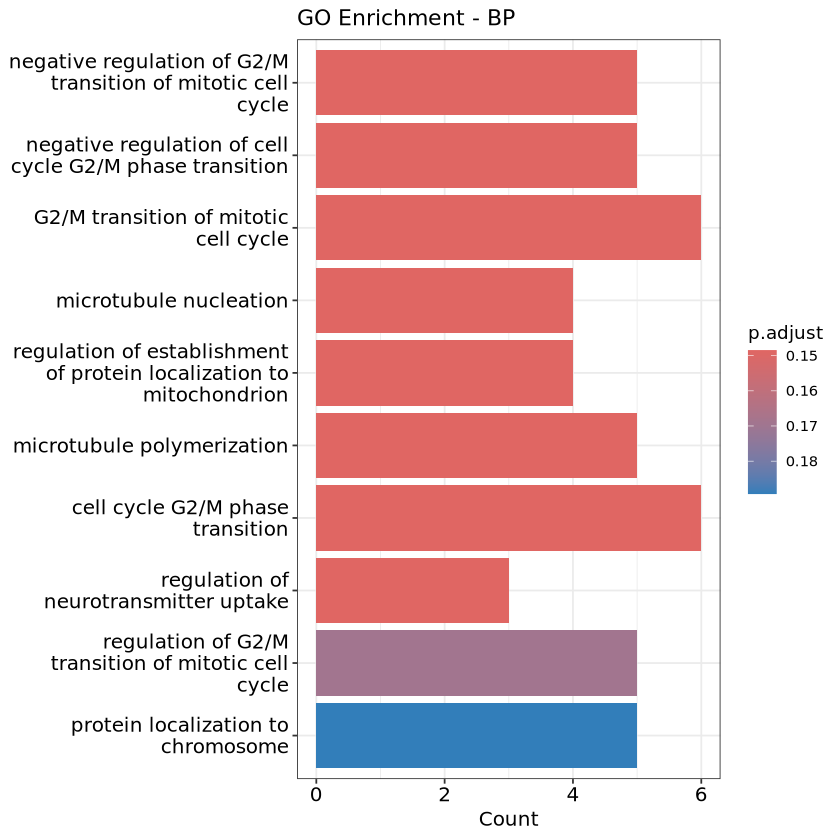

In [24]:
barplot(AD2_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [25]:
AD2_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_AD2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [26]:
head(AD2_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000930,GO:0000930,gamma-tubulin complex,3/130,20/22568,0.0001981792,0.04696847,0.03984445,ENSG00000037042/ENSG00000131462/ENSG00000012048,3
GO:0031252,GO:0031252,cell leading edge,9/130,461/22568,0.0014279550,0.11889052,0.10085760,ENSG00000088992/ENSG00000186868/ENSG00000088280/ENSG00000115306/ENSG00000137312/ENSG00000131462/ENSG00000108852/ENSG00000149091/ENSG00000198561,9
GO:1902911,GO:1902911,protein kinase complex,5/130,174/22568,0.0033911524,0.11889052,0.10085760,ENSG00000183735/ENSG00000136560/ENSG00000115592/ENSG00000204435/ENSG00000175224,5
GO:0001741,GO:0001741,XY body,2/130,16/22568,0.0037478163,0.11889052,0.10085760,ENSG00000143194/ENSG00000012048,2
GO:0036064,GO:0036064,ciliary basal body,5/130,181/22568,0.0040102335,0.11889052,0.10085760,ENSG00000111490/ENSG00000126001/ENSG00000135912/ENSG00000174989/ENSG00000131462,5
GO:0043505,GO:0043505,CENP-A containing nucleosome,2/130,18/22568,0.0047426265,0.11889052,0.10085760,ENSG00000278463/ENSG00000275126,2
GO:0061638,GO:0061638,CENP-A containing chromatin,2/130,18/22568,0.0047426265,0.11889052,0.10085760,ENSG00000278463/ENSG00000275126,2
GO:0032279,GO:0032279,asymmetric synapse,7/130,363/22568,0.0051362985,0.11889052,0.10085760,ENSG00000089250/ENSG00000115306/ENSG00000108852/ENSG00000131094/ENSG00000073969/ENSG00000134569/ENSG00000198561,7
GO:0000775,GO:0000775,"chromosome, centromeric region",6/130,277/22568,0.0054391968,0.11889052,0.10085760,ENSG00000278463/ENSG00000120071/ENSG00000275126/ENSG00000254093/ENSG00000258724/ENSG00000175216,6


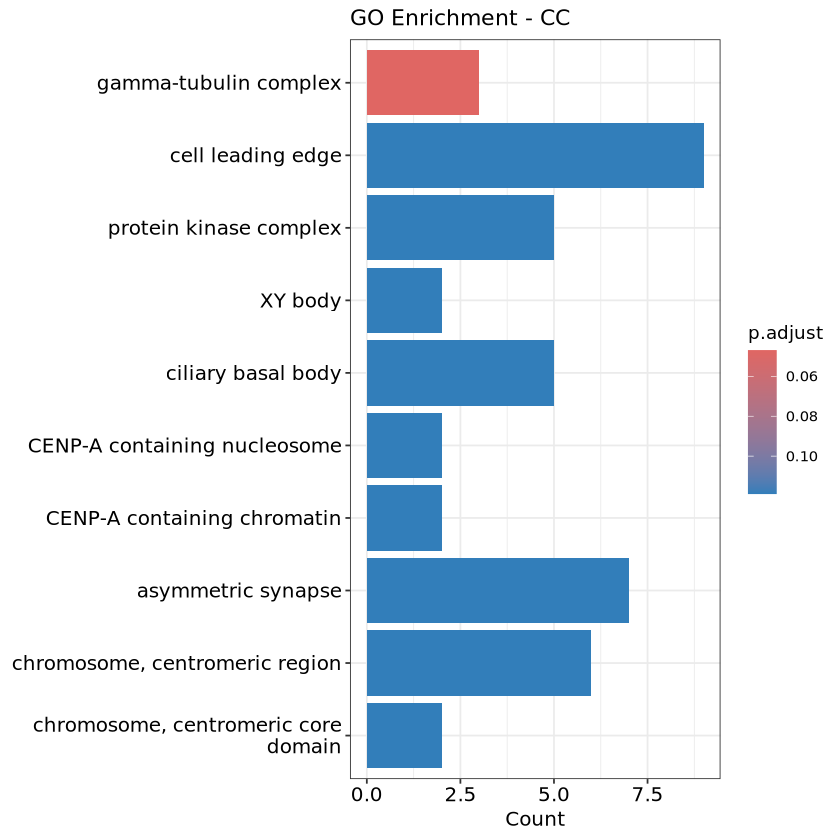

In [27]:
barplot(AD2_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [28]:
image_AD2_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_AD2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [29]:
head(image_AD2_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016667,GO:0016667,"oxidoreductase activity, acting on a sulfur group of donors",3/127,60/21059,0.005706190,0.3606254,0.3429643,ENSG00000174099/ENSG00000086619/ENSG00000213593,3
GO:0005200,GO:0005200,structural constituent of cytoskeleton,4/127,129/21059,0.007779660,0.3606254,0.3429643,ENSG00000115306/ENSG00000037042/ENSG00000131462/ENSG00000131095,4
GO:0034185,GO:0034185,apolipoprotein binding,2/127,23/21059,0.008403172,0.3606254,0.3429643,ENSG00000186868/ENSG00000134569,2
GO:0002161,GO:0002161,aminoacyl-tRNA editing activity,2/127,25/21059,0.009886311,0.3606254,0.3429643,ENSG00000137411/ENSG00000266967,2
GO:0070034,GO:0070034,telomerase RNA binding,2/127,28/21059,0.012311086,0.3606254,0.3429643,ENSG00000254093/ENSG00000258724,2
GO:0019902,GO:0019902,phosphatase binding,5/127,230/21059,0.012904826,0.3606254,0.3429643,ENSG00000102882/ENSG00000186868/ENSG00000183735/ENSG00000146112/ENSG00000132842,5
GO:0004435,GO:0004435,phosphatidylinositol phospholipase C activity,2/127,29/21059,0.013171324,0.3606254,0.3429643,ENSG00000115556/ENSG00000161714,2
GO:0004629,GO:0004629,phospholipase C activity,2/127,32/21059,0.015903270,0.3606254,0.3429643,ENSG00000115556/ENSG00000161714,2
GO:0019887,GO:0019887,protein kinase regulator activity,5/127,249/21059,0.017608966,0.3606254,0.3429643,ENSG00000088992/ENSG00000186834/ENSG00000115592/ENSG00000204435/ENSG00000175224,5


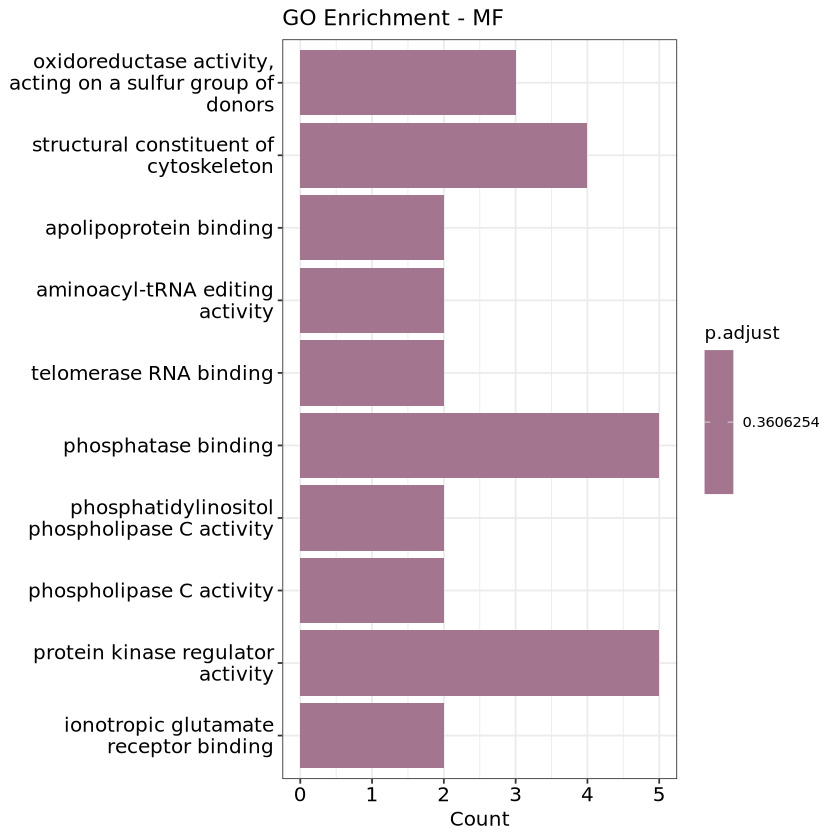

In [30]:
barplot(image_AD2_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [31]:
entrez_ids <- bitr(image_AD2_gene$gene_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(image_AD2_gene$gene_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“2.17% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [32]:
kegg_enrich %>% head(n=20)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05133,Human Diseases,Infectious disease: bacterial,hsa05133,Pertussis,5/58,78/9446,0.0001097923,0.01676827,0.01505756,5595/721/720/110384692/51561,5
hsa04936,Human Diseases,Endocrine and metabolic disease,hsa04936,Alcoholic liver disease,6/58,144/9446,0.0002384114,0.01676827,0.01505756,721/720/110384692/29110/9020/53632,6
hsa05322,Human Diseases,Immune disease,hsa05322,Systemic lupus erythematosus,6/58,144/9446,0.0002384114,0.01676827,0.01505756,8335/721/720/110384692/8368/8969,6
hsa04520,Cellular Processes,Cellular community - eukaryotes,hsa04520,Adherens junction,4/58,93/9446,0.0024894184,0.11580739,0.10399266,5595/1460/83605/1500,4
hsa05171,Human Diseases,Infectious disease: viral,hsa05171,Coronavirus disease - COVID-19,6/58,238/9446,0.0032531460,0.11580739,0.10399266,5595/721/720/110384692/29110/6773,6
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,5/58,169/9446,0.0036835574,0.11580739,0.10399266,5595/29110/10010/9842/9776,5
hsa04625,Organismal Systems,Immune system,hsa04625,C-type lectin receptor signaling pathway,4/58,105/9446,0.0038598159,0.11580739,0.10399266,5595/9020/51561/6773,4
hsa05131,Human Diseases,Infectious disease: bacterial,hsa05131,Shigellosis,6/58,253/9446,0.0043908014,0.11580739,0.10399266,5595/84812/29110/113026/7323/10318,6
hsa04730,Organismal Systems,Nervous system,hsa04730,Long-term depression,3/58,60/9446,0.0058674012,0.13030469,0.11701095,4842/5595/1394,3


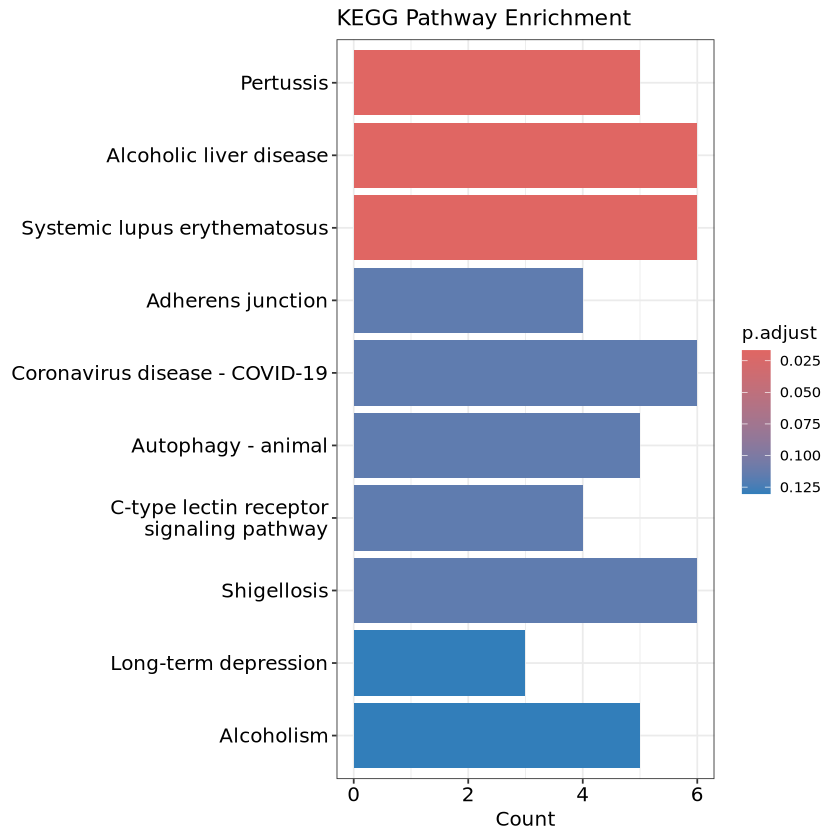

In [33]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")